# A Decoding Accuracy Analysis For Visual Selective Cells

## Project Description

In this project, we would like to look at the decoding accuracy of the visual selective cells. All the visual selective cells are pooled together. There are in total 292 visual selective cells we found using the 1x5 Anova test under the criteria p < 0.05. 

The spike rates are extracted from each trial from each cell, a 100x292 matrix is created for training and testing.

### 1. Load necessary libraries

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [3]:
from sklearn import preprocessing
from classifier import MaxCorrCoefClf
from sklearn.model_selection import KFold

### 2. Get cell data 
Read in saved cell data for all cellss and select the visual selective cells (VS) and memory selective cells (MS) based on their p values

In [4]:
np.random.seed(777)
f_all = open('data/all_cells.p', 'rb')
all_cells = pickle.load(f_all)

In [5]:
vs_cells = [cell for cell in all_cells if cell.p_vs <= 0.05]
ms_cells = [cell for cell in all_cells if cell.p_ms <= 0.05]

In [6]:
print(len(vs_cells))
print(len(ms_cells))

292
135


In [7]:
print(vs_cells[0].session_nr)
print(vs_cells[0].channel_nr)
print(vs_cells[0].cluster_id)

5
2
2


In total we have 292 VS cells and 135 MS cells

### 3. Decoding accuracy

In [63]:
def decoding_trial_processing(cells, start, end, cell_type):
    """
    This function is to extract the spike count rate from a specify time window. The output is sorted by category.
    :param cells: a list of cell objects
    :param start: the start time of the window
    :param end: the end time of the window
    :param cell_type: the type of the cell we want to extract the spike rate at
    :return x_scaled: the z scored spike count rates for each trials
    :return y: the label
    """
    x = np.empty((100, 0))
    y = np.empty((1,0))
    
    if cell_type == 'visual':
        x = np.empty((100, 0))
        for cell in cells:
            trials = cell.trials
            trials.sort(key = lambda trial: trial.category)
            cell_spike_rates = []
            for trial in trials:
                spike_rate = trial.win_spike_rate(start, end)
                cell_spike_rates.append(spike_rate)
            cell_spike_rates = np.matrix(cell_spike_rates).T
            x = np.append(x, cell_spike_rates, axis=1)
        y = np.empty((1,0))
        for i in range(5):
            y = np.append(y, np.repeat(i+1, 20))
        
    elif cell_type == 'memory':
        x = np.empty((50, 0))
        for cell in cells:
            trials = cell.trials
            trials.sort(key = lambda trial: trial.response_recog)
            response_recog = np.array([trial.response_recog for trial in trials]) > 3
            new_old_recog = [trial.new_old_recog for trial in trials]
            correct_marks = np.equal(response_recog, new_old_recog)
            correct_indexes = [i for i, x in enumerate(correct_marks) if x==True]

            y_correct = response_recog[correct_indexes]

            n_old = np.sum(y_correct)
            n_new = len(y_correct) - n_old

            if (n_old < 25) | (n_new < 25):
                continue
            
            # Get the spike counts
            cell_spike_rates = []
            for trial in trials:
                spike_rate = trial.win_spike_rate(start, end)
                cell_spike_rates.append(spike_rate)
            cell_spike_rates = np.array(cell_spike_rates)
            
            x_correct = cell_spike_rates[correct_indexes]
            
            new_indexes = np.equal(y_correct, False)
            old_indexes = np.equal(y_correct, True)
            
            y_new = y_correct[new_indexes]
            y_old = y_correct[old_indexes]
            
            x_new = x_correct[new_indexes]
            x_old = x_correct[old_indexes]

            new_sample_indexes = np.random.choice(n_new, 25, replace=False)
            old_sample_indexes = np.random.choice(n_old, 25, replace=False)
            
            x_new_sampled = x_new[new_sample_indexes]
            x_old_sampled = x_old[old_sample_indexes]
            print(new_sample_indexes)
            print(old_sample_indexes)
            
            y_new_sampled = y_new[new_sample_indexes]
            y_old_sampled = y_old[old_sample_indexes]
            x = np.append(x, np.matrix(np.concatenate([x_new_sampled, x_old_sampled])).T, axis=1)
        for i in range(0,2):
            y = np.append(y, np.repeat(i, 25))
        x_scaled = preprocessing.scale(x)
    return x_scaled, y

def get_sample_trials(x, y):
    """
    A function to generate 10 random sample from 20 trials.
    :param x: The original feature matrix (20 x 292)
    :param y: The original labels (1 x 20)
    :return sample_trials: A random sample of the feature matrix with size 10 (10 x 292)
    :return sample_labels: A random sample of the labels associated with the feature matrix
    """ 
    sample_index = np.random.choice(20, 10, replace=False)
    sample_trials = x[sample_index, :]
    sample_labels = y[sample_index]
    return sample_trials, sample_labels
    
def vs_decoding_model(x, y, iteration=50):
    """
    This function is the model to see how well the spike rate can be decoded.
    :param x: The feature matrix with all spike rates of all trials (100 x 292)
    :param y: The label associated with the feature matrix x (1 x 100)
    :param iteration: The number of iterations that the classification is done.
    :return accuracy: The accuracy score for decoding averaging all iterations and splits.
    """
    y_pred_all = np.empty((1,0))
    y_test_all = np.empty((1,0))
    for i in range(iteration):
        x_sampled = np.empty((0, x.shape[1]))
        y_sampled = np.empty((1, 0))

        for i in range(5):
            start = i*20
            end = (i+1)*20
            x_temp = x[start:end,:]
            y_temp = y[start:end]
            sample_trials, sample_labels = get_sample_trials(x_temp, y_temp)
            x_sampled = np.append(x_sampled, sample_trials, axis=0)
            y_sampled = np.append(y_sampled, sample_labels)
#         for split in range(10):
#             test_indexes = np.arange(5)*10 + split
#             train_indexes = np.delete(np.arange(50), test_indexes)
            
#             x_train = x_sampled[train_indexes, :]
#             y_train = y_sampled[train_indexes]
#             x_test = x_sampled[test_indexes, :]
#             y_test = y_sampled[test_indexes]
#             clf = MaxCorrCoefClf()
#             clf.fit(x_train.T, y_train)
#             y_pred = clf.predict(x_test.T)
#             y_pred_all = np.append(y_pred_all, y_pred)
#             y_test_all = np.append(y_test_all, y_test)
        kf = KFold(n_splits=10, shuffle=True)
        for train_index, test_index in kf.split(x_sampled):
            x_train, x_test = x_sampled[train_index], x_sampled[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = MaxCorrCoefClf()
            clf.fit(x_train.T, y_train)
            y_pred = clf.predict(x_test.T)
            y_pred_all = np.append(y_pred_all, y_pred)
            y_test_all = np.append(y_test_all, y_test)
    accuracy = np.mean(np.equal(y_pred_all, y_test_all))
    return accuracy

def decoding_simple_cv(x, y):   
    y_pred_all = []
    y_test_all = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = MaxCorrCoefClf()
        clf.fit(x_train.T, y_train)
        y_pred = clf.predict(x_test.T)
        y_pred_all = np.append(y_pred_all, y_pred)
        y_test_all = np.append(y_test_all, y_test)
    return np.mean(np.equal(y_pred_all, y_test_all))

def decoding_over_time(cells, bin_size, step_size, cell_type, model, time_range=(0, 4000)):
    """
    The function to get the accuracy over the time of trials.
    :param vs_cells: The cells that we want to decode.
    :param bin_size: The size of the time window that we extract the spike rate from.
    :param step_size: The size that the window more forward each time.
    :param cell_type: The type of cells 'visual' or 'memory' that we are running this at. (Not finished yet)
    :param time_range: The time course that the analysis starts and ends
    :return accuracies: The accuracies accross the time course.
    :return x_plot: The x value for plotting the accuracy.
    """ 
    start = time_range[0]
    end = start + bin_size
    plot_step = bin_size/2
    accuracies = []
    x_plot = []
    while end < time_range[1]:
        if cell_type == 'visual':
            x, y = decoding_trial_processing(cells, start, end, cell_type)
            accuracy = model(x, y)
            accuracies.append(accuracy)
        elif cell_type == 'memory':
            iteration_accuracies = []
            for i in range(5):
                x, y = decoding_trial_processing(cells, start, end, cell_type)
                iteration_accuracies.append(model(x, y))
            accuracy = np.mean(iteration_accuracies)
            accuracies.append(accuracy)
        x_plot.append(start + plot_step)
        start = start + step_size
        end = start + bin_size
    return accuracies, x_plot

def decoding_time_matrix(cells, bin_size, step_size, time_range=(0, 4000)):
    """
    This function is used to get the accuracy matrix when we want to use the spike rate of a time frame to decode the spike 
    rate in another time frame. The output of this matrix can be plotted in a heatmap to see how the decoding accuracy is
    correlated over time.
    :param cells: The cells that carries the data.
    :param bin_size: The bin size that the spike is generated from.
    :param step_size: The size of steps the window move forward each time.
    :param time_range: The time range of the entire analysis.
    :return accuracy_matrix: The accuracy matrix stores the accuracy for all the time bins when training on their spike rates
                             and testing on the other time bins.
    """
    start = time_range[0]
    end = start + bin_size
    
    clf = MaxCorrCoefClf()
    accuracy_matrix = []
    while end < time_range[1]:
        x_train, y_train = decoding_trial_processing(cells, start, end, cell_type='visual')
        test_start = time_range[0]
        test_end = test_start + bin_size
        clf.fit(x_train.T, y_train)
        accuracies = []
        while test_end < time_range[1]:
            x_test, y_test  = decoding_trial_processing(cells, test_start, test_end, cell_type='visual')
            y_pred = clf.predict(x_test.T)
            accuracy = np.mean(np.equal(y_pred, y_test))
            accuracies.append(accuracy)
            test_start = test_start + step_size
            test_end = test_start + bin_size
        accuracy_matrix.append(accuracies)
        start = start + step_size
        end = start + bin_size
    return np.array(accuracy_matrix)
    

In [64]:
accuracies_ms, x_plot_ms = decoding_over_time(ms_cells, 500, 50, 'memory', decoding_simple_cv)

[ 7  3 20  8 13 35 22 33 21 27 19  5 25 32 23 16  9 26  4 17  2  1 36  6
 18]
[17 18  5  8  9  3  0  2  6 13 24 19 22 31  1 12 16 28 23 11  4 15 14 25
 33]
[24  1 32 33  6 14 19  0 30  8 21  9 17  4 23 13 27 16 29 10 25 22 11  7
 20]
[33 13 16  1  0 10 17 25  4  3 32  5 31  2 29 21 35 18 12  7 22 28 19  6
 23]
[ 5  7 19 15  4  1  8  6 31 20 16 32 29 13 12 23 26  0 24 22 33 14  3 27
 17]
[12 17 24  6  3 14 26 10 31 22 16  2 27 15 32  0  1 29 23 28 21  4 34  8
 30]
[13  7 12 14  9 35 19 16 20 31 10  0  8 32 28 25 11 17  3 27 26 22  4  2
 15]
[15 20 16 10 14 34  9 29 25 32  2 24 28 31 17  3  8  0 27 30 33 13 11 26
 19]
[27  4 42 31 13 21 26  2  1  7 10 18 16 20 45 34 44 32 19 12 14 23 46 36
  9]
[11 21 20 24 14  7 22 15 26  8  0 17 12 28  3  5 19  2 16 25 10  4  9 13
 23]
[ 8 17  4 18 11  9 35 14 40 33 37 10 42  6 36 34 27  0 43 22 32 19  7  1
 26]
[18 25  0  8 28  6  4  9  1 24 12 13 11 23 16  7  5 10 22 15 27 21  2 20
 26]
[22 32 24 35 39 28  6 17 34 16 38  0  8  9 19 33 23  4 12  3 14 

  5]
[21  2  9 10 17 12  6 19 30 26 16  8  7 14 31  3 28 13 29 15 18  5 24  1
 22]
[23 11 21  8  0  4 25  5 17  6  9 12  2 15 20 10  3 19  1 13 22  7 16 18
 24]
[ 7  0 22 15  5 39  9 34 21  4 37  8 24 16 36 29 20 38 35  6 32 19 27 26
  3]
[41  4 10 22  7 36 25 26 38 24 42 31 32 19 20  3 17 23 35 18 27 37 34  8
  9]
[ 1 14 17 29  0 25 15 16  3  4 34 10  5 37 36  9  8 31 18 33  6 32 19 26
 23]
[32  5 10 30  0 22 27 17  7 18 11 23  6 25 20 15  4 14 12  1 21  2 33  8
  3]
[20 11 22 16 14  6  8 17 21 24 25 19 18 27  1  9  2  4 10  7 12 23 28  0
 13]
[16  5  8  7  9 26  6 36 22  2 12 39  4 21 14 46 25 40 20 31 42 18 17 41
 33]
[28 40 43 31 32 17 33 20 12 22 36  1 38 11 25 21  9  7  0  4  6 44 41 18
 30]
[14  5 24 33 28 35  7 20 32 19  6 27 34 15 12 11 23 10 26  3 25  0  4 30
 31]
[20  4 42  5 19 17 37 12 41 11 25  0  3  6 18 40 30  7  8  2 26 16 13 21
 15]
[24 13 20 16 26  1  9 35  5  2 31 33 30 19 10 12 21 32  4 27  7 14 28  6
  8]
[34 42 31 12  5 38  2  6 20  7 35 37 18 28  4 15 36 32 44 2

  3]
[ 7 28 22 26 15 13 27 25  4 16  3 21  5  6 14 20 10 11  9 24 17 12  0  8
 18]
[ 1 10 22 32 14  8 34  9  4 20 33 15 25 35 44  7 29  5 39 13 36  3 19 12
 26]
[17 16  4  2 22 18 15  3 25  1 12 21  0 14  6 13 24  5  7 26 19 28 23 20
  9]
[12 11 34  5 21 24 13 33 31 25 19 17 18  3  1 27 29 32  7 16 28 15 39  4
 30]
[ 9 19  0 26 20 27  4 11 23  8  7 16 17  3  2 21 12 24  1 22 10 15 18 25
  6]
[27  3 23 24 29  6  8 36 18  2  7 14 10 21 34 28 32  1 20 15 33 35  0 12
 13]
[31  9 10 26 28 33 24  2  4 22  0 21  8 25  6 29 27 11 15 12 34 14 16 20
 30]
[36  0  2  9 13 11 19 24 12  3  7 26 14 37 18 33 30 31 17 10 23  4 16  5
 20]
[24 15  9 17 13 25 34  7 14  4 27 30  2 12  3  0 33 19  1 31  8  6  5 28
 10]
[14 12  5 18 13 37 34  8  0 30  9 26 22 10 16 11 24 29 28 33 35 31 23 20
  1]
[33 15 19 32 11  8 12  4 28 30 24  2  6 18  0 25  1 34 17 29 14  3 22 21
 31]
[16 14 11  0 26  8  7  4  2 25  6 10  9 24 22 12 20 23  1 19 21 17  5 13
  3]
[ 5 27 13  6 35 19 34  9 23 22 10 37 39 28 26 36 31 25 20 1

 12]
[25 24  8  3 23 20  7  0  4 13 15 11 14  1 12  6 17 21 22 16  5 18 19  2
 10]
[28 29 16 40 41  7  8 27  3 21 38 36 12 15 39 34 13 23 14 22 32  2 30  1
 26]
[11 19  7 21  4  1  9  5 14 12 13 20 16 25  0 17  3  8  2 23 22 10 18  6
 15]
[22 28  7 16 34 30 31 29 21 23 15  3  6 40  5 20  9 12 39 41  8  4 10 11
 26]
[11  9 19 17 25  7 10  0 14 20  5 23 24 18  2 16  6 12 21  1 22 13  4  3
  8]
[31 19 41  2 18 11 39 25 36 38 20 34 15  9  1 21 32 28  0 37 12  5  4  3
 29]
[28 33 19 15 22  3 37 17 13 45 26  6  1  4 32 20 23  0 41 31 24 16 39 27
 12]
[31  1  4 17  5 29 18 12 21  2 25 24 27 30 28 11 19  0  3 23 26 13 20 14
  8]
[17  0 14 35 24 34 33 22 10 21  2  6 31 12 11 36 19 37 15  4 26 30 28 23
 20]
[14  1 12 19 21 16 34 28 33 24  5  3  2 26 32 25 17  7 11  0 31 15 36 30
 10]
[15  9 27 35 26 14  2 12 23  8 38 22 32 24 10 17 13  3 19 18 16 29 21 33
 34]
[10 13 12  3  0 11  2  5 16  1 30 18  4 23  6 26  7  9 24 27 21 14 15 25
 22]
[23 30 19  0 22 32 37 10 12 38 27 20  7 18 15 25  3  8 29 1

[11 32 15  0 36 12  1 16  3 23 31 24  2 34 27 33 20 10  6 18  4 28 30 19
 37]
[13 35 12 34  5  9 17 31  6 25  8 33 22 14 21 30 26 32 37 38 29 20 39  4
  3]
[18 14  4 12 31  1  0  6 16 13  9 25 30  3 20 15 19  5 27 26 17  8 22 24
 23]
[21 20  2 22 13  6  3 19  7 24 11 16  5 25 15 17  0 14 10  8  4  1 23 12
  9]
[ 0 37 19 35 39 24 16 26 18  9 30 29 10  6 36 38 33  5 25 11 12  3  7  8
 23]
[22 41  9 24 17  4 26 35  3 37 40 42  8 27  5 31 11  6 20 30 19 36 13 34
  2]
[30  6 23 33 17 36 27 13 19 28 10  9 14 31  8 18 38 21 29 32 37  3  5  7
 15]
[31 27 30 20  7 24  6 33 12 22  9 11 29  2  3 25 23 26 16  4  5 13 10 17
  8]
[16 23  8 17 19  0 12  1 10 15  7  4  5  9 25 26 21 27 11 18 28  3 14 24
 22]
[ 1 11 39 24 34 31 30 29  2 14 32 36 35 20 38 15 26 46 21 12 19  0 25 13
 23]
[29 35 14  5  3 25 27 33 15 45 13 28  2 38 40 18  1  6 26 36  0 42 11 21
 30]
[24 20 14 16 13  1  8 17 18  2 10  5 29 12 11 28 15  0  6  7  4 22 32 21
 30]
[25  7 29 10 30  8 36 26 39 22 23 21 14 32 28 35 24 19 33  5 37 

 17]
[19 24 21  4 22  8 14 12  7 18 31 27 10  9 28  3 26 20 17 30 15  1 25  6
  2]
[22 14 15 19  3 16 25 29  8 20 27 17 11  9 24 21 26 10 13 12 35 31  5 37
 30]
[17 13 18 15 16 12 28  8 21 25 14 30 26 11  0  6 22  2 20  5 29 27 10  3
  4]
[ 3 33  0 20 27  6 28 32 31 11 23 10  1 29 26 35 18 14 38  9 13 34 37  8
 25]
[44  6 17 34 31 30 26 16 33 24 12  2 18 23 10 25 36 37  3 15 21  9 11  4
 40]
[ 3 24 15 22 21 19  1 23 13  7 18 29  8 11  5 27 12  4 16 28  9  6 20 14
 25]
[13 11 39 12 31  9 23  0 33 16 21 19 30 15 29  7 34 14 25  8  5 36 32 22
  1]
[17 23  2  7 11 10 13  0 20 25 14  4 27 28 19  8  9  1 16  5 22 29  6 12
 24]
[20 11 27 31 30 17 12 23 19  9  2  5  3 22  8 28 21 18 16 29 26 24  0 14
 25]
[25 28 31 13 16 26 30 20  1 29  0 22 17 15 11  5 18  6 24  8 23 14  9  3
 33]
[27 37 24 32 38  5 20 34 30  3 14  7 11 13  9  6 33 35 26  4 17 36  2 18
  0]
[22 23 20  4 11 28 14 15  7  8 18 19 21 29 12 13 27 17 16  0  3  6 26  5
  9]
[ 6 10 32 16 40 26 15 20 39  4  7 11 31  1  5 19 36  8 24 2

 35]
[ 2  5  3  8  9 30 23 25 15  1 21 16 19 11 18  6 13  7 24  0  4 20 12 28
 27]
[ 6  1 29 35 12 34 20 14 18 27  9  3 32  5 37 26  0  8 36 33 15 11 19 23
 31]
[34  3 29  7 28 31 13 25 22 10 11 15 24 21  5  4  1 14  8 33 17 27  6  9
 23]
[ 1 34 12  9 29 13 27 22 36 25  3  4 35 16 32 24  8 23  0 37  7 10  5 11
  2]
[24  2 11 27 22 26 16  6 13  3 29  1 31 23  8  4  9 18 12  7  0 21 25 15
 14]
[17 29 38 31  3 21  4 24 35 12  6 26 11 37 25 33  9 20 19 23  1 13 28 30
  7]
[ 6  9 22 16 28 21 19 12 10 25 17 20 29 13  2 18 26  3  4 11 31  0  8  7
 14]
[21 11 17  5 19 16 33 34 35 20 32 30 37  9  3 10 31  1 23  7 22  2 26 18
  0]
[16 20  5 30 21 31 27 24  9  8 29  6 12 17 18 22  3 11  4 10  0 25  2 19
  1]
[ 6 37 26  7 10 36 35 34 23 30 11  8 28 17 15 18 16  0 32 14  5 21 19 20
 29]
[44 25  7 29 11 38 21 33 27 24 13  2 19 20 39 32 15 23  8 17 16 43 35 30
 26]
[32 21 18  0 37 16 11 30  5 40 14 34  2 27 36 17 26 23  3 19 33 29 15 10
  9]
[41  3 31 17  4 16 15 46 20 21 33  1  6 38 18 24 39 45 42  

  5]
[19  6 27 10 23  8 24 16  3  2  1  0 21 28 20 14 17  7 12  9 11 22 26 18
  4]
[43  8 34 45  0  5 10 23 16  3  1 36 11 12 28 26 19 37 44 46 25  4  9 14
 17]
[ 7  3 16 20 24 28  0  1 19 22 26  6  5 10  9 13  4 14 25 15  8 11  2 18
 27]
[ 6 33 18  2 43 27 20 42 34  7  9  4 37 29 32 15 24 30 13 46 25 16 26 22
  5]
[ 9 16  0  4  3  7 20  1 22 28  8 25 15 17 21 14 19 18 11  5 12 24  6  2
 27]
[13 34 33 37 28 36 19 38 30  4 20 27  9  7 18 17 10  6 39  3 41 43 16 23
 22]
[22  5 13  2 17 10 15 12 27 16  6 24  7 28 18  9 14  8  3  0 20  1 19  4
 25]
[ 6 34  9  4 45 13 10 18 17  1 14 19 23 32 15 20  7 28 22 12 25 35 16 36
 41]
[ 4 21  7  6 20 16 23 10  0  9 28 15  5 27 26 18 11 12  1  2 17 13 14 25
 19]
[24 27  3 44 46 15  7 25 13 37 17 12 36 33 19  1 21 45 41  6 20 23 38 26
 22]
[20  8  5 14 12 13 24 15 28 26  2 17  4  1 18 27 11 19 22  7 23  9 25  0
 21]
[40 20  6 46 19 21 44 42 29 24 41 39  3 37 11  5 35  0 33 30 43 25 32 36
  8]
[ 8  5 24  2 13  9 26 19 16  4 10  7  6 12 15  3 20 21  0 2

[16  3 23 25 34  4 26 35 33 32 19 29 10  0 14 18 30  1 20 37 17  2  5 13
  8]
[ 7 31  1 26  4 13 27 23  2 32 22 25 18 29 14 15 30 21  8 10 17 16 12  0
 24]
[ 6 12 20 23  9 13 26  5  0 16 22 14 18  7 11 10  8  2 25  3 24  1  4 15
 21]
[40 41 34 20 31  2 18  9 21 12  0 37 30 35 27  5  4  1 10  7 11 23 17 26
 25]
[27 16 20 15  2 22  0 11 29  5  8  1 17 19 24 18 14 13 25 23 21 30 31 28
 10]
[ 2  1 23 10 24 11 35 30 12 21 27 20 32  5 26 38 17  3 34 29  0 28  8 15
 31]
[20 16 24  7 18 29  8 14  3 13 28 17 31  0 12 23 10 15  6 27  9 26 19 11
 22]
[32 15 34 37 14 35 39 20 17  4 18 29 10  1 36 38 22 23 28 21  0 24  2 12
 25]
[17  7  4 25 27  6 24  3 10 28 14 31 26  8  2 19 16 15 11 23  9 30 21 22
  5]
[19  7 33 22  3 13  5 32 38  4 26 11  0 31 18 17  2 14 25 20  6 12 29  8
 16]
[20 19 10 16 27 43  3 38 33 12 36  8 34 11 14 42 18 17  1 41  2 26 30 25
 22]
[16 12 19  6 28 11  3 13 23  5 20  1  4 15 22 25 17 29 21 18  8  2  7  0
 27]
[44 23  4 42 15  1 17  7 18 22 29  2 40 30 28 16 39 13 34  3 36 

 13]
[ 8 10 13  2 25 24 19 15 20 23 26  1 27  6  7 14 17 28 21  9  3 11  4 22
  0]
[22 16 42 15  3 23 26  0 12 31 30 13 11  8 17 36 25 40 43 45 39 29 28 14
 41]
[27 29 23 14  4 26 11 28 15 10 21 17 20  5 12  1 19  6 25  8  7  2  9 22
 18]
[ 3 30  0 10 33 31 43 19 35 38 32  2  6 27 41 45 11 13 36 42 17  5 28 24
 20]
[24  0  9  4 21 18 19 29 10 12 22 17  7  2 14 15 23 27 11  8  3 16  6  5
 26]
[38 15  6 27 43  7  8 39  1 35  4 23 10  0 13 34 18 32 41  3 44 11 14 21
 22]
[22  7  5 17  8  6 18  2  4 16 19  9 26 11 21  0 12  3 28 15 14 20 10 29
 25]
[11 16 18 34 43 10 17 23 24 21 28  3 37 31 29  4 12 35 40 15 25 26 20  8
 30]
[13  8 18 20  6 24 14 16  9  7  4 22 12 15  1 21 23  5  2 17 11  0 10 19
  3]
[18  4 19  5 16 24 30 38 20 29 28 14  7 39 34 37 10 35 25 17  9 32 15 26
  6]
[16 17 20  3 21  0  2  8 18 23  9 22  6 10 11 19  1 24 12 25 14  7 13  5
  4]
[17 35 16 37 10 22 39 28 23 15 12 27  5  2 26 25 38 32  7 34  9  8 36  3
 19]
[10  0 13 19 14  2  9 21  1 15 12 11 24  6 25  7 23 22  5 1

 10]
[14 24 13  6  4 33 23 15 18 26 22  1 12 10  2 32 28  9 16 29  0  8 21 31
 17]
[18 33  0 11 17 20 31 27 24 28 25 21  4 19 10  7 16  1 12 30 14  9  5 32
 35]
[ 7 13 15 23 18 29  9 21  6 28 17 22  0 32 10  3 25 16  5 33 30 24  1  8
 14]
[23 26 32 19 27 20 13  3  2  0 15 31 24 30 18  7 28 35 16 10 25  9  8 34
 21]
[33 26 12 11  9 28 10 23  8 29 32  3 17 20 19 15  6  5  1 27  4 24 18 21
 16]
[ 7 19 16 44 33 34  9 12 27 25 45 28 42  3  0 31 17 13 14  6  4 10 21  2
 24]
[ 2 13 14  3 17 20 10  7 11 19 15  0 22 24  5  6 26  1 21 23 27 28  8 16
 12]
[29 26  0 17 23 12  8 45 35 25 33 31  6 40  3 44 39 28  2 38  5  7 34 43
 41]
[ 2 16  5  9 23 25  4 14  7  3 20 24 22 17 13 26  8  6 28 27  1 19 10 11
  0]
[ 7 44 32 17 27 45 38 39 42 24 35 46 12 41 16 11 19 15 20 18 34 29 37  6
 23]
[20 27 24 26 14  5  2  9 28 22  1  7 11  3  8 23 13 19  6 15 16 25  4 12
 21]
[32 24 40 10 12  8 31  4 43 33 37 18 27  2 26 19 23 15 34 16  7 25  1 22
 42]
[20 25 21  3 12 28 19 10  2 15  5 22  0 11  1 26  6 14  9  

  9]
[ 6 18 15  3 17 23 27  2 26 13 21  4 11 12 10  5 25 16  9 22  1  7 24  0
 14]
[13  4 27 20 26 15 39 28  7 30  2 14 35 17 33 29  0  9  1 24 23 21 12  5
 18]
[23 13  1 17 20  5 10 19 27  0 21  8 16  7 22 12 15 18 11 25 26  3  6  9
 14]
[19  0 21 33 36 24 20 22 34 27  8 23 26 11 16 10 29 15 37 32 30 17 31  2
 12]
[16 34  2 15 17 21 31  5 19 23 28 26 29 14  6  4  9 20 32 30 18  8 27  3
  7]
[ 1  8 27 12 30 13 16 35 20 33 22 37 31  0 18 24 32 11 28 14  5 21 23 25
 26]
[10  9  2 13  1 33 25 15 24  6 12 30  5  0 17 27  4 28 11 20 14 18 23 29
 19]
[ 8 22 31  5 10 20 19 13 26 24  3  0 35  1 12 37 21 32 11  4 33 18 34 36
  6]
[19 21 22  1 12 17 20 25 15 16  3  2  7 30  9 13 34 24 26 32  4 11 28  6
 27]
[13  1  4  0 22  8 10  7 20 16  3 15  9 11 24 12 26 14  5  6  2 21 17 23
 25]
[ 1 10 19 38 23 25  2 17 14 36  0 20  5 30 37 32 11  6 40 34 31 39 16 27
 29]
[10  4 20 12  1  3 25 21 27 17 16 14 31 18  6  8 30 11 19 29 15  7 22 23
  9]
[ 8 37 11 35 23 18 22 16 20 25  1  9 27 21  0 29  3  7 24 1

[11  7  2 35  4 31  8  1 24 10 29 38  0  5 21 40 23  9 26 33 12 20  3 15
 39]
[10  6 16 24  8 33 26  5 23 25 11 29  0  1  3 30 28  4 19 17 32 15 22 20
 21]
[29 16  3 27 24 19  2  4  8 22  7 25 28  5 10 21 17 23 15 13 12 18  0  6
 26]
[44 24 48 20 19 11  1 25 39 34 26 30 17  6  0  4 27 13 29  2  5  3 45 46
 41]
[12  4 18 29 20 15 14 17  8  0 19 26 22 24 23 28 10 16  9 25  1 27 21 13
  3]
[48 17 33 41  4  8 13 18 25 32 46 47 40 36  5 11  7 31 35 16 28 14 38 24
 12]
[16 27 10 29 19 20 22  5 15 25 21  9 11 28 24 23  4 14  0  3  2 13 18  7
  6]
[19 12 42 17 24 20 31 30 43 14 46 10 25 33  4 11 26 16  8 35 22 45 13 18
  6]
[14  7 20 13  4  5  1 21 25 10 11  0 16 28 18  3 17 27 19 29 22 24 26 23
  2]
[35 24 11  0 41 27 33 45  2 15 37 17 25 23  1 10 12 47 14 39 18 48 13 20
  7]
[20 24 22  5 18 14 15 17  1 10  4  6 13 21 28  0 29 12 19 26  8 27 16 23
  2]
[ 1 34 17 35  9 41 13 24  7 18 44 37 29 10 43 39 26  8 27 33 32 20 12 31
 25]
[13 27  6 20  3  7 12 28  0 15 25  9 11 24 17 23 18 14 16 21 29 

[17 30 21 37 19 26 28 32 18 31  7 23  3 27 12  2  9  5 29  6  0 11 15 34
  4]
[10 22 25  1 16  8  2 19 17 18  9 20 14  5 13  4 21  7  6  0 26 12 24  3
 11]
[14  8  2 23  3  6 29 21 25 26  5 27  9 22 16 13  0  7 30 31 17 18  1 15
 10]
[28 34 33 26 22 27 13  4 24 16 23 32 19  6 14  2 12  8  1 25  5 30 20 15
 21]
[ 0 24 28 22 16 31 20 26 29  7 30  9 17  6  2 10 23  1  3  5  4 11  8 18
 14]
[13  9 31 28 20  7 33  1 34 10 27 17 12 19  4  5  2 21  6 32 30 14  0 29
 23]
[ 8  2 27  5 10 21 26 30 16 22 28 11  6 29 25 17  1 32 13 31  3  9  0 12
 18]
[19  7  0  5 13  1 17 21 12  3 18 20  8  6 14 11 10 24 15 23 16  2  4 22
  9]
[ 5 10 33 23  0 12 22 14 19 15 16 27 29 20 26 32 31 30  9  3 13 17  7  4
 28]
[ 6 14  4  7 35 21 20  0  8 34 15 38 31 11 13 12 39  2 24 19 29 10 16  1
 26]
[ 0  3  9 23 20 26 16 32 21  2 33 13 12 24  5 17 14 27 11 10  4 29  1 31
 22]
[ 4  1 13 12 16  9 20 22 37 25 11 35 36  5 18  7 27 23 38 10 28 17  8 34
 19]
[26  4  7 25 30  5 22 28 14 11 17 16  9 31 18 13 12  3 19 21 33 

  6]
[14 22 40 20 30  1  2 18 27 36  7  6 37 31 25 34 33  0 11 39  8 35 29 23
  9]
[42 13  9  6 15 41  1  5  7 12 10 37  2 40 43 35  3 30 38 33 28 44 17 27
 25]
[ 4 13 24 22 26  0 15 12 11  2 10 19  3  8 21 20 27 31  6  7 28  9 23 14
 30]
[37  9 16 25 22  2  7 36  4  3 34 18  5 30 32 35  0 14  1 11 26 10 17 27
  6]
[ 5 15  8 11  3 24 23  2 18  0 22  1  6 12 19 35 16 28 26 10 21 13  7 20
  9]
[25 16 13  9 37 23 35 14 10 15 29 30 12  3 24  2 34 22 17 27 33 18  8 32
  0]
[14 20  0 29 31 17 27 15 25 12  3  1 22 11 13  9 28  6  2  8 19 18 21  5
 10]
[18  7 27  3  2 31 22 33 14 21 10 17  9 32 12 25 16 26 20 36 23  5 30 37
  6]
[29  4 28  0  9  1 16 30 31 19 26 21 13 11 23  2 22  5 15 18 10 12 27  3
  7]
[ 8 30 21 22 19 13 26  6  5 20 12  0 36  1 14 38 18 32 28  9 35 16 10 11
 27]
[24 23 22 12 15  4  5 17  6 20 25  7  9 16 29 28 31 10  3  1  0 13 19  8
 11]
[12 21 33 20 22  7 31 39  8  5  2  1 36 37 25 15 18 34 40 14 27  4  6 35
 30]
[43  1 29 41 11 19 45 14 22 25 42  0 17 34 35 12  3 15  5 4

 32]
[15 29  0  4 19 27  1  7 16 26 12 21 28  3 18 32 31 23  5  9  2 22 30 24
 17]
[18 17 35 14  0 32  3 22 34 13  6  1 16 11  8 28 30 15  5 23  7 31 21 25
  9]
[17 18 16 20 10 26 13  6 11  3  7 31  1 12 23  9 33  8 15 22 30 27 25 32
 21]
[ 3  9 33 17  0 23 34 28 16 10 20 27  1 12 24  8 30 19  4 22  6 35 15 21
 31]
[23 28 21 11 24 27 17 16  0 20  3 25 15 10 22 12  5  4 32 14 33 29 30  6
  7]
[19 11  1 29 40 27 42  2 14 36 33 28 45 37 43 20 16 44 46  6 10 38 31  8
 41]
[ 5  1 15 13  0 20 24  8 23 19  4  3 16 14 28 25 21 27 18 11 26  2 12  9
 17]
[ 4 37 19 32 29 31 12 43  8 14 42 26 28 21 24 17 46  7 38 23 15  2  5 16
 18]
[25 18  1 16 27 12  7 20  3  9 28  0 11  6 10  5  8  2 24  4 26 23 19 15
 17]
[15  1 42 13 22 16 18 27 14 32 36 29 46 12 45 23 37 31  9 28 40 33 11 17
  4]
[17 25 16 27 13 23 18 22 15  6 26  2  8 10 11 24  7  0 21 12 14  1  3  5
  9]
[30 17 46 21  8 23 31 41 40 32 15 35 45 28  2 33 34 12 14 29 10  3 44  5
 19]
[ 8  7 16  3  0 24 10 17 21 12  1  4  6  5 18 26  9 13 28 1

 21]
[22 29  2  8 12  1 16 17 14  7 10 18  6 19 26  5 11 25 13 23  3 27 24 21
  0]
[23 16  0 30 12 10  3  6 39 14 18  5 22  4  7 36 37 34 26 31  8 28 35 25
 15]
[ 2 16 21 40 29 24 22 34 13  3  7 26  0 32 33  9 15 11 23 37 38  5  8  1
 27]
[ 1  5 27 20 26  9  6 19  2 11  7 28  0 23 14 15 16 17 12 22 29 18 10 13
  3]
[29 10 25 42 19  5 34  7 15  9 32 18 27  3  0 13 31 43 21  4 36 41 12 37
  6]
[29 16 17 27 20 26  2 11  6 22 23 18  7  4 21  0 28 14  9 13 19 24 12  1
 15]
[28  0  7  1  6  3 24  2 11 31  9 26 20 12 15 17  8 23 25 29  4 27  5 21
 30]
[27 21  7 26  0  4  8 20 19  1 29 32 30 33  3 23 15 12 13  5 16 17 28 14
 10]
[ 4 20 34 29 27  6 32 18 25 21  9  3 22  1  7 16 35 36 30 37 11 17 15 28
 39]
[21 15  5  0 28  3 10 17  8  4 11 14  7  2 29 12 16 22 20  9 13 26 25  6
  1]
[32 22 38 24 31  5 16 13 29 12 21 35 40  7 11 27 37  3  0  9 18 34 25  1
  4]
[17 19  0 28  9 10 27 20 13  7 25 24 12 26  3 15 16 14 23  1  5  6 30 22
 29]
[15 26  3  0  8 36 27 28 32  9  5 34 19 13 10 14 18 40 31 3

[ 8  7 34 15 38 18 13 30 17 40  4 39 14 28 16 36 23  9  6 21 32 25 24  2
 29]
[ 9 29 11  2 12  3 20 25  4 28 18  8 13 31 22  6 17 14 27 21  7 10  0  1
 15]
[26 32 23  3 12 35 28 39  4 27 25 33 29 22 31  8 19 16 17 14 10  2 11 18
 21]
[21 15  0 26 10 31 27 11 13 12  6 17  2 23 29  4  8 14 19 30 28  7 22 24
  3]
[31 38 23 19 34 10 21  7 40 39 15 14 41 20  1 17 25  3 16 30  2 27  9  0
 35]
[ 2 12 24  6  1  5 25 14 26 31 16 10 13  0 17  8  7  4 30  9 20 27 15  3
 19]
[23 13  7 16 28  2  5 21 27 12  3 20 26 38 11 15 31 17 24 30  8  1  6 25
 22]
[11 26  3  6  5 28 30 20 24 10 29  4 31  7 17 13 25 16 19 14 27 12 21 15
  0]
[20 32 21 27 12 26  1 15 13 19 14  5  7 22 23 24 18 16  3 11 31  4 17 29
  2]
[28 24  1 12 30 34 32 16  0 18  2 15 22 19 14 33 23 17 29 26 35 13 39 10
  4]
[34 40  3 10 36 31 32  7  2 22  9 17 12 18 13 30 23  0  1 24  4 28  8 21
 41]
[34 15 26 14  9 25 19  7 24 33 42 10 17 40 29 23 12  5 16  8 18 31 32 27
 39]
[35 19 26 34 13  1  6 32 23 17 21 22 15  5 11 33  8 27  9  0 30 

[19 23  4  3  6 10 28 24 18 31  7 37 13 35 30 38  1 16 15 29 36 22 39 32
 34]
[ 7 19 13 32 12 10 11  6 22 25 27 17 18 29 20 16 31  9 24 21  0 33 28  2
 15]
[29 12 24  2 16 37 35 22 10 27 26 17 34 31 38 21  3 30 25  8 33 36 20  0
  5]
[33 24 12 14 17  1 20  0 27  8 25 18 23 32 10  5 21  9 31 16  2  3 22  6
  4]
[16  2 22  9 23  1 19 14 12  7 25 21 26  6 28  5 20 24  0 18 10 15 27  8
  3]
[36  7 29 13 44 43 26  1  5 23  9 47 17 31  2 14 25 42 27  0  3 18 41 37
 34]
[17 19 26 13  5  0  1  2 22  7 25 20 24 21 11 18  9 15  3 14 27 29 28  8
 10]
[31 20 41 27 10 22 47 30 26  5 14  1 35 48 40 16 25 44 15 17  0  9 12 24
 36]
[ 8 17  7 10  5 25 20  4  6 23 15 27  0 18  9 19 29 24 16 26 28 14 11  1
 12]
[ 8 25  6 40  1 22 13 10 23 16 41 28 32 14 35 20 46 48 21 19 31 11 29 24
  7]
[28  7 21  3 12 17 13  0  2 22 11 24  8  4 19 16 18  6 14 27 29 25 26 15
  5]
[17 22 47 14 24 13 19 20 39 23  6 42 40 21 46 18  5 37 36 31 26 45 34 10
  4]
[ 9 29 15  5  1 24 21 23 12  2 10 19 14 25  6 28 22  0 11 13 26 

 35]
[19 27 24 16 23  2 26 12 29 28 22  8 13  9 30 21  3  5 11  0 20 17 25 14
 10]
[34  3 23 13 31  2 24 21 26 22  5 39  6 11  8 35 32 16 17 15 29 14 40  9
  0]
[17 12 30  7  0  8  5 18 22 29  6  3 14 20 25  1  9 21 16 28 26 27 10 19
 23]
[34 26 22  3 31 30 29 10 21 11  0  7 27  4  8 17 20 16 24  1 19 28  2 35
 33]
[21 18 39 30 29 26  8 17 19  3  1 24 27  7 34 37 35 12 41 22 42  4 25  2
 16]
[17  7  5 36  6 18 34 25 23  4 15  2 33 19 24  3 28 27 20 29 22 12 14 21
 31]
[12 18 41 37 14  5 20 40 31 27 35 10  6 42 21 29 33 24 25  1  4 19  7 13
 11]
[ 9 20  4 34 16 31 19 25 28 24 36 35 13 14 21 32  0 30 18 23  6  7 27  8
 22]
[18 41 19 38  8  2  4 23 24 13 30 27 15  9 35  5 21 36  6 17 37 33 29 10
 16]
[34 28  4 22 16 29 21 11  5 33  7 14  1 17 24 36 13  9 31 12 15 10  8  6
 32]
[16 17 42 36  3 31  2 19 30  5 15 24 18  6 10 29 32  0  7  4  8 23 37 35
 33]
[18 26 27 34 39 37  0 14  8  9  3  2 32 42  1 38  7 35 10 11 31 36  4 20
 21]
[ 4 14 11 25 31  8 16  7  1 27 18  6 33  9 30 29 32 13 26  

 10]
[ 1  7  4 31 28 38 25 33 37 27 18 36 29 26  6 21  9 17 16 20 24 23 15 32
 39]
[12 31 30  4 32 34  8 10 44 37  5 36  3 42  0 38 43 35 23 13 21 28 24 11
 26]
[ 9 33 34 29 21 37 38 17 35 39 11 22 15 10 30  4 13 18  3 12 40 27 31  6
 26]
[ 8 31 32 30 33 26 27  5 20 21 25  2 19 44  1 23 45 39  4 34 16 24 11 35
 12]
[20 14 40  8 33  1  4  2 16 34 23 18  9 38  5 12 22 29 13 37 10 11  0 27
  6]
[12 29 25 17 18 46 40 39 38 42  8 10 22 14 24 21 19 15 34 33 13 41  1  5
 23]
[23  6 36  9 32 34 16 37 26 38 30 29  5  1 20  8 19  3 35 31 12 21 28 17
 18]
[32  1 27 23 19 29  9 41 13 33 38 40 10 39 14  8  2 36 21 31 35 24 16 30
 44]
[ 2 19 24 13  9  6 23 29 25 27 32 21 35 11  3  5 33 12 20 36  8 17 22 15
 14]
[24 35 11 30 29  1 18 25 40  9 36 22  6 37  0  3 28 14 32  2 26 39  5 15
 33]
[12  3 22 23 31  1 36  4 27 10  8 33 17 21  5  0 18 29 28 14  2 35 15 20
 32]
[ 0 14  6 28 26  8  7 39 35 32 12 11 34 22  9 30 38 15 23 16  5 36 31 37
  3]
[19  2 37 13  3 32 35 29  5 41 31  0  9  6 12 23 10 38 14 3

[42  3 15 25 28 21  4 36 10 23 30 41  0 33 26  9  2  8 11 12 43 16 14 44
 19]
[32  0  5  4 34 20 10 33 15  1 29  7 22 13  8 23 14 35 26 30 24 19 25  2
 27]
[22 45 16 32 21 14  4 20 38  2  6 37 19 12 28 27 15 26 41 31 13 29 42  9
  8]
[19  1  8 35 23 25 28  5  4 24 34 29 20 14 33 10 13  9  0  3 32  2 18 26
 15]
[38 15  2  4 39 31  9  5 41 27 34 23 18 25 33 20  1 14 45 13 29 11 30 35
  3]
[10 19 30 35 22 13 27 15  9  7 26 14 32 28 12 21 11 29  3  8 25 24 16  5
 18]
[35 31  4 23 39 17 22 28  6  3  1 38 26 40 29  0 15 45  9  5 16  7 27 41
 42]
[19 23 34 16 18 20  2 35 32  7 33  4 25  3 17  8  1 30  5 11 15  6 27 13
 29]
[39  0 24 45  3 22 23 18 11 30 16 28 14 17 34  7  4 41 43 21 33 13 35 29
 36]
[22 23  3 33 25 30 28 13 24  4  2 17 31  5 14  7 27 19 26  8 11 12 35  9
 29]
[ 9 26 32 40 33 17 24 25 11  7 13 34 10 38 39 20 23  2 28  3 37 21  1 31
  4]
[32 26  1  5 23 30 12  7 11 33 18 13 31 14  8  6 22 20 29  0  3  2 28 27
 24]
[ 9 24 38  0 28 40 14 13 39  1 37 20 23 35 15 36 17 19 29 30 25 

  2]
[10 15 34  8 26  0  4 32 22 18  9 38 23 14 21 19  5  2  7 39  1 13 25 30
 27]
[13  6 29 32 18 20 19 23 31  4  3 30 10 22 28 33 16  2  5  9 27 21  0 26
  7]
[13 28 11 16 12  4 31  1 17 38  6  2 18 25 39 23 10 27 15 21  7  0 35 37
 19]
[17 30  1  8  3  5 13  2 15 10 28  0 11  6  7 21 22 23 32 14  4 29  9 12
 33]
[32 34 12  4 21 14 39  0 24 25  8 35 28 16 29 15 37 13 31  7 23  1  2 30
  9]
[ 7 21  6 20 14 16 11 26  8  3 33 17 24 25  2  9 13 18 15 27 29 22 12  4
 31]
[17 35  8 10  9  6  4  0 36 14 39 16  3 33  5 25  7 24  1 12 29 23 13 37
 34]
[22  9 20 12 26  2 25  3 29  5 14 28 11 23 13 19 30  6 24 21 34 35  1 32
 16]
[10 16 23 18 14  3 20  0 11 17 13 32  5  7 33 30  1 21 34 26 19 15 12  8
 22]
[ 6  2 25  9 30 23 26  5 27  3 10 29 28 32 16 22  7 24 15 35 31 19 20 13
 21]
[11 29  7 23 27  0 25 18 12 33  6 19 13  2  5 22 21  8 20 30  3 31 14 32
 16]
[ 6  8 34  0 20  4 25  9  1  3 24  2 33 19 27 26 16 21  5 15 22 35 18 23
 14]
[27 14  7 22  4 24 25  9 15  8 29  0 12  3 13 32 23 20  6 3

[14 27  2 13 19 34 15 35 29 26 12 18 24 36  7 28  3 17  4 32  0 10  5 22
 21]
[ 5 20 21 33  8  3  9 26 13 10 11 29 22 18 30 27 31 25  2  4 23 32 19 17
  7]
[ 8 26 11 15 29 32 24  1 10 33 30 16 18 12 13 17  9  6  4 23 19 31  5  2
 28]
[33  3  1 15 32 20  8 31 19 21  9  4 22 34 18  7 30 28 11 27 17  6 16 10
  0]
[ 4  9 28 27  6 17 25  3  0 10 21 15  8 13 32 14 16 12  2 20  7 30 26 33
  5]
[ 4 35 20 13 28 17 23 19  6 31 16 22  0 34 11  7  2  1 15 27 32  5 33 29
 24]
[ 5 26 20  7 16  0 31 12 32 30 28 19 15  6 27 18 24  1 10 21  2 11  9 34
 36]
[21 17  6 33 12 13 30 27 16 23  5 34  9 26 29 14  2 11  0  8  1 18 31  3
 19]
[14 44 39 33 21 20 18  9 35  4  8 27  3 36  5 40 17 28  0 25 26 11 31 41
 10]
[26 23 13  5 10  6 21  8 12  0 22 20 19 28  9 27 18 16 25  3  7  1 14 15
 24]
[18 11 43 40 30 46 13 12 14 22 31 24 20  9 37  0  5 41 25 19  8 17 29  4
  2]
[18  1 14  9 12  2 19  8 17 20 28  0 23 22 24  7 27 10 21  3  6 25 16  5
 13]
[32  7  2  5  3 19 37 25  1 13 34 33  9 28 30 11 24 15 12  8  0 

[17 25 11  1 13  2 23 20 21  4  7 24 16 18  3 15  0  6 22 14  8  9 10  5
 19]
[32 21 13 26 34 22 35 23  7 14 24 28 37 31  4 39 18 17  3 25 36 10 20  0
  6]
[ 0 23  4  7 11 12  9 10  1 18 17 20 14 19 24 22 16  5 25 15  3  8 13  6
  2]
[37 10  4 17 29 28 32 35 15 31 39 38  6 23 16  1 26 24  5 14 40 27 34 19
 36]
[ 8  2 23 16 18 17 14 19 15  9 20 10 25  0  4  7 22  5  3  6 24 21 13  1
 12]
[29  4 19 20 11  9 21 26 41 12 27 28 15 25 40 22 13 10 37 35  8 39 33 24
 38]
[22 19 42 18 16 21 23 15 29 36 25  3 28  2  4 43 10 12 34 31 40  6 44 33
 24]
[ 9 17  3 30  5 13 24  2 25 27 10 31 20 11 23 19 14 29 16 18  4 28  6 26
  1]
[27  5 10 21 36 22  4 34 31 11 35  1  0 13 33  2 19 12 26 18 20 16 30  9
  7]
[28 21 16 34  5 19 31 20  1 30 12 23 24 33 29 15 11 25  9 26  8  0 32 18
 27]
[21 22 13  4 23 16 12 29 35  2  8 17 24 18 25 27  9 20  0 28 38 33 31 26
 10]
[22  5  8 13  2 14 12  1 17 31 11 16 18 21  4  0 23 24 27  7 15 19 30 26
 28]
[34 27  0 26 25 19  7  8  9  1 11 24 32 30  6 31 29 10 38 33 23 

  4]
[33 20  0 32  8 19 11 15 12 14 23 16 13  4 18 31 25 26  1  5 29  6  2 17
 27]
[31  3 13 11 27 34  7 38 35  0 20 26 24 23 37 14 39 10 21 17 36  2 19  5
 25]
[16 29 19 35 20 22 14 12  4 31 33 28 10  3 32 26  6 13 15 17  9  7 27 25
  2]
[ 4 16 10 21  9  1  3 28 26 22  8 13 29 18 17 11  5 27 34 23 33 15  6  7
 19]
[ 0 20 27  9 30 19  5 12 29 26  3 13  7 33 25 16  6 34 15  4 23 11 36  2
 28]
[25  4 18  3 13 26 12  0 23 24  2 20  9 34 17 22 27 33 30  8  6 16 28 15
  1]
[19 30 24 14 25  8 13  9 35 26 16 33 20  5  6 10 29 34 31 11  4  3 32 28
 15]
[20 27  8  4 28  3 30 19 12 29 17  2  7 22  0 16 26  1 14 10 24 33 23  6
  9]
[29 32 13 20 15 34  5 17 28 33 19 26  0  2 16 23 30 24 14 27  1  6 22 21
 31]
[ 7 13  0 21 25  6 14 26 33  4 17 31 29 30  2 24  5 19 11 15 12 20 16 22
 32]
[17 18 27  5 15  1 20 16  2 26 12 28 25  0  3 35  4  9 11 23  8 32 22 31
 21]
[30  7 32 18 27 21  1 14 31 33 26 16 12  6 19 28 29 22  3 10  2 24 25 23
  5]
[25 20 19  1  8 30 34  6 31 10  7  9 35 36 40  2 45  3 42 1

 34]
[19  8 28 14 10  2 31 25  4  7 12  1 36 37 42 33 15 32 21 39 35 23 41 17
 11]
[ 0  2 38  3 29 36 20 11 39 32 40 16 27 13  4 14 33 25 37 28 10 41 17 23
 42]
[26 28 30  3 29 10 31 24  9 32 22 34  8 16 21  7 18 12  5 33 11 17 15  1
  6]
[ 2 15 35 36  3  4  5 32 38 28 17 19 20  0 10 25 40 39  6  1 30 18 27 23
 34]
[20 10 18 13  7  9 32  0 14 26 12  6 31  4 24 30 34 33 28 25 21  3 22  5
 17]
[22 29 28  2 25 32  4 10 33 11 14 20  1 15  5  8 26  7 24  0 30  3 13 19
 17]
[30 16 15 21 29 31 11 32  3 34 24 17  7 26 22 23  6 25 27 13 33  9 28 20
  2]
[15 11  3  6 24 19  7 26 18  0 29 21  1 32 17 31 12 22 16 13 33 27  2  9
 20]
[ 6 23 14 34 20 29 13 32 31 22 27 28  1  8 25 18 19 26 33 21  5  0  3  9
 15]
[ 7  2 33 21 18 31 30  6  9 14 11 24  5 25  3 26  1 15 32 17 19 16 12 10
 13]
[13  4 25 31 17  5 14  2 12 20  6 24 19 33  7 30 21 23  1 32 34 22 28 15
 29]
[ 8  6 29  9 40 10 38 25 41 19 16 31 13 27 11 32 24 14 26 34  1  5 28  4
 30]
[27 24 22 32 20 34 33  5 26  1 37 13 35 36  3  7 18 30 14 2

[23  9 26 32 29 16 18 31 33 13 25 19 27 10  4 12  0  7 15 28 30  6 22 20
 24]
[22 30 34 14 29  0  9 27 15 16 17 11 24  4 18  6 28 25 23 10 13 21 32  3
  1]
[ 4 21 15 14 17 22 30 12 16 18 33 24  0  5  3 10  1  9 32 19 20  6 27 13
 23]
[15 28 19 21 14  3  1 10 23 16 34 22  2 25 13 24 17  8 35  9 26 11 29 31
  5]
[16 28 26 29 21  4 25  5 17 13 20  0 27 31 30  7  1 18  8 33 23  2 22  6
 12]
[ 7 32  1 13 31  9  3 20  0  5 22 14 10 23 28 25  2 29 27 21 30 34 26 12
  4]
[34 14 17 12 26 13  9 32 33  5 10  1 23  8 28 11 37 22 27 21 18 29  3  4
 15]
[18 13 22 21 29 34 26  8 30 12 31  6  4 33 25  3 20 24 15  1 19 32 14 23
 17]
[32 14  9 41  0  1 34  3 37 40  2 15 42 35 18 25 33 12  6 17 11 31 20 26
  8]
[22 27 10 20  9 14  2  8 17  1  5  4 25 13 12  3 24 16 26  7 18  0  6 28
 15]
[ 3 25 45 19 46 31  4 28 29 44  0 13 39 21 30 38  1  5  8 43 14 12 15  9
 37]
[28 26 13  9  8  3 10 21 15  4 19  1 25 11  0  7  6 23  2 27 18  5 16 14
 12]
[26 27  8 39 22  1  5  3 33 25 29 16 35  4 11 18 28  0 23 37 32 

 15]
[23 18 13  3  9 19 10 25 11 27 15 16 17 21 22  5  1 28  2 26 14 24  4  8
  6]
[25 19  0 34 33 28 41 36 43  8 20 17 24  7 15  3  5  2 16 39 44 40 32 23
 45]
[20 10 23 26 12 11  0 29 22  5  2  4 18 19  9 28  3 15 27 17 21 13  7 16
  6]
[27 41 23  3 16  7  8 39 33 37 10 40 14 30 11  4  6 21 13  0 24 22 19 17
 35]
[ 4 21  7 10 15  0 22 17  8 24  9 13  6  2  5 23 27 29  1 19 16 11 14 25
 12]
[11 27  5 35 24 41 31 13 17  6 45 20 21  0 37 10 39 30 36 34  7 15 29 33
  2]
[ 6 17  7  0 12 11 25 27  2  5 21 24 14 29 26 28 20 13 10 16  3  1 15 18
 19]
[11 42 20 39 13  6 16 10 40 29  2 28 14  0 18 19  8 25 15  4 45 21 36 12
 41]
[29  6 27 17  4 18 20 15  1 14  0 23 16  3  7  2 21  9 11  8 22 24  5 10
 25]
[ 7 24 36 42 23  0  1 12 20 29 13 31  2 22 43 21 44 11 41 27 10 32 35 39
 26]
[24  0 14  4  1 16  9 18  2 25 11 21  7  8 19 15 12  5  6 10 20 23 13 22
 17]
[40 22 37 39 17 11 29 27 15 35 38  9  7 14 18  5  8 19 34 26  0 36 28 13
 31]
[23  5  0 13 25 22 20 21  7 19  2  1 10 12 15  4  6  3 18 1

 16]
[ 2 34 35  0 15  5 19 27 33 10 31 24 13  6 20 17 25 11 22 37  4 28 26 36
 12]
[ 2 29 24 26 20 23  8 27 31 19  7  9 10 15 13 14  4 22  1 18 11 33  3  6
 21]
[23 34 28 11 20 26 30 40 16 17 32  8  7  9 24 19  3 31  0 10  4 14 13  1
 21]
[25 28 20 11 33 10 29  1  2  8  5 21 27 23 32 17 26 24 30  3 12  0 16 31
 15]
[ 3 12 19  4 24  6 20  8 29 10 11 27 28 22  0 25  2 16  9 14 21 18 26 17
 13]
[25 22 40 41  1 36 17 37  5 12  8 48 13 29 27  6 30 38 26 15  0 39  9 44
 28]
[ 2  9 14 29 27  3 21  6  5 13 19 26 16 12 25 22 15  7 11 23 10 24 17  8
 18]
[ 6 30 38 32 25 19 16 45  0 17 29 40 43 34 14 22 41 44 24 10 21 26 12 48
 23]
[23 21  7 11 14  9  2 20 18 19 17 16  3  0  4 27  6 24  8 28 12 25 26 13
 15]
[ 2 17  0 11 43 10 34 12 30 32 40 19 15 41 35 29 27 28  9 37 45 42 21 16
  6]
[ 9  3 10 11 16 22 20 18 19 29  1 25 21  0 12 27 15  2 23 28 24 17  8  6
  4]
[22 34 18 44 36 24 31  3 42 15 32  2 27  1 35  9 46  8  6 13 26  0 16 11
 21]
[12 14 22 17 16  4 21  2 24 13 27  0  8 25 11  3  9 19 20  

[ 7  1 35 45 10 36 23 18 13 33 39 42 14 17  9  6  5 43 40 30 44 16 15 38
 27]
[25 29 12 24 27 14 31  8 22 26  9 11 23 34 33 17  1 13 21  4 18 16 19  6
 15]
[24  1 43  0  8 18 25 40 22 45 41  4 23 34 38 31  9 32  3 15  5 30 29 13
 14]
[32  6  1 33  9 29 18 34  5 17 26  8 11 20 30 12  2  7 15 27 25 24  3 19
 22]
[16 25 19 43 42 15 12 22 44 34 26 28  6 23  5  8  7 10  0 13 40  2 14 38
 31]
[16  8  4 26 20 13  7 17 25 12  2 24 18 10 11  3 35  6 15  5 14 22 28 19
 32]
[15 24  4 21 29 39 35 26 37  5  9 17 33  1 16 42 40 36 18 25 44 20 32 22
  3]
[ 3 19 10  7 17 27 34  9 24  0 32 13 21 25 28 26  1 30  6  4 14 18 22 16
 12]
[ 4  6  8 20  3 15 23 11 27 17 35 13 29 19 10 40 37 22  1 34 12 21 14 44
 41]
[ 4 31  5 28 30 12  8 22 14 13 15 34  7 20  2 23 29  1 33 27  6 18 10 17
  3]
[20 18 21 27 22 38 15  6 37 10 36 23  4 31 19 25  9  5 13 26 17 39  2  7
 11]
[ 3 13  2 26  4 21 22 27  0 23  8 32 11  9 25 30 33 20  7 15 28 18  1 16
  6]
[ 8 40  1 13 28 30 39 15 27  5 33  7 26  6  3 25  9 19 29  2 11 

[37 38 40 31 24  8 29 12  7 16 28  3 33 35 30 17  4  9 23 25 32 13 36 21
 20]
[28 27  1 14  3 24 33 29  9 13  6 22 34 12 20 10 23  7 15 18 21  2  8  4
 19]
[18 30 34 16  9 17 11  8 27 14 32 24 25  5 21  0 22 20 12  3 29 33  2 35
  1]
[21  6 34 37 28 32  2 16 13 18 27  0 35 40 26 29  1  9 15 24  8 36  4 38
 31]
[15 18 16 29 22  8  2 37 38 31 25 21 27  7 36 20 14 26 28 30 12  0 19  3
  5]
[ 1 11 23 20 15  7  5 24  9 10 26 16  0  6  2  3 12 22 18  4 17 25 13 14
  8]
[13  9 27 15 11 29 22 16 20 12  8  0 17 19 25  1 24  7  3 23  4 14  5  6
 21]
[ 6 33 19 11 26 22 16 30 21 29 20 31 28 24  2 15 23 34 10  3  4 27  9 18
  0]
[ 2 27 25 22 26  0 24  4 21 28  1 29 12  5 15 17  9 20 11 30  6 14  3 10
 19]
[24  8 18 17 25  9 30  0 21  2  5 20 14 12  7 32 29 11  1  4 13 27  6 10
 16]
[12 26 27 10 19 21 15 13  6  0 32  2  3 22 24 17  5  8 20 11  1 29  4  9
 25]
[ 4 10  2 23 16 19 12 21 14 17  0  8 24  6 15 13  7  5 18  9 20  1 22  3
 11]
[25  2  7  4 22 21 27 16  1  6  9 10 18  3 12  0 19 13 31 33 23 

[ 2 10 30 23  7 17  1 22 25  3 34 29 24  9 18 27 26 31 35 15 36  4 19  6
  5]
[19 27 21 34 12 33 25 26  9 24  2  0 17  6 16  1  5  4 28 14 11 13 20 22
 32]
[17 22 29 20 23 24 12 28  7 14 31 26 18 21 10 33 32  0  1 19 11 16  8 13
  6]
[35 32 14  5 15  6  7 26 13 12  4  1 25 23 19 10 18 24 29 34 22 17 11  9
 31]
[ 4  3 13 18 19 33 14 11 16 30 17  6 12  7 22  5  0 25 20 31  9 10  8  2
 21]
[28 25  9 18 26  7  2 27  4 24 35 12  8 20 19 32  1 13 29 15 33  6 22 10
 14]
[28 20 16 30 35 17 22 23 27  5 12  0  7  8 29 37  1 19 11 10  2 13 32  4
 31]
[ 2 27 16 19 12 17  8 13 32  3  7  1 30 11 23 31  4  5  0 20 26 15  6 10
 21]
[ 9 27 42 19 17 34 39 31 44 29 18 35 36  1  6 45 28  2 22 21 13 10 12 26
 24]
[ 6 10  0  7  9 14 18 17 12  4 20 15 28 22 24 19 27  3  1  8  5 25 13 16
 26]
[39 13 30 24 36 26 33 38 15 19  6 27  9  4  3 17 14 29  7 23  0 43 45 31
 35]
[20 27 16 15 24 19  5 12 22  1  3  2 11 17  0  8 25 23  4 18 26 14 13 28
 10]
[12 15 36 25 20  6 33  8 38 26 18 13  4 31 10 14  5 28 23 22 30 

[32 11 15 29 25 37  8 36 31 21 16 34 18  1 26 33  4 28 19 24  3 20 23 27
 35]
[ 3 30 26  2  9 25 20  4  1  7  8 18  5 14 24 10 28 11 19 29 22 12 21 13
  6]
[14  5 28  1 33 30 10 35 29 34 17 25 26 21  0 22 38  2 18  9  6 13 27 16
 19]
[ 7 22  4 26 10 27  8 16 18 13 30 11 12 19 14 23  9 17  5 28  2 29 31 15
 25]
[31 36 30 23 14  6 35 32 34 28  1 29 38  7  4 27 40  0  8 26 18 22 37 10
 11]
[44 19  8 26 12 18  3 40 33  2 25 39 35 29 13 10 36 15 28  9 23 11  1 17
 43]
[17  5 40 25  9 16  6 38 34  2  7  1 27 21  3 10 29 12 24 37 26 39 28 31
 20]
[14 42  0  6 19 38  7 29 28 44 32 26 34 33 23 43 22 37 18 30 17 13 12 41
 20]
[15 17 33 13 35 10 23 22 26 29 12  5  9 21 28 34 38  2  8 40 14 11 18  4
  3]
[35 12 37 38 20  1  8 34 40 31 42 45 33  5  3 29 46 15 39 17 30 21 14 44
 36]
[35 15 38 30  1 21 10  4  9 31 22 39  3 13  2 19  8  5  0 27 29  7 25 26
 24]
[ 8 22 35 17  9 43 32 23  4 45 10 19 30 37 14 44 24 18 28 25 13 21 42  2
 40]
[26 28 24 11  2  4 34 13 18 32 19  7 12 25 16 17 15 31 21 23 10 

 13]
[38 35 47 16 40 23 13 33  9  5 21 25 15 34 14 43 17 30 42 29 24 19 45  0
 37]
[27 15 11  1 12  3 10 26 13 18 21 17  5 14 16 20 24  6  0 29  7 25  4 19
  2]
[ 7 42 41 25 26 19  9 13 44 27 15 18 39 38 10 21  5  1 34 36 11 31 33 28
  0]
[ 6 15 10  4  2  7 24 16 22  8 28 21 25 18  0  1 12 19 17 26 14 29  9 20
 11]
[25 22  2 29 17  0  4 32 31 35 30 45  9 19 33 39 40 41 34 14  1 27 42 10
  3]
[15 26 23 24 11 29 28 18 20 25  5  3  7 17  0  1  6 16 13 10 12  4  2 22
  9]
[ 4 35 13 23 25 19 26 38 37 29 24 36  9 28 21 20 22 11 12 43  7 31 45 34
  1]
[ 5 29  9  2  1 14  4  8  3  7 24  6 21 12 20 13 28 19 11 22  0 26 18 15
 25]
[ 9 36 17  8  1 30 26  3 24  6 35 41 10 12 34  4 39  2 13 32 38  0 42 14
 20]
[20 13  6  4 26 23 25 22  7 17 24 21 27  8 11 14 28  1 29 15  0  3  2  9
  5]
[22 40  8 45 36 19 38 16 29 10 30  6 34 28 27  9 39 41  2 23 15  3 42 14
 17]
[17 20 22  4  8 23  3  6 18 25 15  7 14  1  0  9 24 11  2 10 13 16 19 12
  5]
[29 41 20 12  9  6 30 10 14 28 18 25 24 27 36 13 31  4 19 2

[15 38  9 17 34 18 27 21  1  8 10 36 19 16 22 11 32  2 13 24 25  7 37 29
 33]
[18 16  7 25 21 29 23 31 33 13 30  8  9 11 10  1 19 17 12  5  2 27 32 28
  6]
[ 0 18 19 27  5  4 14  6 16  9 23 25  1 21  3  2 12 10 11 20 13 17 28 24
 26]
[ 2 45 21  9 39 22 12 19 24  1  4 37  0 25 23  6 15 46 18 32 26 44 43 41
  5]
[40 24  5 29  3 10 45 42 11 23 27 16 35 30  7 19  6 14 15 26 32 38 20 21
 18]
[32 26 29 18 35  2  6 16  3 21  0  9 19  7 22 33 34 25 28 27 23 24 13  1
 30]
[36 33 30 16 40 45 10 34 24 17 19  1  4  0 32 23 26 25 29 41 20 43  6 39
  8]
[31  5 12 21 26 27 30  4  7  8 13 18  6  9 22 33 35 17 10 23  1 32 16  2
 11]
[41 43 19 12 27 18 14 16 39 45 13 35 10 34 26 22  1 21 40 32 33 17 15  2
 20]
[33 19  2 29 11 34  6  9 35 25 20  4  0 22 28 31 26 32 23 17 18 21 13 12
  7]
[ 5 43 38 33 28  2 20  1 31 17 32 40 27 45  9 11 19 14 10 25 29 39  4 30
  3]
[19 16 29 10 14 18 21  1  4 27 12 34 32 23  7  6  3 24 33 26 28 17 11 30
 20]
[24 37 21 44 16 43 13 17 45 23  1 20 35  0 12 32 33 14 18 42 40 

 30]
[ 3 11 25 15  5 17  6  8 12 32 13 22  0 26 31 18 30  2 28 23  7 16 20 29
 14]
[ 9  8 24 14  2 16 20  5  3  7  0 25 22 15 19 17 23 13 18 10  4 11  1  6
 21]
[35  8 22  0 34 10 11 18 31 14 24 25  6 30  1 19  7 29 17 15 26  5 20 39
  2]
[25 26  7  1 31  8 16 21 23  5 15  4 17 11  3 29 28  9 22  0 10 18 20 14
  6]
[ 9 18 19 32 16  6 38 10  7  8 25 37  5 39 14 33  1 29 15 34  2 35  4 21
 27]
[ 8 29 31  5  6 21 24 13 16 28 22  7  9  4 20 26 25  0  3 18 10 19  2  1
 23]
[36 27 35 34 10 32 15 16 11  0 22 23 24 17  3 26  5 14  1  7  4 37 31 18
 12]
[ 1 30 31 15 16 23 19  3 18  4 27  8 17 22  0  9 12 13 21 29 25 26 28  5
 14]
[29 24  5  2 22 38 20 25  6 23 12  0 39 36 31  4 37 27 16 19 10 35  1 30
 11]
[ 3 44 24  2 32 12  7 14  1 26 20  5 35 38 13 15 29 40 18  8 25 21 43  9
 31]
[28  4 17 13 12 20 25 15  6 11 10  1 18  5  2 29 14 27  0 21  7 16 23 19
 26]
[18 30  9 24  4 33 42 21 11  3  0  5 22  7 39 40  6 29 26 23 36 10 38 31
 14]
[ 9 16 20 28 27  7 10 17 12  1 29  0 13 21 15  6  4 18 25  

[ 4  5  0 23 24 18 12  9 29  3 33 20 30 16 15 21 31 25 17  1 27  7 26  8
 22]
[ 0 10 41 24 17 15 28 37 19  2 16 36 40 26  4 25  1 31 32 14  8 21 35 23
 39]
[ 1 29 20  4 12 13 36  9  6 35  5 19 30 11 33 41 24 32 23 39 25 18 34 37
 22]
[20  7 12 11 41 34 14  8 23 31 17  5  6  3 28 39 30 38  0 10 42 19 36 18
  1]
[34 21 22 36 10 19 11  1  8 18 25 28  4 27 31 23 35  0  5 26 20  3 13 17
 24]
[12 15  5 34 17 10  7  9 27 33 24 30 29  1 23  0 14 25 18 26 21 22 31 20
 32]
[22  0  3  8  4  1 12 14 25 10  5 18 30 20 21  9 11 31  2 32 26 33  6 23
 29]
[22 12  7 20 18 25 28 29  4  6  3 10 31  8 14  5  9 30 24 32 13  0 16 26
  2]
[25  6 15 12  0 33  1 24 11  9 20  5 28 18 19 13 14 22 29 16  8 21 27 23
 30]
[26  3  1 19 15 30 33  0 21 10 25  7 13 24 18 28 27  2 12 32 22  5  9  4
 23]
[ 8 32 37 30 31 14  2 26 22 16 23  1 11  3 18 33 27 21 17 36 35 24 34 12
 29]
[ 4 14  9  5 19  7 12 22 32  8 30 15 21 27  2 26  6 34 23 20 11 13  0  3
 29]
[ 1 43 15 37 14  0 10 12 25 45 33  3 41 34 19 13 44 18 40 46 30 

 12]
[15  4 12 41 17 35 19 43 20 27 22  2 40 28 38 33 21  3 44 26 36 13 29 25
 42]
[23 20 16 29 25  8  9 26  5 15 13 28  1 31 12 22  6 30 18 24 27 19  7  0
  3]
[10  4 11  3 12 30 29 15  1 16 32 33 28  2 22  5 18 21 34 13 36 23  6 25
 26]
[14  2 10  4 34 21 18 19 13 28 25 31 33 23  3 36 11 32 35 12 27  9  5  1
 20]
[24 35 27 37  0  3 21 22  6 33 30  7 12 32 20 15 38 14 28 16 25 18 13  4
 23]
[27 17  8 13 20  6  1 25  0 16 28 12 31 21 26 15  9  5  3  4 24  7 29  2
 18]
[34 21  3 33  0 35  7  2  6 16 10 24 28 37 27 30 22  9 25 13  1 14 15 11
 20]
[29 23 21 17 20 27 19 22 10 18 11 30 12 14 15  1 24  7  8 31 16  5 13 26
 28]
[ 2 26  5  6 10 30  0 11  9 32 24 18 20 29 21 14 38 12 35 36 34 31 13 25
 27]
[25 18  7 15 26 17 14 19 24 11 22  8 30  5  9  3 20 21  4  1 31 16  6 29
 23]
[21 15 33  3 36 14 23 30 34 26  1 32  6  4 13 37 16 29 31 24 22 25 17  2
  7]
[ 3 33  0  1 14  7 12 41 45 26 35 20 38  2 31 10  4 16 15 19 36  9 27 23
 29]
[ 6 22  4 20 26 15 35 33 36 34 14 13 10  5  1 16 32 37 31 3

[15  6 11 22 29 12 28 27  8 24 19  5  3 13  0 10  9 21 18  7 14  4 20 16
 30]
[14 33 25 34 12  1 21  4  0  8 22 31 19 13  3 16 18 24 32 15 29 30  7 28
 20]
[32 13 21  2 27 30 17  8  9 31 10 16 12 18 22 11  0 15  7  4 25 14 23 26
  1]
[ 6  2 11 12 24 16  5 20 17 15  0 10  3 19  1  4 23  8 13 14 18 22  9 21
  7]
[14 21 20 17  5 16 26 31 22 12 32 15 18 23 13 33  8  2 30  1  9 29  6 11
  3]
[15 26 37 21 23  3 39  9 33 12  2  5 29 31 38  7 19 24 13 32 22 25 28 20
 30]
[32  8 22 31 11  9 20 15  6 13  7 17  5 28 12 23 21 16 19  2 26 29 18 25
 24]
[16 28 39 19 37 23 32  8 10 29 30 33 31 14  1  9 17 11 13  7 15  2  6 34
  5]
[33 16 32 20  5  7 29  4 21 13 24 26  0 18 15  3  8 28 10  9 31 19 23 17
  6]
[15  2 27  1  0 26 33 29  6  9 16 36 19 13 35 31 12 34 28 39  5  8 17 10
 22]
[17  9  2 23 11 12  3 26 14  4 24  8  6 15 27  0 10 21 29  5 20 22 19 30
  1]
[20  3 13 14 22 16 31 36 26 32 34 39 15 10 25  1  6  0 18 35 33 27 11  8
 28]
[33 16 14 28 23 29  3 19  8 34 25  6 18  2 13 35 20  4 36  5 37 

[ 6 37  2 10 19 31 12 27 15 34 24 30  7 25  9 26  8 28 21 23 11 32 35  4
 36]
[24 20  7 23 16  4 13  8 11 22 26  2  3 18  9 17 27 14 12  0 10 15  1  5
 19]
[ 7  9 17 33  8 10 18 30 20 25  4  5 26 31 37 13 27  0  3 23 11 21 32  6
 15]
[34 25 14 10  0  1 16 22 17 30 32 27 29  8 13  4  9 11 18 31  3 24 19  2
 20]
[34  4 15 14 29  0 13  1  2  9 19 16  8 27 32 24 17 36  3 33 21 35  6  7
 10]
[ 5 32 29 33  7 20  2 11 24  4 14  3  9 27 16 31 17 12  8  6 18  0 26 21
 28]
[24 22 11  4 20 17  6  2  5 15 14 35 19 23 16 27 34 21 37  0 29 31  1 13
 36]
[ 6  5  8 24  7  1 19 10  4 13 23 25 12  2 18  0 22 26 20 31  3 21 30 33
 32]
[26 22  0 24 25  7 10 12  2 19 11  8 18  5 14 17 15  3 20 23  9 13 21  4
 16]
[16 18 28 30 12 35  8 10 39 22 14 25 33 36  0  7 11 27 21 29  6 23 40 38
  1]
[26 23  3 18 12  5  8 14  4  2 11 19  1  0 21 25 24 16 29  6 28 30  9 20
  7]
[34  9 29 10  1 32 18 21 37 36  2 13 25 33  0 23 14 22 11 35 39 38  3 24
 28]
[ 9  5 10 17 12 20 30 18 28  1 13 27 22  7 26 21  2 14 25  8 16 

 17]
[11  3 18 12 27 19 24 30 28  8  0  6 16 31 25 23  9 29  5  1 22 21 17  7
  4]
[12 34 17  3 38 30 11  5 39 40 29 32  6 18 13  2  7 22 28 24 21 35  8 31
 27]
[21 29  2 22  5 14 13  7 24 26 15  1 27  4 16  9 18 11 23  0  8 20 12  6
  3]
[ 8 27 23 13 20  7 18 11 30 24 37 35 36 41 26 16 33  9 10 32 25  1 12  0
 39]
[16 11  9  4 27 18 23 21 10  2 17  7  3 29 25 28 14 31 30  8 12 22 19 20
 26]
[24 32 23 30 41 29 35 12 19 39 38 34 17  4 18  2 21 28 10 40 36  6  5 13
 25]
[ 0 12 30 11 26 25 21  3 20 17  2  7  6  8 22 10 15  5 29 19 13 31 24  9
 28]
[17 22 26 25  2 13 33 10 30  9  1 16 23 18 28 15  3 12 29  6 24 19  7 21
 27]
[24  5 32 35  7 15 10 13 18 36 16 40 22 23 39 26 34 21 28  8 17 30 27 25
 31]
[16 33 20 18 37  0  7 19 21 24 27 13  3 40 29 31 35 26 14  2 25 34 41 38
 15]
[ 3 31 17 20 24 15  0  8 14 19 13 28 12 39 21 26  2 16 30 23 22 34 35 25
 18]
[25 33 27 23  8 35 24  5  7 20 29  2  6 11 17 21 19 31  9  0 36 10  3  4
 26]
[21  1  7 18 32 27 23 20  4 12 10 34 31  3 33 28 26 15  0  

 13]
[18  2 11 19 28 24  4 16  6 13 35 32 29 27 26 33 23 12 30 17 20  0 34  1
  8]
[ 8  6  0 19 30 28 32 22 11  1 10  5 25 20 33 31 38 21 12 29 26 27 34 35
 24]
[ 1 15  7 23 14 19  2 20  0 33 16 22 11  4 17 13  6  3 18 12  5 26 10 32
 28]
[14  9  5 33 22 18 30 23 40  0  7 19 36 17 21 12 39 24 28 10 31 20  2  4
 16]
[24  5  2 22 19 33  7 26 13 15  1 29  6 20 21 31  9 23  3  8 16  0 12 27
 30]
[26  0 15 16 18 17 22 13  2 19 28  8 27 10  7 14  3  1 11  4 25 20 23  6
  9]
[ 4 14 20 19  9 13 31 26 24 40 21 42 35 36 27  7 18 33 25 15  0 38  2 45
 11]
[11 15  3 21  7 22 26 13 24 10 25 28  2 18  8 16 20 12 17  1  6 23 14  9
 27]
[ 5 46 48 30 39 19 14 16 32 17 35 45 37 47 31 15 36 26 10 12 24  3 33  7
 20]
[26 29 28  3 24 18 20  0  5 15 13  1  4 27  7 21  6 10 19  2 16 12 11  8
 25]
[31 43 33  3 47 48 20 37 39 23 38  5 18 21 15  0 12 14 35 42 44 22  7 46
 16]
[12  5 14  7  1  3 21 17 23 11 28 25 19 24 10 13  0  4 26 29  6 18  8  9
 27]
[22 29 32 13  5 48  9 15 41 45 39 19 24  0 26 31 17 33 40 1

[25 23  6 19 10 18 12 28 30  2 11 27 38 22  5 31 26 39 35  7 34 17 15 16
  3]
[27 20 41 11 18 10 43 28 14  6 29 34 23 40  2 19 37  7  5 39 24 35  8  9
 13]
[35  9 25 37 23 15 36 19  0  1 33 40  7 30 27 17 38 39 13  6 24 18  4 11
 14]
[22  7 34  9  6 16 23 26 15  1  4 18  8 21 17 30 12 24 29 33 28 11  3 31
  0]
[34 11 32 12  7 10 29  5  9 33 24  4 26 28 14  6 18 19 21 31 20  2  3 17
  8]
[10 30 17 35  5 39  9 28 20 34 24 16 40 31 14  2 25 38  8 18  0 11  4 23
  3]
[12  4 38 22 16  2 15 25 18 21 23  7  3 10 30 24 29 13  5 11 28 20  9  6
 35]
[ 4 16  1 25 22 21 23 11 19 13 14 24 15  7  6  2 20  8 26  9 18  3 12 10
 17]
[27  7 18 15 11 13 30 20  9  3  1  5  6  2 19 12 22 29 14 10 16 17 28 21
 31]
[29  1 22  2 12 30 26 25  0 18 15 32 28  9 11  6  4 33 24  5  7 17 23 16
 19]
[18 16  1 24 14  9 25  5 12 31  8 19  2 30 22 29 15 20  0 13 27 21  4 26
 10]
[22 24 34 27  2  9 21  8 19  5 23 33  6 29 14 17 26 13 18  1  3 11 25  0
  7]
[30 21 17  9 24  7 20  6  5 15 11 32  3 22 10 12  4 27 23  1  2 

[15 17  2 20  5 10 14 25 24 16 12  9 38 21  7 36  1 13 31 26  6 11 35 23
  4]
[15 17  6 24 10  5  3 25 23 11  8  0  1 19 22 26  4  2 21  7  9 18 20 16
 12]
[31  1  4 22 17 12  8 27 29  5 28  7 14 23  9 24  3 19 16 13 30 26 18 11
  0]
[10 29 16 31  7 34  0 21 26 19 11 17 24  6 25  8 32 23  4 18  2 15 13 28
 33]
[12 28  5  9 25 18  3 13  1 24 30 26 31 20 19  0  4 11 29  8 10 27 22 21
 15]
[22  7 23 17  6  1 26  0 31 32 25 14  5 16 21 12 18 30 27  8 15  3 24 20
 29]
[24 17  9  7 10 11 31 12 20 23 25  0 29 32  6  1 26  8 15 18  2 14 28 27
 19]
[ 1  5 14 22 11  8 18 19 21 10 13  0  3 12 17  9  4 24  7 15 23 16 20  6
  2]
[20 33  5 18 21  4 26  3 29 30  2 28 17 14 16  8 10 22  0 23 11 24  7 25
  6]
[36 17 25  0 24 27 32 31 29 39 21  6  5 37 14 19 26  8 30 16 23 11 22  3
 13]
[30  9  5 13  1 19 27  4 14 29 28  0 24  6  7 31 22  8 10  3 21 17 11 32
 20]
[28 17 34  2 14  4 33  9 38 32 12 30  7 39  5 22 11 35 23 37 10 36  3 24
 20]
[20  1 25 24  6 31  2 27 28  7 30 11 21 13 14 29 15  5  4 17 23 

[ 1 29  8 32 16  7 35  4 18 25  6 11 17  0  3 21 22 12 19 28  5 10 14 23
 26]
[39 21  5 32 31 11 36 40  2 13 14 34  0 12  8 23 28 35  6 24 27 19  4  3
 20]
[25 33  8  7 13 27  5 14  4 29 32 18  2 12 11 17 24  0 21 36 35 28 37  1
 22]
[11 20 22  8  4 13  7 25  5  9 24 10  2  3 21 19 15 16 18 23  0 17  6 14
 26]
[26 15 13  2 25  6 21  3 14 30 22  1  8 28 31 17 11 23  7 27 10  4  0 29
  9]
[31 10 30 24  3 29 14 22 12 26 25 27 20  9 19  2 18 32 28 15  6 21 34 16
 23]
[ 3 20 27  4  6 16 18 19 30  5 28 14 10 31 13  8  9 21 12  1 15  2 29  7
 25]
[12 26  6  9 24 33  8  1 18  4 15 28 27 31  3 14 32 17 25 30 10 16 13 23
 19]
[16 26 25 31 21 27  1 24 17 12  9 13 10 19  6 29 32 28 20  8  7  2 11  5
 30]
[24  4  9 23  2  0 21 18 15  5 13  8 22 17 16 19  6  1 14 20 12  7 10 11
  3]
[33 15  3  9 18 19 14 28 25 17 26 22 10  8  2  7 21 31 11 20  4 27 24 16
 30]
[15  2 38  6 22 39  1 23  7 20 11 14 16 21  9  5  8  3 28 30  0 18 10 19
 25]
[18  3  0  4  8 10  5 33 17 26 28 20 23 25 21 32 22 24 31 11  6 

 24]
[25  0 30  6 21 29  4 24  7 19 28  8 18  1 40  5 35 31 33 16 20 34 15  2
 26]
[24 14 34 38 15 41 16 21 40  5  7  2 10 17 39 11 25  8 31  9  3 28 35  6
 23]
[34 20  0  4  5 36 27 31  2 16  9 28 32 14  1 25 22  8 18 35  6 17 11 15
 21]
[23  8 30  5 10 25 31 32 11  1 19 29 34 13 14 20 27  7 26 15  9  4  0 12
 28]
[32  6 15  3 30 31  5 13 29 19 10 12  7 26  2 17 23 24  8  1  0  9 11 16
 33]
[10 13 19 32 17 20 35  0  5 11 25 24 22 29 31 27 12 23 33 18 14  1 21 15
 28]
[24 32  5 21 23  1  3  2  6 17 25  8 29 26 22  0 20 33  9 30 15 16 13 11
 10]
[10 34 26 15 17 29  9 30 16  7  6  3 20 28 27 35  4  1 18 12 25 22 24 11
 14]
[15 24 35 17 11 20 12  4  3 18  7 22 25 16  1  8 14 19  5 23  9 31  0 32
 29]
[24 34  5 26 28 20 19 17 18 30 23  4  6 13  3  9  8 33 21 12  1  7 10 15
  0]
[17  5 41 38  4 40  3 11 20 37 19 39 46 36 10  9 24 22 44  6 31 12 32 34
 21]
[21 18 10  8 23 16 14 19 27 26  5 25  4 22  6 12 15  0  2 24  9 20 11  3
 28]
[14 22  1 13 41 18  6 36 19 24 37 43 10 40 38 32 11 25 26  

[ 5 36 29  9 25 24  3 34 18 21  6 27 10 35 31 15 12 20 11 28 33 16 19  2
 23]
[26 33 12 17 34 28  7  0  1 30 20 29 32 19 25 21  6 27  3  4  9 22 15 10
  2]
[28  5 27 25 32 19 23 14  8  6 10 31 17 16 22  2  3 20  1 12  0 11 26  7
  9]
[31 20 22 24 34 15 21 25 19 35  2 12  4 13 16 26  1 17  9 14  3  8  6 29
 28]
[30 21  9  2  4 11 32 27  1 24 23  7 19 14 28  3 25 18 12 15 17  0 16 33
 26]
[23 28 26  6 16  0  2 14  4 32 22 19 31 25 13  7 17 34 35 21  1 20 30 24
  9]
[25 29 12  7 32 17  3 33  8  4 20 28  9 30 35 21 15 34  6 16 23  1 37 14
 10]
[30 15 16 24  0 11 17  9 13 12 28 10 18  4 31  5  3 23 21 34 25  2  7 26
 22]
[34  3 31 38 16  2  9 18 37 19 43 36 32  4 35 42 14 41 44 23 25  5 11 15
  7]
[25 14  4 23  7 24 20 16 27  3 11  8 26 21  5 18 12 17 13  2  6  9 10 28
 22]
[36 44 13 42 35 34 23  1  6 21 30 14 25 46 15 12  7 29 20 19  5 33 40  3
 28]
[20 21  4  8 28 22 14 24  7 18 23 17  0  2  9 11  3  5 27 10 13 15 25  6
 12]
[22 29  5 15 38  9 23 19 14 11 37 17 20  8 12  3 34 30  4  1 35 

[23 12 32  1  6  3 31 30 18  9 16 22 34 13 28  5 33 10 21 36 19 20 26 17
 24]
[13 25 31  7 20  8 14  9 27  0 32 23 21 12 19  4 24  5 28 15 33  6 17 18
 26]
[ 1 11 14  0 20  5 33 17  7  4 24  8 15 13 16  9 26 12  3 22 28 19 25 23
  2]
[26  0  7 30 35 15 29 21  4 34  6 28 16 12 24 23  5  3  8 11 33 31 10 22
 20]
[20 18 12 27 21  5 31 16  1 30 15  3  0 32 14 25 23 13 10  8  2 33 22  6
 28]
[30 16 11 28 29  0  8  2 24 32 25 13  9 26  6  4 19 12 23 31 35 15 18 33
 20]
[ 0  7  9 31 37 20 13 30 10 35  8  6 26 29  1 32 27 15 25 16 17 28 23 21
 19]
[30 27 18  5 14 23 29 32 16  3  4  2 24 10 22 20 31  1  7 15 28 26 34 11
 13]
[43 35 26 25 21 42 13  4 29 23 36 16 32 15  2  9 19 18 44 27  5 31 22 39
  7]
[19 27 22  4 14 12  6 15  2 23 17 25  5 28 20 13 18 10 21 11  3  8 24  0
  9]
[ 0 46 39 24 44 28 23  5 12 35 10  7 42  6 30 22 11 14 20 31  1  3  8 13
  4]
[16 19 12  9 14 28 20  0  3 26 17  2 13 18 21  6  4 11 22 15  1 24  5 25
 27]
[13 12 19  5 39  0  3  2 25 21 10 33 24 38  8 36  4  7 23 35 32 

[ 4 36 30 40  1 38 20 39 18  7  9 22 14 28 21 17 33 31 26 11  3  0 34 16
 32]
[22  4 25 29 11 26 31  7 15  9 18 24 17 27 10 12 16  3 28  1  5 20  2 21
 14]
[10 29 38 12  8 24 25 28 33 34 20 16 41 37 30  3 14 15 11  1 18 27 19 22
  2]
[26 31 17 15 22 12 23 24  9  4 27  0  3 20  5 21 14 19  8 29  7  1  2 25
 28]
[ 9  2 27 32 11  4 28 18 33 25  1 15 31  8 21 19 20 23 30 16  7  0 24 17
 29]
[38 27 33 37 30 40 39  9  8 41 29 23 36 28 31 32 16  7  0 25 21  5 14 22
 10]
[ 7  8 34 11  6  9 20 39 35  4  1 28 40 25 18 24 37  3 38 21 27 10 14  0
 30]
[ 0 16  4 14 21 32 34 41 15 13 19 10  1 35  7 26 18 17 20 37  5 22  8 31
 42]
[28 34  1 26 29  9 11  0 25 16 12 36 13  7  5 17 31  2 30 18 21 23  3 32
  4]
[ 0 13 10 16 11 21  4 14 18 15 24 27  2  8  1 22  3 32 12  9 29 34 30 23
  6]
[ 5 33 29  4 20 22 28 11 26 13 23 30  0 10  6 14  8 21  9 18  3  2  7 12
 32]
[30 27 32  1 22 34 10  0 19 13 12  2 18 17 20 15  3 31 11  7 24 21  5 14
  9]
[ 9  0 17 13 27 20  8 26  6  7 30 11 12 10 21 24 19 28 33 16  2 

[ 6 17 19 21  1 28 16  7 15  0 29 23 18  2 26  8  5  4 20 27 12 13 24 22
 25]
[20  6 23 33 24 25  2 28 40 27 15  5 42  7 10 14  3 37 17  8 29 26  4  0
 32]
[24 26  0 14 22 15 20 25  4  7 21  3 13  2 29 10  6 16 19 28 17 12  5 18
  1]
[35  5 30 43 45 14 34 42  3 26 33 19 22 32 24 29 39 16  8 18 21 23  4 25
 27]
[ 7  3 12  9 24 17 26 25 21 10  8  0 28 11 27 19  1 14  6 13 16  4 15 29
 23]
[16 19 27 39 28 41 32 10 12 14 44  2 35  7 34 21 23 15 43 29 13 42  0  6
 20]
[24 23 12 18  0 15 10 19  7  1 17 14 28  4 25 21 22 13 26 16  6  9 29  2
  3]
[39 32 16  0  2 18 42 14 19  6 29  3 44 11 12 35  4 38 45  7 28  9 37 31
 40]
[21 11 14 18 16 22  0  9 20  7  8 13  1  5  3 12 19  4 24  6  2 17 25 10
 23]
[12 41  4 14 27  3 25 35 38  6  0 16 40  5 20 28 15 31 13 26 18 34 30 19
 37]
[13 18 12 10  6 15  8  5 24 21 20  2  4  7  9  1 16 19 23 11  3 25  0 17
 14]
[21  4 29 35  3 10 23 30 11  7 41 12 13  0 33 40 39 18  2 24 17 14  5 15
 36]
[ 7 22 24 23  5 19 20  8 15 11 25 16  2 10 12  3 14  1  4  0 18 

[45 17 39 26  6 37  9 10 21 40 42 16 35  1  8  2 13 46 23 36 24 32 29  4
 41]
[ 9 11  7 23 10 25 16 22  8 20 17 15  0 19 18  4  2 21  5 13 26  1  3 28
 12]
[29 15 23 34  7 35  2  8 32 41 36 28 42  5 31 13 16 43  9  1 25 24 22 38
 20]
[25  6 17  2  3 21 18 14 23 13  1  9 10 15 22 16  0 24  4  5  8 11 19 27
  7]
[30 43 34 39 32 36  3 12 16 29 31 44 24 23 37 26 38 10 22  1 41 42 33 19
 13]
[ 0 23 13 28 16  7 22  3 24 20  4  8 18 15 11  9 17  2 21 14 19  1 26 10
  5]
[ 9 42  5 25 41 38  8 24 14  0 21 32 45 40 15 46 30 16 26 17  2 11 22 19
 33]
[21 27 26 25  4 24 28 12  3  1 17 23 20  8 14 15 22  7 11  0 10 16  9  2
  5]
[46 12 31  9  2 16 32 35  6 27  7  0 26 18 28 22 29 36 30 21 11 39  4 45
 44]
[25 28  8  7  4 24  2 14  5 15 26  3 18 12  6 21 13  1  9 17 22 19 11 16
  0]
[13 32 37 16  0 19 39 22 29 34  2  8  6 14 25 43 30 10 24 41 33 35 40 18
 31]
[26 13  9  6 22 15  0 18  1 10 11 16  7  3 27  4  8 14 21 23 24 28 19 17
 12]
[33 34 14 19 37 28 43  6  8 42 20 11 39 12 21 32 46 45 24 10 31 

[40 36 13  0 34 10 17 22 11 14  1 25 18 33 27  3 24 15 41 16  5  4 23 32
  2]
[11 22 27 18 15 19 28 16  2  7  5 29 20 25  6 12  4 17 24 21 30  3 34 23
 32]
[35 15 17 24 27 21 14 10  2  0 19  5 28 20 23 22 18 30  7  6  4 12  3  8
 11]
[39 23 15 11 10 33  4 38 14 18 31 29  1 16  3 24 30  5  7 22 25 36 27 40
 19]
[17 36  3 22 21 38 35 12 23 15  2 16 18  7 20 10  1 11  9 32  4 24 30  5
  6]
[ 9  2 26 18 13 15 23 20 19 14 10  1 16 12  7 22  0  6 25 17  4  3 11  8
 24]
[22 19 31 16 24  4 29 13 11 12 26 23 17 14  7  1  6 18 10 15 30 21 25 20
  0]
[12 15 17  2  7 23 33  1 20 19 16 25 34 21 31  0 11 29  9  3 27 14 26 13
  5]
[27 13 11 18  0 28 26 31 19 14 20  9 17 23  7 22  8  3  1  4 12 25 21  6
 15]
[ 2  6  0 27 21  7  8  5  4 26 24 18  9 19 17 16  3 11 10 14 12 13 22 29
 23]
[20 17 11  5  1 16  7  2 30 24 15  8 21  4 23 25  0 32 29 10 13 22 26  9
 19]
[10  4 17 22  5 24  2 14  0  8 15 11 18 20 12 19 23  7  9  6 21  3 13 16
  1]
[17 20 32 30  1 13  5 27 11  2 31  3 15  8 33 28  0 21 22 19 29 

 33]
[32 25  5 29 24  3 14  2 30 16 23 28 22 18  8 11 12  0 15 33 26  9  6  7
 19]
[25 14 30  6  5 26 19 33 31 29  3 12 16  9  0 24 32 23  4 17  2  1 27 21
 10]
[ 9  4 23  8 15 26  6 18  0  1 33 17 11 14 19 16  3 29 21 10 13  2 34 31
 20]
[10 21 17 15  9 11 24  5 25  8  7 26 22 27 29 33 19 31 18 14 13  0 16  1
  4]
[ 6 14 28  8 27 24 34  5  2  3 25 13 30 19 20 26 21 18  1 33  9  4 23 10
 16]
[ 3 13  4 33 41 39 26 37 25 35 30 24  2 22  9  6 40 27 28  1  7 11  5 21
 14]
[29 35  4 27  3 37 20 34 22  0  6  7  1 39 16 18 23  5 15  9 19 26 17 11
 24]
[30 26  0 36 34  9 16 15  2 13 39 25 24 35 22 21 11 33 20 23 17  4 38 31
 28]
[14 16  2 36 17  0 11  9 28 15 18 25  7 10  1  4  3 38 37 26 32  6 24  8
 31]
[10 33 41  7 36 24 38 22  1 32 37 25  3 35 26  5 19 16 27 23 40 12 11 31
  2]
[10  7  5 21 34 27 28 31 22  3 15 12  2 17 18  1  8 19 11  0 16  4 14 26
 33]
[ 3 20 29 25 33 26 12  0 24 34 11 10 35 23 22  8  2 19 18 31 32 15 17  4
  9]
[18 10  9  8 24 22 21 38 17 28 14 34 26 36  7  2 37  3 32 3

[ 1  5  7  4 20  6 36 13 11 27 32 29 17 18 21  8  2 23 26 31 19 34 16  0
 10]
[28 17 24 10 16 25 32 19 29  3  6  1 13 27 23 11 22 33 15  4  7  5 14  0
 18]
[32  8 13 22 27 26  9  2 21 33 19  3 11 14 29 20 31 12  1 24 10 15 16 17
  5]
[27 29 33 23  6 21 15  2 32 18 34 13 24 26  4  9 17  1 12  7 20 25 10 19
  3]
[12 25 15 23 29 32  5 26 16 31  7 20 11 19 13  3 33 24  4  8 14 21 27  6
  9]
[15 21 23  2  4 16 34 10 12  0 13 31 28  3 35 26 24  9 11  6 19 22 25  5
 33]
[36  9 18  1  2 19 26 29 20 22 14 15 37 12 11 33 27 21  6 16 17 10 23 25
  5]
[31 22  0 19 25 23  1 18 30 24 29 21  9 17  7 33  4 14  2  6 10 26 28 16
 20]
[13 46 34  9 31 14 17 35  6 26  3 27 23  7 32  0 22 28 20  5 29 36 33 42
 16]
[13 21 20  3 11  4  1 14 25  7  6 16 28  2 22 23 10 15  5 27 19 12  8 18
 17]
[ 4 12 13 25 37 29 34 36 31 24 38 30 44  8 21 27 32 45  5 10 17 11 41 26
 23]
[25  1  5  7 10 28  8 27 24 12  3 21  9 15 16  0 19 18  6 13 26  2 17 11
  4]
[11 17 21 31  3  4 33 30 15 16 20 27  7 35 29  8 10  9  6 19 34 

  2]
[40 19  2 38  5 26 14 37 28 16 24 41 39 34 27 20 17 22 18 36  9  3 23  7
 30]
[15 27 14 26  0 11 38 35  8 13 19  9  2 41 22 40 33 34  4 20  7 29  1 18
 17]
[ 3  0 26 27  4 11 23 39 28 37 21 17 42 41 13  1 33  2 10 20  6 35 36 30
 29]
[32 36  1 16 11  3  9 34 17 31 19 21 35 20  7 10  6  0  8 12 23 25  2 22
 26]
[14 23 31 22 18 12 17 21 13  0  7 15 10 32  1  9 26 24 20 34 33 25 16  3
 27]
[21 15  9 18 32  7 27 25 20  2 13 26 33 16 17 10 31 19 29  5  6  3 12  0
 22]
[24 30 26 17 32 25 31  4 20  6 15 27 21 18 23 35  7 13 19 16 10  9 34  8
  2]
[ 1 25  5 27 33  9 20  4  2  3 24 28 12 21 11 29  8 32 13 19  7 10  0 30
 17]
[17 25 14  0 28 30 22  3 34 24 15 18  9 16  4 11  7  6 12 10 20 29 21 13
 32]
[ 9 13 22  6 16 29 11 14 12 20 32 19 24 17 34  8 15  4 35  3  0 26  2 23
 37]
[31 14  3 11 19 28 15 20  5 25 34 26 23  0  4 16 22 29 18 33 10 12 13 21
  1]
[27 38 39 42 44 12 15 10 25 46 32  5 33 30 41 36  8  0  2 18 19 22  7 13
 31]
[23 15 11 22 20 26 17 12 27 14 24 28  1 25 10  9 13  0  5  

 36]
[ 1 14 13 30  2 21 22 24 18 17 20  9 27 19  8 31 10 29 11 26 23  4  3 12
 28]
[18 37 12 32 27  6 30 34 11  4 14 19 10 25 35  1  9 15  2 16  8  0 21 33
 24]
[12  7 24  3 19 28 36 27 20 31 26 32  2  0 17 16  1 21 13 14  5 25 23 10
 22]
[28 18 34 33 32  2  7 20 38 26  9 17 15 30 29 37 16  4 31 25  0  8 22 10
 13]
[21  2  0 27 15  9 16  3 24  8 18 31 25  1 29 14 13 19 17 12  7 28 26  4
  5]
[38  9 17 31 25  7 10 27 36  1  4 12 35 19 23 33  8 30  6 16  2  5 24 34
 14]
[15  3 25  5 23  2  1  6 11 16 24 29  7 22  9 21 31  4  8 17 20 28 12 18
 13]
[ 4 11 38 37  2 34 12 13 23 24 30 25 28  7 26  8 32 22  3 18  0 27 14 20
 10]
[25  9 18 15 13  0 16 27 10  8  1 17 31 20 22 28 29 14 12 21 30  7  4 11
  6]
[18 40 20 39 38  6 12 37 19 28 26  7 15  1 14 29 32 24  9  4 16 23 10 36
  0]
[19 32 34 30 25 46 37  2 41  1 40 10 14 11 12  5 24  8 15 42  0 28 44 18
  9]
[15 13 34  0 19 27 16 32 37 40  3 21 18 39 10 11 23 29 17  1 28 33 24  5
 20]
[ 4 12 41 39 32  6  9 18 28 35 10 44 33 11 38 45 36 34  0  

[ 5 38 35 21 40 28 15  9 25 24 34 17 18 33  8 37  0 36 16 31 27 39  2 32
 30]
[14 43 38 35 46 11  1 44  9 10 22 15 20 37 42 30 36 26  3 25 16 33  8 19
 28]
[27 39 14 29  6 11 13 20  1 19 17 33  4 35 38 32  0 31 18 37 26 10 15 36
 24]
[37 35 17  4 10 29  5 30 25 27 45 38 14 33 36 24 16  6 39 15 41  8 23  7
 44]
[24  2  6 33 26  9 18 34  1 22 35 28 32 14 30 12 20 16 10 11  7  8 27  5
 23]
[ 4 13 41 14  0  1 34 38 24 25 35 17  3  7  5  2 15 30 27 28 21 23 12 39
 40]
[20 16 12  0 30 15  3  8  9 33  5 24  7 10 11 29 35 19 34 18 23 22 36 26
 27]
[27 39 13 19 16  9 20 26 34 31 35 25 21 28 40 15  2 38 11  1 22 12 14  4
  7]
[ 7 18 31  1 16 35 22 37  8 29 39 20  5 38  2 17 32 10 24 11 36 34 33  0
 30]
[ 2  3 22 29  9  1 26 17  4  5 13 11 18 20 16 21 15 19 23 24  8 25 12  7
  0]
[31 24 10 16 17  9 38 21  6 18 29  3 37 33 34 36  0 40  7 15 35 41 39 25
  5]
[16  6 29 11  1  7 23 22 10 21 24  5 19  2 27 20 31 25 12 15  9 17 30  0
 14]
[ 0  1 25 35 31 24  7 19  8 18 20 30 37 14 21 23 41  6 38 13 32 

[ 2 21 28  4 10 15 23 11  7 22  0 20  9 13 19 16  3 25  1 18 12  8 26 29
  5]
[45  6 24 42 30 11 20  3 17 35  2 44 15 38 13 41 40 39 43 18 16 23 25 33
 19]
[10  8  9 21 15 14  7 16 17 18 27 28  5  2 19  0  3 22 11 24 23  4 25 13
 26]
[14 22 34  7 27 33 17 36 45 38  8 40 29 32 43 42 24 35 25 18 15  0  1  6
 20]
[ 9 18 21 26 27 24 22  5 25 19 10 28 14  1 13 17 15 12 11 20  7  3  2  0
 23]
[21 45  5 26 15 23  3 43  4 37 16 31 20 11 14 28  9  7 25 29 27  1 18 39
  6]
[13 20 19  0  2 22 11  4  8 23 14 17  7 25  9 24  5 10 21 15 18  6 12  1
 16]
[39  1 36 25 40  4 22 18 29 28 30 34  8  9 12 14 21 10 20 16 13  5 32 24
 15]
[12  8 22 18 14 16 25 21  1  0 10 19  7  2  4  6 15  3 20 11  5 17 23 24
  9]
[23 14 31 34 32  6 28  5 17 37 11 33 16  7  2  9 41 19 25 12 36 20 29 39
 13]
[18 12  9 19 11 24  6 17 22  3 16  8  2 25 23 15  4  7 21  5 10 20 13  1
  0]
[ 8 11 22 41 38 29 33 34  6 40 26  3 18  5  0 14 25  2 39 37 24  7 32 12
 28]
[18  3  9 23  7 14  1 11 20  5 10 24  4 17 21 12 15  2 19  8 13 

[16 25 14 41 35 13 30 34 24  4 21  8  0 31 18 27 20 11 19 38 12  3 17 22
 39]
[21 19  2 11 10 13 16 12 23  9  1  8 20 14  4 18  7 25 22 24  6  3 15 17
  5]
[23  1  4 37 15 41 30  7 35 33 19 11 12 27 34  2 17 25 16 39  8 10 13  6
 18]
[ 6  9  7 10 19 15  3  5 21 20  0 13 16 12  2 14 22 18 17  8 24 25  4 23
  1]
[29 19 12 23  1 33 32 36  0 31  6 18 34 10  8 15 11 27 16 24 17  5 30 22
  2]
[ 8  6  3 28 14 17 31 36 29 10 15 18 30 20 11 39 24  9  5 27  7 12  4 35
 38]
[27  7 28 35 30 10 18 14  1 21 13 16 19 31 36 11 38 33  2 12 24  6  9 29
 22]
[20  0  7 23  6 28 35 21 18 15 16 25 32 31 33 37 34  3 17  9 19  2 26 11
 29]
[24 31 15  4  2 11 23 29  8 25 28  1 12 10 21  7  6  0 16 27 14 30  9 20
 26]
[ 7  0 21  8 16 11  1 22  5  2 14 17 19 15  9 20 18 23 24 10 13  3 12  4
  6]
[32 33 25 31 37 27 39  9  4 13 24 29 15 11  6  7  1  5 23 19 22 30  3 14
 21]
[25  3 38 33  6 34 27  7 31 32 13 22 42 19 39 12  1 36 14 17 11  8 30 40
 37]
[32  4 27 22 10  5 39 28 35 17 20 26 12 16 37 19  9  6  7 25  2 

  2]
[18 19  7 29 22  0 25 12  5  8 10 14 27  3  4 21 11 16 20 15  6 24  9 17
 26]
[19 18 12 32 13 22 27 28 10 20  8  5  0 23 14  3 34 24  6 33  7 11 16 29
  4]
[ 4  1  3 12 28 23 25 14 17 31 18 22  2 33 29 16 24 11  7  8  5 19 32 20
 10]
[13 35 28 17 24  8 25 10 34 20 23  6 32 31 18 21 11  0 15  3 27 22 26 19
  7]
[ 2 33  1 29 20 11 26 19  0  5 27 16 15 18 25 17 24 31  3 21 32  8  9 12
 22]
[35  3 45 21 11 37 29 28 38 42 13 43 34  8  2  5 36  7 32 27 24  4  9 12
 33]
[16 24 26 25 18  3  4 13 12 22 20 27  2 17  6  5 23 10  0 15 11 19 21  1
  8]
[30 15 19 32 41  2  3 13  1 42  6 12 28 43 16 46  4  0  7  9 21 18 38 17
 33]
[21 12  6  2  9 20 24 13  1  5  7 14 17  3 27 11 19  8 10 26 28 15  0 16
 22]
[16  6 26 31  7 29  3 43  5 11 41 10 28 38  2 46 40 36  0 27 30 22 34 21
 14]
[16 26  3 23  6  0 13 18 21 10 24 25  7  4 20  5 11  9 12  2  8 19 22 17
  1]
[43  4 39 44  3 30  6 23  2 18 31 19 24 37  5 26 14 33  1 46 41 28 17 25
 20]
[17 12 25 24 13 14 19  5 22  9  1 26  4 16  3  6 18 10 15 2

 35]
[36  4 28 17 41 37 21 34  1 23 11 40 12 14  0 20  9 29 13 25 31 39  2 42
 16]
[ 2 32 29 19 36 35  1 30  3 24 31 20  6 26 10 22  8 14  4  0  7 17 15 25
 21]
[39 29 33 16  3 34 36 10 13 32 30 41 20 24 27 26 42 18  2  1 38 11 31 21
 19]
[32 14 33 30 28 29 36 34  2  3 27 15 24 26 16  9  5  6  1 12 22 13 18  7
 40]
[ 1 24 25 10 12 32 21 11  8 19 20 30 17  6 16 27 28 13  7  2 15 26  9  3
 34]
[ 4 37 34 22 14 24 42  0  8  6 30 40 25  7  1 26 20  3  2 13 15 41 35  9
 10]
[12 17 20 28 31 24  7 21 27  2 15 10 25 14  4 22  1 16 13 32 34  6 18 33
 19]
[ 5 21  6 18  3 26  4 30 17 22 33 12  8 31 13 24 20 23  9 10 29  1 27 19
  7]
[33 12  4  0 34 27  3 15 28 18 16  2  9 31 25  8 14 13  7 19 11 30 10 32
 22]
[29 18 23  4 19  1  8 25 32 22 17  0 28 33  5 31 11 14 21  6 24 13 27 10
 26]
[33 10 26 18 14  1  6  9  2 19  7 34  4 31  8 15 32 16 11 29 30 22 20 25
 21]
[11  7 17 16 25 12  5 24 28  3 30 21  6 22 31 23 20 19 27  1 13 18  8 14
 26]
[13 23 27 14  0 20  8 16 24  6 10  7  2 32  1 29 22 25 17 1

[ 7  0 24 34 35 27  5  2 10 26  9 23  4 29 16 14 13 21  8 18  1 25 17 11
 15]
[16  4 21 20 33 22  7  8 25 30  9 28  3 31 10  6 24 17 26  0  1 23 27 29
 18]
[27 26 22  4 12 11  6 21 32 13  7 25 29 18  5  2 15 16 19 17 20 24  0 10
  3]
[29 23  6  5 18  9 13 12 25 34  4  3  8 11 28 35 19 30 20  0 22 10  2 17
 14]
[ 4 12 13 32 11  9  6 29 24  0  1 22  5  3 31  7 19 15 25 26 28 14 20 33
  2]
[ 6  3 15  7 28 13 12  0 34 29 19 27 14  8 17 10 22 24 30  4 26 16 25 11
 23]
[19  1 29 20  5 18  8 34 36 13 14  0 22 28 11 24 10 27  2 31  6 35 33 37
 25]
[25 21 27  1  0 31 14  5 23 34 13 24 30  2  3 18 12  6 29 16 10  9 19  4
 22]
[20 25 10  3 43  9  8 14  1  0  6 39 24 30 19 16 34 35 41 18 22 13 15 42
 31]
[ 6 16  2 25 15 18 12 23  1 20 11  3 26 13  0 19 21 27  9  7  4 17  5 14
 28]
[31 11 43 46  4 21 26 19  6 32 39  0  8 24 12 44 45 27 18 30 28 35  2 40
 15]
[15 26 23 22 12 14  3  5  0  1 10 27 19  6  7 13 20  4  2 17 28  9 11  8
 16]
[ 9 10 33 35 39  2 22 27  5 31 15  0  8  7 21 14 18 16 23 24 17 

[28  0 26 24  9  5 18 15 36 33  4 13 12 17 35 10  6 34 31  8 11 20 21 14
 30]
[11 27 31 14 23 34 28 26 25 33 20  2 19 16  8  4  7  6 24 18 15 10  0  1
 29]
[ 2 18  8  1 26 11  7 10 12  4 19 32  9  3 21 22 25 15 17 28 29 24  5  0
 13]
[20 12 24  0 23  5 25 28 35  9  1  2 16 15 31 30  7 19 27 11 14 13 17  3
 34]
[21 18 15 10 12 19  7 26 17  6  5 30 32  2 24 14 25 22 23 13 31 29  1  0
 16]
[35  0  2 24 23 32  9 26 30  1 11  6 33  8  3  5 15  4 29 18 19 22 17 28
 34]
[15 33 35 24 31 36 21  4  1 22 29 25  6 27 28 16  7  5 20 14 13 30  3  9
  0]
[32  2 33  0 22 34 25 13 15 29 20  1  8  4 18 23 26 28  9 11  5  6 19 30
 10]
[22 10 17  5  4 28 41 35  3 36 40 38 43 30 45 34 12  1  9 15 39 46 25 33
  6]
[25 27 23 24  3  0  5 16 21  1 26 19  8 13 28 22  4  7 10 12 17 20 14 15
  6]
[23  0  4 43  3 15 33  6 31 38 37 18 30 16 21 11 34 39 10 14 36 45 20 29
 22]
[20  8 16  5 12 19 26 13  6 11 10  2 23  7  3 14  0  9 28 18  4 15 24 25
 21]
[24  5 25 10  6 34 13 37 29 28 11 22 20 14 39 21 32 30 23  7 19 

  1]
[ 3 31 20  1  7 24 17  4 26 16  0 14 13  5 18 12 27 21 25 11 10 22 23 19
  9]
[37  6 35 15 31 36  3 17  0 26 28 40 19 18  1 24 12 27 38 32 29 21 33  4
 11]
[ 5 26 13 12 15 19  9  0 21 31 29 10 11  6 18 17  8 22 16 25 27 14  2  3
 23]
[ 0 21  8 17 30 24 31  1  6 34 16 18 29 15 27  2  3 28 14  9 20 13  7 25
  4]
[40  1  6 25  2 29 30  3 16  7 35 34 21 22  5 10 17 31 27 41  0 12 32 13
 11]
[13  9 40  8 24 38 23  6 15 36 37  4 30 26 33 32 22 39 19  2 34 41 21 16
 11]
[17 23 19 27 32 42 39 14 10 26 29 30 40 15 38  3 22  1 33  5  8  6 31 34
 16]
[35  2  9 17 16 25 19 23 34 33  8  4 18  0 15 24 13 20 28 22  6 36  7 27
 29]
[26  7  2 22 32  3  0 16 25 28 31 12 23 33 20 24 30  4 11  6 27 13 29  9
 17]
[25 31 28  8 10 33  6 12 20 27 22  4 26 13  5 16  3 15 11  0 30 24 14 23
 32]
[15 30  0 11 35  4 27 34  2 18 13 10  9 23 32  6 16 31 22 17  3 20  5 19
 25]
[15  0 16  9 18 13  4  6 24  8 32  2 29 12 28 19 23 21 25 31 10  1 27  3
 26]
[28 34  6 19 21  2  8 10 13 27 35 20  1 15  5 18 25 16  4 1

 22]
[19 41  5 36 15 20  2 37  4 43 44  0  1 38  7 39 25  3 27 13 33 26 32 40
  6]
[12 23  4  7  9  1 18  2 27 14 11 28 22 21 19 15 10  8 13  5 24 26  6  3
 29]
[40 11 19 43 32 20  4 18 14 30 27  2 44 13  0 10 16 37 41 17 42 22 29 34
 39]
[ 7  0 10 21 15  9 25 12 18 17 13  5  8 24 11  3 14  6 19  1 22 20 23  2
  4]
[41 19  0 37 16  9 11 18 10  2 35 13 24 14  8 17 39 27  1 23 30  3 22 33
 12]
[ 2 17 11  5 19 23  8 14 13 15 10  1  9  7  4 18  0 20  6  3 25 22 12 16
 24]
[ 7 35 21 41  4 15 24 19 17  8 37  1 30 40 10 39 38  2 13 22  5 16 29  0
 31]
[22 23 17 19  5 10 25  3 13  8 12  6 20  9  0 18 16 11 24 14  7 21 15  4
  1]
[23 31 35 21 26 18 39  4 12 37 41  1 13 20  3 28 30 36 10  8 34 16 17  2
 14]
[ 0 20 22 11  8  5 19 17  4 15 12 25  6  3  9  1 16 21 13 10  2 14 24 18
  7]
[ 9  8 40 37 31 10 35 16  7 18 12 25  1 39  6  4 33 41 26 21  0 13  2 34
 28]
[13 12 15 22 19  9 16  1  7 17 24  5  0 23  2 18 20 11  8 14 21  3  4  6
 10]
[21  5 10 36 38  6 33 16 24 32 14  4  7 26 29 40 19 11  1  

[ 8 14 22  2 12 20  9  4  3 11 19 21 23 13 10  7  1 16 15  0 25  6 24 17
  5]
[36 26 28 27 22 13 10 12 21  7  2 32 17 41 35 18 19 23 15 30 16  3 38 33
 24]
[ 2  4  3 13 17 22  9 23 20 24 16 11 18  5 15  1 25  0 19 14  8  7 12 21
 10]
[15 26 31 21 36 17 25 39 24  2 41 35  5 20 19 23 27  3 37  4  1 10  6  7
 32]
[22  9 17  5 18 10 25 11 19  6 15  2  0 20 24 21 14 16  8  4  7 23  3 13
  1]
[28  9 10 17 26 25 11 18 15 34  5  0 19 27 31 21  7  8 23 29  2 37 13  1
 12]
[36  1  3  6 33 22 14  8 15 34  7 37 12 26 30 19 39 24 21 38 13 25 29 18
  0]
[11 29  8 36  3 26 30 22  0 12 19 13 35 14 38 28 37 33  7 24  2 23 20 21
 10]
[32 11 30 34 19 21 22 13 29 39 38 15 18 10 26  4 27 36 31  5 28 12 17 20
 35]
[19 26 31 24  2 16 10  5 13 12 23 20  3 18  7  0 27 29 30  4  9  8 17 11
 21]
[ 0 15 10  1 22 21 24 20  3 23  6  8 16 11  9 19  5 25 13  4 17 14  2  7
 12]
[26 25 19 14 30  9  2 12  4 23 35 16 27  1 33 29 24  7 32 22 38 11 36 34
 28]
[ 5  6 14 29  3 23 20 12 21 17 28 18 31 16 33 38 19 36 39 34 37 

[14 35 17 11 24 31 23 45 16 25  6 22 19 21 36 27 41 20 15  0 12 38  8 34
 32]
[29  2 19  8  5 13 33  9 34 35 18 17 23 31 25  3 12  6  0 11 21 20  1  7
 10]
[41 16 33 35  9 11 15 17 13 38 19 10  5 34 14 37 44 24 30 32  0 21  4 18
 26]
[18  6 32 11 14 20 22 30 27 21 19 29 10  9 33  2 34  1 23 17 35 12  8 25
  0]
[ 6 36 34 26 27 33 15 22 30 28 17 39 40  7 21 38 14 20 18  9  0  1 37  2
  3]
[ 8 27 12  3 19 29  9 14 25 20 30 24  6 33 31  0 22  2 32 17  4 15  7 23
 10]
[ 3 33 17  6 20 25 31  0 19  1 27 28  2 24 38 22  9 35 39 14 13 36 37  4
 29]
[22 15 18  8 16  9 14  3  2 12 24 26  5 33 30  0  1 21 23  7 32 20 27 28
 11]
[21  0 10  7 23 20  6 18  3  1  9 26  4 13 22 19 12 29 11 27  2  5 16 28
 25]
[ 6 47 25  1  4 32 33 24 35 36  8 27 39  2 15 21 10 30 41 17 37 40 29  3
 45]
[19 22  1 28  4 21  6 13  3  7 26 25 14  9 12  5  2 18 11  8 15 17 20  0
 16]
[19 31 15 13 26  1  0 45 23  8 48 17 28  7 35 30 42 29 43  3 39 12  4 10
 21]
[15 26  0  6 10 29 24  5  2 22 12 11 13 17 20  1 25 27  4 23 16 

[15 43 38 42 24 34 10 29 32 16  9  4 27 46 26 37  3  5 19  0  8 23 41 39
  6]
[14  8  2 26 22 27  9 23 15  5 21 19 28  4 18  7 25 13 12  3 11  1 24  0
 20]
[16  0 40 31 25  8 36 22 41 14  9 34 35 20 37 30 33  3 18 29 38  2 21 10
 26]
[ 1 12 14 13  5 22  0 10  8 20 23 21 17  7 16  9 19 15  6  4 25  2  3 24
 18]
[ 8 14 19 33 16 26 24  7  1  6  2 21  9 11 29 10 38 13 31 36 32 28  5  0
 20]
[ 5 11 14  3  8 25  9  6 22 18 16  2 17  4 12 19 24 21 13 23 20 15  0  1
 10]
[11 20 23  7 19 33 32 38  6 24 39  4 13 16 14 40 18  1 17 15 37 30 41 10
 34]
[20 17 21 22 19  9  7  6 13 18  5  3 25  8 12 23 24 10  1  4 16 11  0 14
 15]
[ 0 23 13 26 33 34 14 27 19 35 22 15 18  9  1  5 11 37 10 20  7 25 24 30
 28]
[20 38  0 34 28  9 32 19 30 18 11  8 35 21 29 31  7 39 23 37 12 14 24 36
  2]
[ 1 17  2 26 12 18  7 36  8 32 33 11 22 21 25 31  5 30  0 10 20 15 37 27
 23]
[30 20 37 10 32  1 38 36 34  8 24 25 33 18 17 35 16 22 28  5 27 19 23 15
 31]
[ 5 19 10 23 15  9 17  4  6 28  8  1 31 30 16 18 14 22 13 21 11 

[14 26 21  4  0  8 27 25  1 20 28 13 23 19 22 11 10  3 18 12  6 15 24  9
 17]
[39  3 15  9 23 44  4 18  5 48 32 40 14 27 33 19 26 13 10 16  6 22 47  8
 29]
[28 26 12  4 24  6 17  2 22 27 11  8  3 29  9 13  5 10 25 19 21 23  0  7
 14]
[ 5 26 27  8 32 19 16  0 13 37  2  4 15 43 22 17 14 11 40 45 18 38 42 36
 35]
[ 7 10 14  4 18 21  5 16  2 23 22 29 27  6  3 17 19 25 13  0 11  8  9 15
 20]
[40 45 43 11 25 34 16  7 23 13 38 12 35 24  5 29 18 44 19 30  2 33 39 28
 36]
[17  6 10 28  9 24  7  0 22 16  2 26 21 13 20 27 23 12 29 25  3 19 15  4
  8]
[17  6  9 20 12 10 42 16  1 18 15  7 19 21  3 25 33 38 22 28 32 14 24 26
 11]
[16 19  5 20 13  7 27 11  9  8 10 26 28 24  0  2 23  1 12  6 14 25 18 29
 17]
[25  7 37 11 45 28  3 38 35 23 40  0 31 26  6 16 21 19 12 32 42 44 39  4
  1]
[16  7 11  3  1 18 17 22 15 23  6 26 20  0  4  5 28 24 25 14 21  8 19  9
 13]
[ 9 14 25 11 20 22 12  6 31 35 30 38 17  3 18 15  7 28  8 19 10  1 37 21
  0]
[ 2  3  8 23 24  4 25 12  1  5 14 18 19 10 21 17 13  0 22 15 20 

[17  3 19 11 39 18 40 37 23 29  5 30 45  9  0 20 44 33 10 34  1 38  2 32
 25]
[14 21 20  0 27 24 25 13  2 17  9 12 28  5 19 10 26  1  8  7  4 11 18 22
 23]
[23 31 22 32 21 40 29 43 35 15  0  9 13 20 45 17  4  3  8 30 16 19 38 37
 10]
[ 0  5 14 26  4 22 15  7  2 17 23  6 18 20 25  8 27  3 11 28 21 10 13 16
 19]
[20 10 41 28 15 38 14  7 23 25 43  2  3 42 32 46 39  4 12  0 31 45 11 19
 21]
[21  4  8 16 28 10 26 19  1 14  2  7 15 11 20 13 24  6 22  0  9  3 12  5
 23]
[ 1  6 29  9 32 25 15 22 31 16 35 20 37 18 12 17 23 38  7 19 27 30 33 24
  0]
[ 9 18 22 15 24  3  0  2 12  4 17 21  7 23  6 14 16 20 25  5  1 19  8 10
 13]
[39  4 21 15 34 26 31 13 10 16 41 12  7 38 23 36 18 22 24 30 14  1 35 20
  0]
[ 1 24  3 14 16  0 13 23  8 19 22 10  7 20  4 25 21 17 12 11  9  2  5 18
  6]
[13  6 37 40 29  2 35 25  0 26  7 41 10 15 28 23  3  8  9 31 11 19 14 30
 22]
[20 17 15 19  1 25 10 16 12 14 23 21  6  5  0  4 11 22 24  3 13  9  8  2
  7]
[19 11  3 30 12 35 32  5  9  6 20 34 31  7 36 26  2 18 10 27 25 

 13]
[ 0 28 18 23  8 22 32  2 35 20 37 15 31 17 16 42 26 39  3 13 25 14 27 12
 40]
[26 32  1  7 31  4  5  2 20 39 23 18 42 37  9 10 13 36 35 34 41 17  3 16
 29]
[23 16  4  3 25 27  7 30 18  9 29  0  8 24 31 14 13 12 32 15  2 17  6 33
 20]
[42  4 26 21 19 24 20 38  9  2 34  0 18 31  6 13 17 41 36  7 37  3  5 10
 39]
[30 14 13 26 31  4 11  2  1 10  8  9  5  3 22 28  7 18 15 19 33 27 16 24
  6]
[14  6 25 21  2 20 11 12 10  1 33  4 28 16 13  0 32 19 31  5 23 26 22 15
 24]
[17 13  8 16 11  5 25 22  0 29  4  7 20 26 14 30 23 19 10 15  6 34 31 33
  2]
[18 33  2  6 14 30 29 20 19 24 22 27 28 12 32 25 13  4 21 26 23  8  0  9
 15]
[30 12 10 24 13 16  2 17 20 15 27 28  3  7 11 19 14  1 31  8 33  4  5  6
 21]
[ 8 15 22  3 19  5 29 32 31 21 26 12  9 10 28  6 33 27 18 16  4 24 25  2
 14]
[14 34 11 18  0 22  1  4 30  9  7 20 13  6 17 28 25 19 26 12 27  5 23  2
 29]
[24 20 18 13 40 21 12 39 35 17 22 36 16 33  3 11 38  2 19  0 41 29 26 31
 34]
[27 19  6  4  0 12  1  8 20 29 37 26 33 16  5 13  7 25 11 1

[29  0 10  4 18  1  5 26 31  8 22 24 12  9 20 32 16 21 36  7  3  6 14 28
 34]
[ 4 32 21 22 24 34 31 20 16  0  2 10 30 29 17  7 11 25  8 15  9 19  6 18
 26]
[ 8 25 29 31 23 22  5 24 33 32  4 20 26 10 14 27  9 15  2  0 21  1 13 17
 28]
[ 3  0 20 35 23  7 21 25 31 22 11 14 32 29 19  5 12 18 28 15 24 30 33 34
 27]
[15  2 27 26  4  3 14 31 11 19 13 18 32  5 33 16  6  8 22 17 20 21 28 30
 23]
[28 11 33  1  7  4 21 16 26 23 34  9 17 13  8 22 32 19 10  6 25  0 18 12
 24]
[31 34 24 30 19 23 29  8 13 17 14  3 20 15  2 28 36 16 26  5  9 32  6 37
  7]
[11 24 30 16 29 31 27  3  5  0  1  9  6  8 12 20 17 10 23 26 14 13  7 34
 22]
[46 35 44 21 24 31 11 41 40 10 19 17 14 33 34  3 16 42  5  7 32  2 38 30
 13]
[ 1  6 10 22 12  8  3 21 28  2 18 20 13 17 26  4 15 23 25 11 14  7 24  5
 27]
[22  8 19 33 44 40 27  5  9 28 11 39  0  1 25 45 43 32 24  6  2 42 18 34
 36]
[19 20  7 25  3  9  1 24 13  0 17 27 21 28 12  4  2 18  5 23 10  6 11 14
 22]
[ 8  0 12 39 10 26 28 13 34 11 20  4 37 14 17  9 23 35  3 24 33 

[ 6 16 33 30 15  4 27 21  8 13 23 18 25 20 34 24  9 31  5 12  0 11 26 22
 17]
[38  2 16 21 28 34 24 35 19 25 40  7 10 15 11 29 26 17  1 20 18  3  4 30
 37]
[ 5 14  6  2 15  3 23 16  9  7  8 22 24 35 21 37 40 31 12 17 19 29 41 10
 34]
[29 36  4 35 19 39 38 40 34 21 24 26 25 20 13 22 12 33 31 30 14  8  3 42
 23]
[33 32  6  3 11 27 30 31  0 17  9 34  8 36 21 23 35  4 18 26  2  5 13 25
 24]
[10  4 33 12 32  0  9 20  5 11 17 21 28 14  8 34 15 18 26 25 13 30  3  6
  2]
[27 33 18 19  3 32 20 14 22  9  7 24 26 29 23 11 16 25  4 31  1 17 30  2
 15]
[19 20 34 15 14 21 28  4 35 10 29  1 30 32  6  9 31  5  8  2 23  7 18  3
 27]
[18 12  9 25 11  2  3 15 14 19  6 30 13 29  0 28  5  4 10  1 23 22 20 26
 21]
[26 27 30 33 21  2 22  4 28 25 34 24  8 35  5 15 32 10  7 31 12 18  3  1
 20]
[17  3 19  8 24 37 28 13  9 33 21  7 15  6 32 25 11 18 12 26 16 34 30  5
 35]
[29 21 25 14 12  2 33  1  9  0 27 22 20  4 17 13 10  5 30 31 16  6  8  3
  7]
[13 38 46  3 36 18 23  0 26 41 45 15 10 27 43 19  2  7  9 37 28 

[ 4  0  7 15 24  9 25 17  3 23 14 21 10  5 11  1 20 18  6 13 22  2 12 16
 19]
[34 10  6 26  5 16 24 29 36 38 18  1 19 11 17  2 35 41  4 30 37  0 12 15
 31]
[ 9  8 14 25  3  2 13 12  6  4 17  7 15 21  1 18 19 11  5 16 20 10  0 23
 22]
[34 32  6 15 26  4  8 30  5  2 22 16 28 13 31  3 33 41 10 21 35 20 19 23
 29]
[ 4 16 13 23 22 15  6  8  3 12  9 19 24 17  1 14 11 18 10 21  7 20  2 25
  5]
[20 29 24  7 12 34 35  2 10 41 23 27 13 31 22  8 14 28 15 33 26 38 25 30
 16]
[22  8  1 15  2 24  7 25 18 14 20  4 11  6 17 10 12 21 13 23 19 16  3  9
  0]
[37 31 27  6  3 15  0 32 10 13 26 41  8 38 35 16 21 24 25 17 39 19 18 11
  9]
[38 13  1 28  7  0 26 41 10 27 19  4 23 33 39 22  5 16 40  2 35  6 42  9
 31]
[ 6 29  1 26  3 22 16 30  9 14 25  4 15 21 24 17 20  0  7 13 23 28 10  8
  2]
[36 33 14 37 18  4 30  5  0 24 25  1  3 11 20 12 26 35 34  7 27  6 28 15
 10]
[ 1 26 27 34 11  2  6 13  0 24  5 14 36 32  4 23 19 30  7 28 25  9 10 20
 29]
[27 29 10  1 28 14 37 19  8 16  3 35 22 20 13  0 31 17  7  2 26 

 23]
[16 27  9 19  6 21 12 22 25 13 10 26 15 17 24  3 23 18 28  7  2 14 20  1
  0]
[17 32 22 37 16 29 26 27  7 24 18  0 13 41 20  9 23 40 42 46 44 19 43 30
  4]
[ 3  9 27 12 10  2  1 21 26 11  6 17 13  8 19  5 22  0 14  4 20  7 25 24
 23]
[23 39 26 34 38 33 21 28 29  3 43 17  7 36 46 45  4 16 31  8 18 27 10 42
 20]
[10 15  4  8 25  0 17 23 14  1  2 13 19  5 20 16 12 22 11 24  9 21  7 18
 28]
[17 34 13  8 27 30 20  4 37  5  9 18 36 41 29 25  1 15 10 11 19 35 33  7
 26]
[ 1  0  3 25  5 20 21 17 11 10 19 13 16  4  8 12 24 18  7 22  9 14  6 23
 15]
[20  8 27  2 25 28  7 18 39  5  1 33 22 36 14 40 38 21 31 37 17  3 11 41
 19]
[17 22  4 10 23 18 16 21 14 25 20 24 11  5  3  8  2  9 15  6  7 19 13  1
 12]
[21 19 40 13 11 16 23 14  1 33  0 28 12  8 20 27 35  7  2 36 37 10 18 22
 39]
[17  1  3 11  0 16  6 15  7 20  2  9 19 14 24  8 21  5 22 12 25 10  4 13
 23]
[ 1 13 21 12 36 25 33  4  8 16 17 34 19 29 22  9  6 24 20  0 35 30 18 14
 27]
[37 18  2 31 35 26 15 14  5  1 10 34 21 38 25 20  8 33 11 2

[ 7  2  9  6  8 25  3  0 21 20  1 11  4  5 14 29 24 18 28 23 13 15 19 16
 12]
[39 37 13 34 16  4 43  0 35 32  8 47 41 36 11 38  2 17  5 29 20 23  6 27
  7]
[28  3 13 17  9 10 29  2  8 27  6 24 26  0  4  5 20 21 11 15 12  1  7 23
 18]
[ 0  8  4 21 34 36 47  9 32 11 38 17 45 33 25 48 18 26  1 23 24 14 27 43
 12]
[ 3 11 18 24 23 22  7  4  8 12 21 28 27  6 19 29  2  9  0  5 20  1 14 17
 13]
[18 23 25  2 40 17  7 46 41 44 38  9 11  6  5 42 24 15 32 26 14  0 22 28
 19]
[29 23  3 22  2 21  5 24 20  8 28  7 18  9  1 11 26 14 17 19 27 15 12 13
  0]
[ 3 11 27  4  9 31  5 44 14 20 26  0  7 48 43 30 13 39 47 37 46 21 29 23
 35]
[ 1  2  5 28 25  6 22  7  8 17 13 12 15  9 18 10  0 27 16 11 21 20  4 29
 14]
[ 5 30  2 36 10 23 11 32 16 25  7 19 22 41 37 14  1 18 21  4 44 20 34 26
 43]
[22 16  9 26  2 23  8  7 10 20 11  3 29 14  0 12  4 27 28 18  1  5 25 21
 17]
[44 40 31 34 24  6  9 21  4 25 14 19 36 13 12  3 27 42 20 43 22 18 29 37
  1]
[21  6 18  9 12  4  2 22 27 25 14  7 19  5 29 17 23  0 24 20 28 

[ 6 10 30 16 22 33 12 11 18 35 29  0 41 32 34 25 24 21  2  7 31 15 19 38
  9]
[14 26 18 12 22 11 16 31 20  0  6  3  2  4 21  7 29  8  5  9 27 30 13 25
 24]
[40 18 23 21 36 10  4 13 29 35  2 41 19 12  6 11  7 16 30 27  1 37  8 38
  3]
[ 3 14 25 23 15  6  7  5  2 30 29 18 24 26  0 21 17  9 31 11 22 13 12 19
  4]
[34 30 14 27 25 18 29 12 10 24 33 15 16  4 23 32  1 28  9 17 20 13  0  5
 19]
[12 26  4  8 20 29 21 36  7 24 11  3  2  5  9 30 32 10 25 35 15 34 16 40
 22]
[15  4 18  8  7  3  1 12  9 24 40 17 33 30  0 32 27 11 23 19 21 20 25  2
 37]
[10  0 17 16 38 11 14  5 15 23 34  9 32 36 19 30 37  1 35  8 20 18  2 41
 24]
[22 20 28 36 27 21  4  9  1 10  2  6 31 18 25 24  3  7 15 13 34 32 12 23
 11]
[20 16 15 34 24 12 31 29 21  1  2 17 10 11  7  8  3 30  9 26  5 33  6 32
 23]
[26 10 12  4 21 32 16  0 30  2  3  7  6  8  9 31 13  1 22 17 27 29 33 14
 18]
[24 25 10 16 30 11  1 13 26 31 22  4 17 15 32 23 27  8  9  3 21 12 29 14
 35]
[11 18 32  0 14  6 20 23  8  3 29 19  1 12  2 15 22  5  7 28 16 

 26]
[17 38  5 10  3 34 12 30 41  6 14 13 45 32 18 22  2  8 25 43 29 11 37  1
 23]
[ 7  4 27  5  3 13  8 23 15 19 24 16  9 11 10  2 21 20 26 17  1  0 25 22
 14]
[ 6 29 15 14 13 24 42  4  5 35 36 39 23 45 38 11  7 10 25 18 41 31 16 27
 28]
[19 16  1 11  9 18 15 25 17 22 26 10  2  3  5 20  8  7 12 24 28 13  6  0
 27]
[23 16  8 17 11 35 42 36 22 40 19 20  1  5 13 34 14 45 12  7 43 30 27 25
 18]
[13 23 24  5 10 19  4 14 29 20 16 18 22 17 27 12 26  1  9  3 11  0  8 21
 28]
[ 4 39 14 35 45 41 26 11 16 23 24 38 25 20 29 44 32 10  0 18  8 12  3 19
 33]
[27 29 10 13  5 21 11  3  7  4  1 25  9  0 26 24 17 22 28  6 23 14 16 12
  2]
[29 31 21  9  4  6 26 22 19 35 42 43  5 32 11 10 25  0 30 23  8  1 24 27
 41]
[ 3  8  7  0  4  2 14  6 13 25 24 12 15 19 20 21 22 10 23  5  9 16 17  1
 11]
[12 18 22 15 40 19  5 17 33  7 24  3 13 41 16 28  8 10  6  4 37  1 20 34
 11]
[ 6 12 16  2  0 21  3 19 25  9 24 22 15 17  4  5  1  7 14 10 18  8 23 20
 13]
[40 17 15  4 35 26  2  7 12 22  6  1 13 39 10 30  3 38 14 3

[25 16 17  1  9 33 29 15 32 26 14  8 31  0 34 22 35 21 13 12 19 28 11 23
 20]
[ 3  9 37 16  6 41 13 12 19 14 22  2 39 10 42 15 26 38 28 40  7 33  0 25
 36]
[28 19 35 14 24 34  0 22  8 33 32  5 17 18  6 12 30  3  4 15 31  1 26 29
 13]
[25 12  0 37 23 42 34 39 20 16 13  8 24 21 29 35 41  1 22 26 33 32 17 15
 30]
[14 21 29 35  3 31  2 24 34 10 12  5  4 19  1 17 32  9 11 36 26  8  7 28
 20]
[23 11 10 33 16 26 19  9 39 12 31 27 35 25 37 40 18  1 34 32  4 41 38 22
 28]
[22 29 41 25 28 37 33 35 19 26  6 40 34  0  9 31  5 38 27 42  1  8  2  3
  7]
[ 0 25 14  5 20 28 18 16  8  6 30 17 23 13 15  1 24 31  7  9 12 11 10 26
 27]
[ 0 21 23  8 28 36  9 27 29  5 16 19 42  2 38 24 37 25  7 11 40 13 22 10
  6]
[ 0  9 10 12 28 26 22 14  1 29 34 27 15  5 25 30 23 33 17 18 24  4 21  2
  3]
[26 29 33 24 22 21  4 30  2 23  1 27  6 17 15  9 14 18 25 31 32 20  3 16
 11]
[ 7 27  5  4 21 18 15 30  2 19 13 11  6 29 26  9  1 28 32 23  8  3 14 31
 16]
[33 25 29  9 31 26  8  7 15 10  2  6  1 24 27  5 32 17 23 20 12 

 18]
[22  6  9 26 36  1 27 30 15 31 29  3  0  8 33 23 11 34 10 24 37 21 16 14
  7]
[26 23 39 30 33  0 19 38  2 24 21  3 12 15 32 28 20  9  7 13 36 10 34 14
 37]
[17  1 28 11 20 29  9 24 16 10 25  4  7 26 22 19 21  5  6 27  0 14 12 15
 23]
[19 14 17 33  7 28 40 34 43 26 39 29 24  6 27 37 31  2 22 44 42 30 25 38
 36]
[15 13  6 19 18 22  2 17 12 24 23 26 29  7 28 27 21  8 11 16 10 14  1 20
  3]
[23 12 22 25 14 24 18 29  5 20 16  4 32 17 31 26  1 11 27 15  7  9 21 19
  8]
[12 25 14 18 13 33  7 30  3 19 26 27 32 22  9 16  5 21 11 23 15 29  0 17
  6]
[29 20  9 16 15  5 11 10 26 35 32  7  8  2 38 27 31 23 13  3 34 12 22  0
 39]
[21 14  4 26 23  6  2  0  8 28 25 15 16 24  1 29  3 19 30  7 17  5 27 10
 20]
[19 13  7  3 22 27 21 16 33  8  6 23 25 17 18 15  0 38 14 11 32 34 36 10
 35]
[30  6 20  8  1 14  0 18 11 27 28 24  4 26  2 13 23 25  5  3 19 16  7 15
  9]
[ 7 33 36  9 29 16 26  3 34 32 30 25 21  5 19 20 28 38  2  0 15  6 37  4
 27]
[23  9 22  4 15 27 17 13 11  7  0 21 28  8  1  5 24 25 20 1

[18 21 14  0 31 28 15 16 29 20 17  5 23  6 12 22  1 11 30 13 10  8 24 25
 26]
[10  5 27 38 39 32 11  3  9 21  0  6 24 17 15 36 18 16 13 31 37 20 28 25
 35]
[ 0 27 11 18 15 12 30  9 20  8  5  3  7 24 22  4 17 31  1 23 26 10 25  6
  2]
[12 20 23 28 19 27  8  3 18 29 11  0 39 21 35 36  4 31 38 25  9  1 10 22
 17]
[20  7 12 18  9 25 37 28 11 22 23  2 29 34 10 19  3 30 26 15 35  8 31  5
  4]
[ 6  9 20 13 12  7  0 18 28  1 24  4 29 26 23 17  8 25 10 11 19 14  5 27
 15]
[38 44 41  9  5 14 33 27 18 40 34 22 29  0 20 11 42 32 43 17 25 26 37 13
  3]
[14  5 11 10  2  9 16  7 17 15  0  4 12 25 24 13  1  3 19 23 22  6  8 26
 28]
[32 22 18  9 14  0 23 20 16 13 11 29 27 10  1 31 15 19  6  3 17  4  5 30
 21]
[28 32  9 14  5  4 11  1 13 23  8 10 16 25 26  0  2 18 29 15  3 21 33 27
  7]
[32 12 35 36 13 25 31 10  7  4 40 33 20 26 17 22 27  6  1 37 23 30 34  2
 29]
[16 13  6 17 12 11  0 30 26  2  8 20 24 27 29  7 10  3 18  4  9 25  5 28
 14]
[10 34  4  6 30  5 32 25 29 35 37 24 28 18 14 16 12 27 19 11  0 

[30 25 23 28 33 15  3 34  9 31 22 12  7  2 21 35  1  5 17  6 36 26 16 24
 11]
[ 9 33 26 25  4 14 18 32 19 15 20  5 11 24 29 17 27 23  7  6 13 30 10 21
  2]
[27 31  3 11 21  1 10  8  0 20 24 12 14 15 28 32  7 25 17  2 26 18  5 19
 23]
[26 24 29 30  1  2  3 20  7 33  9 10 32 14  4 11  6  8 13 19 21 23 17 12
 31]
[22 10 28 24  7 18 30  8  9  2 15 19 29  3 20  5  1 12 25 33 26 23 14 11
 32]
[25 10 19 18 26  1 22 32 16 24 35 28 11 29 13  4 27 12  8  9 21  6 17 30
 20]
[30 22 20  5 27  7  1 28 18 34 25 32 14  9 19 21 12 16 15  3 26 29 17  0
 31]
[ 0 33 10 13 32 19 29  7  5  1 12 21 24 34 14  4 27 28 30  9  3 23  8  6
  2]
[37 20 25 35  7 40 41 42 19 43 45 31 23  9 22 38  8 21 11 17  3 24  6 29
  1]
[20  4 25 18  0 14  9 28 12 17 15 27 22 19  5 21  3  8  6 11 26  7 16  2
 13]
[ 0 12 13  7 31  4  2 21  3 39 22 16  8 42 33 40 38 44 27  1 32 43 18 45
 24]
[10 22  2  6  1 19  9 18 15 14 17 26 25  4 11 28 16 21 12 27 23  3  0  7
 24]
[18 38 16  5  0 11 37 21  4  9  1  2 27 29 24  6 17 10 12  7 13 

[13 24 12 19 34 15  6 23  8 20 30 22 31 27  4 21 25 17  2 32 10 35 14  5
  9]
[17 20 27  0  6 19 16  2 31 32 29 28 12 14 26  4 30 21 34 13  7 11 15 33
  5]
[ 6  7 30  9 29  3  1 18 13 25 11 33 17 27 21 31  0 28 26 19 15 10 22  2
 32]
[23 32  6 25  8 30  5 29 28  3 19  9 22 26 15 10 16 20 27 35 13 33  2 12
  7]
[21  0 32  4 16 30  5 13 11  3 10  2 19 28 26 20 14  1  8 29 25 33 24 12
 17]
[ 2  6 23 29 21  1  3 31 17 27  5 13 24 28  0  4 25 30 32 18  7 14 26 34
 11]
[ 1  9 16 22 32 23 26 35  6 19 14  0 34 37  8 24 33 30  2 27 28 18 10 31
  3]
[24 14  6 31 33  3  1 25 32 16  8 19 11 29 30 15 21  4 27 26 18  5  7 22
 20]
[ 2 42 10  0 12 40 29  5  7 15  3 25 20 41 17  4 19 14 46 36 24 16 43 37
  1]
[17  7  4 26 23  9 24 11 27  5 28 12 21 14 15 22  2 16  3  8 18  6 13 25
  0]
[ 4 13 46 33  3 39 27 15 23 26 21  9 17  1 28 44 22  8 25  2 24 20 30 35
 29]
[27  5  0 15 17  6 10 26 22 23  4 28  9 16 12  2 11 14 21  3 13  7  8 20
 18]
[ 7 24  1 38 20 13  5 10  8 19 30 35 31  2 29 22 33 36 11  9 15 

  0]
[28 23 31 18 11 22  1 32  0 17 26 14  6 16 13 24 33 10 25  3  2 12 29  9
 30]
[ 9 16 39 23 19 22 26 24 36  1 30 15 35  4 11 34  3 37  2 18  0 28 20  5
 27]
[ 0 21  6  3 25  8  9  5 15 14 10 26  2 29 20  7 27  1 28 17  4 24 19 18
 13]
[33 19 20 21 11 12  6  9 16 23 31  2  8 32 18 13 36 38 34 26 10 37  0 40
  3]
[ 0  2 24  1  9 30 26 22  7  4 29  6 23 17 25  3  5 11 12 10 13 27 16 15
 19]
[ 0  7 28 16 10  9 40 20 34 11  4 14 35  1 27 33 12 24 22 39  8 21 19  6
 31]
[ 2 18  4 23 25 12  8 29  6 11 10 14  5 30 24 20 22 16 15  1  0 19 13  7
 21]
[38  5 25  6  8 32 12  2  0 22 24 30 18  1  4 28 16  9 15 37 21 35 39 29
  3]
[ 1 14 16  9 18 29 17 22  2 12 20 26  4 10  0 13  3 11  5 27 24  7 19 23
 25]
[ 8 31 21  9 23 28  5 10 13 29 14 22  6 30 35 32  4 15  0 18 26 19 34  1
 25]
[25 38 15  6 13 24 10 11  2 26 32  0 21 14 29 19 18 23 28 35  7 40 20  4
 17]
[ 0 26 33  4 31 22  7 32  6 16 10 11 19  9 21 28 29  5 15 25 14 34 24 20
  1]
[35 26 18 39 34 15 42 31 38 30  3 11 22 40  7  1  0  5 21 1

  5]
[17 16  7  4 28 26 14 37  9  0  6  2 18 23 27 36 12 38 30 13 19 35 24  1
 40]
[20 33 34  2 29  8 35 21 42 27 30 37  1 38 14 46 16 17  5 10 43  9 19 15
  3]
[ 8 22 23 31 12 10  6 38 20 29  3 28 15 13 21 16 14 37 32 36  4 33 19  2
 39]
[ 4 45  1 25 15 22 46 24 33 29 34 13 10  7  3 39  8 43 20 32 18  5 12 16
 38]
[34  3 25 10 35 14 32 22 20 12 18  0 36 29 19 17 28  5 23 31  7 13  9  1
  4]
[14 20 40 35 23  2 13  4 37 33  0 16 39 17 29 34  8 28 32 10 30  1 18  7
 22]
[26  2  3 19 34  6  0 10 33 23 31 13 16 36 24 17 14  9 22 28  8 12  4 27
 18]
[ 8 39 16 13 38 35 36 17  7  2 22 33 31 30 40  9 41 19 21 12  6  5  0  3
 26]
[ 6 31 12 21 15 23 24 37  9 30 36 19 26 18 14 22  5 10 40 35  1 13 34  0
  2]
[ 0  3  5 16 28  8  7 21 26  9 17 18 24 19  6 31 15 14  2  1 10 11 22 12
 27]
[13 14 30  1 24 21 17  0  4 10 19 26 41 22 37 33  7  8 20 23 25 40  3 28
 27]
[ 9  5 13 25 12  8  2 29 27 10 16 30 23 24 21 31 15 20 19  4  3 14  7 26
  1]
[ 5  9 24 35 12 29 22  8 41 16 11 27 34 31 33  6 18 25 10 3

 26]
[24 37  2 38 28  3  5  8 45 30 10 16  4  6 41 22 18 31 23 12 13 19 25 33
 14]
[ 6 27 26 14 22 15 40 12 29 24 20 18 16 35 37  7 33 28 11  1 19 17 31 36
 38]
[10  5 11 27 15 17 46 19 36 29  1 24  0  2  6  4  9  8 13 18 41 22 37 21
 35]
[23 29 27  7 31 19 15 28 40 37 17 35 16 14 10  4 36 25 12 11 24 30 21 13
 20]
[11 31 35 17 32 38 28 13 30  7  0 42 25 37 46 44 20 39  3  4 41 33 40 36
  9]
[ 4 18 10 29 15 22 26 31  7 32  1 23  2 12 13 11 20 34 17 30 36  6  3  9
 19]
[ 4 10 18 29  8  6 16 13  0  2  1 15  9 20 41 35 25 12 34 33 36 28 32 24
 14]
[ 9 34  1 31 36 18 28 26 22 29 24 15 35 33 30  5  8 19  7 11 16 13  0 20
 23]
[12 31 18 27 19 36 22  9 14 11 10 37 13 41  0 23  2 32  1 20 16  4 34 30
  6]
[36  5 26 40 18 10 15 17 12 11  3  4 38 22 25 16  1 30 19 24  7  0  6 31
 33]
[ 4  0 11 18 12 30 15  3 25 26 20 22 21  9 16 13 28  6  5  2 14  1  7 27
 10]
[27  0 35  5  4 41 23 29  3 18 34 24 38 26 33  8  1 39  7 37  6 30 36 32
 22]
[25  2  0 15 11 22  1 23 16  3 19  6  4  5 14 31 29  8 28 2

[37  6 17 20 40 16  8 35 19 31 28 39 11 18  0  7 23 27  5 13 14  3  2  4
 26]
[19 32 10  8 39 23 33 37 45 14 28 25  2 40 46 31 29 18 17  4 24 34  1 16
  5]
[ 9 17 34 28 30 38 23 10 32  6  7 27 35  3 12 19 21 16 26 24  8 20  0  4
 25]
[21 46 45  3 28 34 14 15 18 38  0 32 40 13 10 20  5 35 29  1 41 25 27 30
 39]
[34 29  3 23  6 24 33 14  5  8 22 15 35 38  0 26 37 40 10 11 27  4 25 20
 12]
[20 38  9  2  1 29 22 33 11  6 24  3 19 14 18 12 42 35 27 25 34  0 15 10
 23]
[31 34 33 22  7  9  1 21 23  5 12 10 28  4 32 35 27 26 29  3  0  8 17  6
 19]
[23 38  4  9 12 19 26 18 17 31 25 15  3 30 21  0 11  7 16 35 33 28  5 20
 13]
[ 0 25 12 26 22  8 34 28  4 27  9 11 36 24 18 13 30 14 31 23 33  7 35 20
  6]
[10 31 14  6 20 32 23 40  1 25  8 15 22  4  5 19 11 36 24 29  9 18  2 17
 26]
[24 36  9 40 35 21 22 39 10 30 38 37  5 20 19 14  4 25 29 41 28 34 17 12
 32]
[22 26 14 20 21 19 25 11 16 31  0  8 24  3 29  7  6 17  4  9 13  1 18  2
  5]
[ 7 19 15 20 28 33 12 27 26 17 11 25 39  5  0 35 30  2 37 29 32 

[35 28 21 34 29  7 32 30  3  4 25 12 15 10 36 20 13 26 17  1 14  5  0  2
 22]
[16  3  4 31  8  7 22 18 13 12 28 34  2 29 17 32 27 30 24 19 26 21  0  5
  9]
[15  4 18 24 13 17 20 27 25  3 30 26  6  0 12 29 10 11  7 16 19  2 32 14
 23]
[23 22 14  1  5 19 32  8  0 16 18  6 33  2  4 12 11 29 17  9 34 13 27 15
 21]
[19 28  9 17  1 22 14 11 13 30 20 29  3 10 27 23 12 16 21 24  7  2 25 33
  4]
[16 33 18 28  4 17 23 34  0  5  8  1 29 26 14 12 24 25 31 21 35 19  9 32
  3]
[15 35  5  2 29 17  1  7 33 12 22  4 10 37 14  6 13 34 23 36  0 20 25 26
 19]
[ 3 28 14 16  9 29 27 11 24 25 19 30  1  5  7  4 33 20 10 17 26 18 12 21
 13]
[23 34 40 38 41 43 19  2 26 10 37 24 32 25 36 31  4  0 12 15 20 13 27 18
 28]
[27 12  8 22  6  5 25 17  9 19  3 15 26 14  2  7 13 10  0 23 16  1 11  4
 20]
[29 34  6 33 35 32  2  5 42  0 13  7 44  1 27 14 41 15 12  8 39 38 21 36
 45]
[20 10 23  2 26 24 19 18 27 21  0 14  6  1  9 12 22  4 28  5  7 16  3 25
 17]
[18 11 12  9 32  5 22 36 19 38 15  6 28 33 24 31 26 27 13 21  2 

[32 33 34  8 28 24 27  6  3 21 10 11 13 30 16 12 31 23 15 18  9  1 29  4
 36]
[ 4  0 33  5  6 19 15 13 17 20 23 34 28 32  2 24 21  1  7 27  8  3 31  9
 22]
[32 24 14 29 13 21 26  5 33  3  7 19 17 18 23 12  2  6 11  9 15 10 25 16
 20]
[ 7 33  4 16 28  1 20 30  9 35 24  0 18 34  5 11  2  8 25  3 17  6 27 14
 31]
[29 17 24 15 10 25  2 13 23  1  7 16 32 28 30  6  8  3  9 11 21 22 19 26
 18]
[30  5 22  7 18 23  1  9 29  8 12 14 17  3 10 31  4 32 15 33  0 28 19  6
 35]
[10 14 12  6  7 33 17 19 11  3 23 37 27 34  8 35  0 31  9 20 16  1 29 36
 18]
[10 19 11 29  0 13  2 17 23 12 30  3 26 16 24  9 31 21  4 22 20 15 34  5
  8]
[42  7 39  6 30 46 27 21 22 36  8 18 35 13 12 40 45  4 28 34 23  0 20 19
  5]
[ 7 27 12 17 20 24 22 21 18 16  6  5 23 28 26  4  2  8 19 13  3 14  1  9
 25]
[23  8 36 25 40 33 42 26 15 30  1  6  5  0 37 39 24 22  3 14 12 41 44  2
 46]
[ 9 14  8  3 21 23 16  5 25 11 26  6 15 17 27 10  0 18 20 24 28 19 12  1
  4]
[27 10 12 32 14 17  9  1  8 22  5 20 25 28 29 39  2 19 31 16 23 

[25  3  0 22  7 11 15 38  4 26 27 19  2 34 37 31 20  5 10 41 17  9  1 24
 42]
[20 22  1 30 34  4 24  3 10 35 13 21  7  9 11 39  2 14 31 26 27  8 25 33
 37]
[ 8 19  7  9 20 10  0 32  1 14 11 24  5  4  6 15 18 31 16 12 29 25 21 26
 27]
[ 5 13 20 14 23 11 24  7 15 28 27  6  1 17  8  4  9 22  0 21 26  2  3 10
 18]
[27 20 40  7 12 29 26  9 28 31  3 41 16 30  6 24 14 32 10 15 36 19 17 37
 45]
[20 33 36 35 19 41 22 43 44  6 31 24  3  1 39 38 21 10 13 30 29 16 37 26
 23]
[10 32 13  4 18 19 11 17  7 23  1 16 24 15 29 14  6 12 33 26 30  3 20 31
  0]
[30  3 20 35 29 21 44  0  8 41 13 17 14 45  7 37 24 28 23  6 34 15 25 36
 31]
[29  7  1 12 33 34 24 10  6 32 31  0 20 15 14 17 13 35 18 11 19 27  9 26
 25]
[40 42 15 10 33 43 27 26 22  3 41  1  0 32 29 39 35 38 11  9 45 34 37 19
 24]
[ 0  5 22 29 11 26  7 34 15  8  6  4  1  9 12 28 19 32 14 20 17  3 31 13
 35]
[22 38 20  7 18 31 35  0 37 44 16 43 32 41 45 34 39 23  9  8 11 27 29 36
 40]
[28  6 14 23 29  9 17 26 32 34  8  0  2 35  3 30 33  1 12 22  4 

[33 38 23 40 45 35 21  9  3 34 29 25 26 30 22  0  7 11 13 18 41 19 42  4
  2]
[32 18  5 21 34 12 24 16 10 35 33 11 29 13 20 27  4 19 26 31  2  1 14 28
  3]
[28 19 38  3 32 35 37  9 26 30 44 15  5 13 23 14 34 40 21 39 11  8  4  2
 12]
[22 11 19 15  1 34 26 24 32  4 17 14  0 30 13  9 21 31 28 33  8 29 20  5
  6]
[27 36 22 42 17 14 18  5 28  3 20  8 35 29 16 43 30 24  6 39 25  7 21 32
 15]
[24 20 29 14 10 18 31 11  8  2  0 25 21 15 13 27 28  6  9 30 32 12  3 22
 34]
[34 43 39 15 30 37 29 38 24 14  3 35  9 17  5 23 26  4 40 13 21 10 16 36
 27]
[ 4 11 21 23 10 34 30 15 14 31 28 29  5  7 35 17  3 25 32 20  8 18 26  1
 13]
[ 1 27  8 31 37 18  3 14 29  0 40 19 15 20  5 36 25 17 24 34 21 38 10 32
 28]
[17 28  0 30 16 19  3 32 11 33 13 26 20 27 31 10  7 24 12 21 25  6  4  8
  9]
[12 38 23 10 29  9  6 27 14 21 31 17 33 34  8 22 24  5 32 16  4 30 35 19
 15]
[26 16  8 27  1 19 30 23 14  7 12 17 24  0 21 11  9 10  4  3 28  5 20 22
 31]
[28  1 22 20 21 17 11  2 23  9  3  7 18  0  6 12 10 24 26 27 29 

 18]
[ 2 21 32 16 31 45  4 27 29 26 30 12 39 34  6 42 13  0 28 35 43  9 33 22
 47]
[27 13 23  8 21  1  0 16  7  4 10 12 26 20 19 22 15  3  2 18  9 11 29 24
 14]
[16 32 28 21 14  6 15 30  3 45  4 37 24 34 42  9 17 13  8 44 41 22  5 40
 43]
[11 17 14  9 28 29  8 18 22 23 20  0  3 21  6  1 13 16 12  2 10 15 19 27
  4]
[19  9 16 25 12 15 41 35 30 40 37 20 13  5 43 10 36 24 27 18  2  3 11 29
  7]
[23  4 21 16 10  8 25  6 13  9 24 12 27 17  3  5  1 26  7 19 18  0 22  2
 28]
[28 44 27  0 31 41  9  3 32 17  8 20 35  6 29 23  7 22 12 45 16 42 34 19
 40]
[24  0 19  3 10  6 18  5 29 26 28 25  4  9 15 27 14  1 13 16 22  7 23  8
 17]
[19  4 16 40  0 25 27  6  7 38 17 44 15 36 22  9 18 13 14 20 41 23  2  5
 33]
[ 1 21 17 27 20 24 25  0 29  4 23 14  6  8 19  5  2 28 13  7 22 11 12  3
 15]
[38 17 14 10 27 44 22 36  4  8 23 13 40 12 11 25 39 41  1 30 21 34  7 32
 19]
[ 0 20 14 23 16  6 11 25 21 22  9  3 12  5 17 24  8 18  1 28  7 29 13 19
 27]
[38 41  4 42  8 39 32 29  0 21 40 19 43 10 15 13  7  5  6 1

[ 5  6  1 26 17  7 16 22  9 20  8 18 27  3 10 23 24 12  0 15 25 11  2 21
 19]
[39 41  7 42 46 15 30 45  8 11  6  0  9 33 28 40 31 16 38  1 17  4 19 26
 32]
[27  1  7 36  5 31 14 38 11 23  9 21  8 20 28 32 15 43  6 10 41 30 29  0
 25]
[ 0 33 25 23 35 11  6  8 12 34 19  1 14 31 29 28  7 32 30 13 17 27 15 16
  5]
[44 36 34  5 42 18  6  8 28 10 11 14 27 17 40 30 39 24 43  2 35 25 31 32
  7]
[29 13  5 10 23 26 11  6 18 33 22  1 16  9  7 30 15 31  8 12  3 25 14 21
  0]
[ 0 29 44 25  1 16 17 39 31 35  2 28  7 40 14 13 21 30 27 37 15  6 10 38
 23]
[20 31  7 25  8 21 15 22  1 10 16 23  6 11 29  0  2 27  3 26 24 18 19  5
 14]
[38  1  8 44 13 25 36  4 32 28  6 29  7 17 20 19 11 18 12  3 14 26 33  5
 21]
[ 6 31 19 33  0 22  2 23 35  5 14 11 29 13  4 20 34 26 30 32 28 25 17 18
 21]
[12 26  7 30 27 16 40 24 14  4 43 15  9 20 39  3 42 44 19  2 28 11 38 17
  8]
[17 35 25  8 33 15 24 13 12 14 10 19 18 32  0 21 34 27  1 28  7 29  3  4
 31]
[28 39  5  6 33 20 13 27  1  4 22 36 18 26  3 10 25 29 30 14 37 

 34]
[11 14  5 19 22 21 18 20 27 16 10 25 13 15 17  1 23  3  8 24  9 28  2  7
  6]
[ 3  6  0  7 40 22 44 42 28 19 29 10 14 38 17 11 37 30 45 36  5 23 39 21
 20]
[ 3  1 21 23 15  2 20  4 16 10 13 11  7 14 28  9  0 12 18 27 24 22 26 19
  6]
[ 3 34  1 25 13 36 28  4  7 15 39  6 10 23 46 35 31 45 42  8 26 30  5 38
 32]
[15  3  8 22  2 26 25  4  6 11 17  9 10  1 18 19 21 14 27 16 12  0 13 24
 20]
[34 16 25 12 46 35 31 44  2  4 33  0 39 42  7 19 38  8 18 45 21 17 15  9
 13]
[13 24 19 16  0 28 11  2  4 17  3 27  7 10 18 12  1 26  6 21 22  8 15 20
 14]
[26 42 17  3 43 12 33 22 45  4 36 38 13 21  6 14 15 25  9  1 29 11 44 28
 24]
[11 26 23 17 16  1  2 20  5 19 10 14 15  6  3  8 18 27 21 28 22 13  7 25
 24]
[14 21  3  4  8 40 31 35 27 46 42  5  0 29 25  2 12  9 11 17 24 26 16 18
 22]
[13 24  8  6 22 10 25  4  9 21 14  5  0  2 18  3  7 20 27 16 23  1 17 15
 28]
[28  6  7  4  2 14 21 36 16 12 27  0  9 32 20 23  3 37 11  5 30  1 29 26
 17]
[14  3 21  8  9  0 23  1 16 12  6 18  4 20 11  2 25 19 22 1

[28 24 23 20 18 32  5 21 30 26  6  8  2 33 11 27 10  4 14 17 13 19 35 31
 29]
[39 30  0 29  6  1 32 10  7 37  2 31 21 13 23  3 27 15 18  5 20 36 28 35
 25]
[ 3 32  6 24 34  0 17 36 29  5 35 18 16  1 21  9 37 23 13 25 10 14 11  2
 19]
[ 2 23 22 12 18 20 14 17 10 21 16  8  5  6 13 25  9  0  3  4 19 26 24 15
 11]
[18  0 31 30  6 24 28 15  5 10  4 19  3 22 14 12  1 27 17 26 23 20 13 16
 25]
[13 16  9 17 28 34 32 24 23 14  6  0 12 25  7 21 10  8 20 31 18 11 29  1
 27]
[ 8  2 29 31 24 10  6 23  3 26 28 12 13 11 20 14  5 25 21 18 17  1  4  7
 15]
[28  3 33 11  5 13 12 14 16 18 30 22 29  4 26 23 20  2 19 34  0 31 21  7
 17]
[ 7 13  8 19  5 22 27 28  3  9  6  4 20 26 32 14 12 30 23 16  1 29 15 10
 25]
[17 10  6  3 19  0 16 21  4 23  2 12 18  5  9 22 13  8 20  7 14 15  1 24
 11]
[ 8  5 30 31  6  0  9  4 12  2  7 22 17 18 32 26 15 28 23 29 10 19 24 27
  1]
[30 13 12 19  9  1 38 35  2 33 25  4 29 32  5 36  7  6 11 22 28 20 17 31
 10]
[27 12 16  1  8  3  6 11 33  9  5  7  2 25 23  4 22 32 10 30 14 

[33  1 11 27 17 21  6 32  8 18  9 20 15 16  3 31  5 30 26 29 22 13 10 23
 24]
[25 20 31  2 21 35 36 18 14 39  4  9 13 40 22  1 33 26 34 15 11 19 12  6
 30]
[30  0 21 34 24 10 33 12 14 35  3  8 36 22 32 18 25  9 15 13  2 20 26  7
  4]
[ 5 22  2 19 26 20 10 25  8 16 21  1  9  7 15 23 24 11 17  3  6  4 13 12
  0]
[ 6 28 14 30 29 13 15 23 20 11  3  7  2 10 26 19 18 27  1 25 31  5 16 21
 17]
[ 4 14 27  6 13 33 28 10 30  7  5  3 26 11 15 24 21  1 29 16 18 23 22  2
 19]
[25  6 21 19  4 18  3  5  1 14  8 17 31  9 29 22 12  0 11 26 30 24 16 15
 20]
[ 0 24 34  2 16 26 27 32 30  5  6 28 19 11 13 25  4 14 15 12 10  9 20 29
 18]
[ 4  1 13  0 27 30  7 32  3 28 22 11 15 17 14 16  9 19 26  8 21 10 29 12
 23]
[21  8  4  9 23 15  5 11 16 22 18 17  3 13 14 12 20  2  7 19  0 24  1  6
 10]
[23 16  8 24 26 19 18  9  1 28 32 15  4 13 12 30 21  0  3 29  5  6 33 25
 10]
[ 8 26 27 23  0 39  1 24 29 33 19 30 15 17 32 37  7 10  5 18 20 16  4 12
  6]
[23  8 17 28 24 31 20 27  7  2 33  1 32 13  0 25 26  9 14 21  6 

[17 16 13 33 27 31 32 29 20 22  9 10 23 24  4 30 11  2  6 19  3 28 21  0
  7]
[ 5 16 27 36  3 10 24 20 25 13 28 34 18 21 17  1 11 38 26  8  4 23 19  9
 37]
[15 18 30  4 29  0 23  5 21  6 24 11 20  9 31 10 14  1 19 16  8 33 32 26
 22]
[29 24 36  9 38 32 12 18  7 11  1 33  4 20 23 37 34 13 31 15 10  0 19 22
 14]
[33  3 20  1 27  2  4 18  9 32 15 16 17 10 34  7 26 25  8  6 14  5 13 28
 29]
[ 5 29  2 12 24 11 31 15  6 18  4 22  0 14 10 16 25  8 23 27 34 17 26 20
 19]
[34  0 17  6 33 36  3  8 15 12  1 11 24 22 32  2  9 27 18 14 28 35 25  5
  7]
[28 16 31 11 30 27  4  0  9  7  1 18 24 15 22 20 12 33 26  2  6 21 19 23
  5]
[20 17 21  0 25 11 27  8 22 29  5  4 24  3 23 15 12 18 34  7 26 10 33 31
  6]
[ 2 20 23 15 14 31  9 25 26  6 22 29 11 33 13 32  7 17 12 24  8  4 30 28
 21]
[ 4 22 27  6 19  3 35 11 12  1 15  9 16 34 10 20 18  0 29 24 14 13 33 31
  8]
[29 27 15 18 33  4 17  0 10 22  7 30  8  1  9 21  5  3 23  6 14 24 32 11
 12]
[ 9 17  5  7 15 21 35  0 33  8 31 30 11 32 24  2 20 26 23  3 22 

[ 1  3 25  7 21 32 23 40  9 11 31  5 37 17 10  4 14 34 35  8 30 38 27 13
 16]
[ 1  8 11  4 17 21  7 10 14 16 19 20 22 12 24 23  3 25  5  9 13 18  0 15
  2]
[ 5 12 37  1 40  3 33 39 30 15 13 20  8 35 34 11 14  7 29  4 23 36 21  6
 10]
[16 12 15  7 22 13 19  9  4 25 18  3  2  8  5  0 24 21  6 20  1 17 11 14
 10]
[21 38  5 16 36 30  9 12 11 15 28 29 35  2  6 17  0 20 37 33 27 23 32 22
 34]
[17 10 33 20  8  2  6 36  4 19 13 31 22 23 26 14 27 21  7  9 34 30 25 18
 15]
[ 7 18 37 30  1 15 19  6 21 29 23 38 17 35 34  5 33 24 13 10  4 20 12  9
 14]
[37 16 29 22  6  9  0 18 21  1 28 34 38  7 19 23 25  2 12 35 27 20 13  4
 39]
[13 29  3 26 27 16 22 30 24 31  9  5 18 28 20 21 11  7  4  8 25 12 19  0
  1]
[ 6 15  7  9  0 23 18 10 14  2 11 16  4 19  5 21 20 25 12  8 17 24  3 22
  1]
[ 0 35 19 16 27  8  1 28 10 37 32 31 39 15 33 12 11 29  6 13 17 26 25 18
 34]
[ 8 31 28  6  5  1 23  3 32 12 34 33 35 39 24 30 26 21 42 22  9 29 17 36
 10]
[16 24 32 34 26 21 39  1 30  0 35 29 38 11 22 19 23  7  9  6 37 

[34  3 26 32 10 18 21 19 13  7 29 25 35 14 30 28 24 22  4 15  2 12 31 11
 27]
[12 23 17  7 29 27 16  9 26  6 22 19  8 20 33  0 11  1 30 10  5 24 15 25
 31]
[ 3 32  0 29 26  2 13 35 11  4 19 20 28 16  5  8 31 18  1  7 30 14 22 17
 34]
[ 5 25  8 18 11 24 33 21 27  0  6 15 10 31 28 17 23 30 16 20 19 32 22  1
  4]
[ 7 17 28 34  2  9 33 29 35  4 32 23 24 21 15 26 27 11  6 19 20 25 31  5
 12]
[14 10 25 32 17 16 27  0 33  1 20  5 29 30 24  3  2 18  7 31 23 15 22  6
 28]
[10 12 36 22  2 37 42  1  3 34 45 38 20  5 41 46  0 43 30 24 19 44 29 15
  6]
[17 16 13 14 26  6  9 12  4  5 27 11  3 24 28 23 21  2 15  0  1 22 19 18
  8]
[14 23  6  7 31 46 39 37  0 25 16 19 29 15 42 35 36  3 41 26  2 17 21 43
 18]
[25  1 19 13 22 10 12 23 20  3 11  8 16  9  5  7 21 17 26 24 28 27  6  0
 15]
[30  4 16 25 15 33 43 46 22 23 10 32 44 31 13  1  3 45 21 14  0  7 41  2
 35]
[27 23 21 17 19  4 13 12 10  8 22 18  9 11 14 16  5 28  3 15  1  2  0 26
  6]
[18  4 16 31 23  1 30 20 28  7 36 27  9 26 45  0 46 15 17 38  5 

  7]
[ 8 22 10  2 20 13 21 18 32 33  3 27 31  6 23  1 26 30  4 29 17  0 15 16
 28]
[ 5 11  9 26 23  0 17  3 36  2 22  7 40  4 20 30  8 21 10 28 27 18  1 12
 16]
[28 10 20 21 23 27  1 17 26 32  4  7 29 16 19 11  6 25 30 33 15 24  5  3
  9]
[32 11  6 17 39  5 33 14 31 10 20 34 37 27  3 29 22 15 28 36 30 21 24 26
 18]
[ 7  4 33 26  9 13  3 21 27 29 14  5 28 10  1 23 30 15 11  0  2  8 12 20
 22]
[18 13 23  9  8  5 15 27 26 21  2 16  4 17  0  1 12 29  6 11 24 19 22  3
  7]
[27 12 20 37 13 44 10 38 39  1  4 23 21 46 19 48 33 25 26  9  7  3 45 16
 22]
[ 3 21  7 19 27 16 23  2 29  9 26 20 10 11  6 13 12 28 15  5 17 24  1 14
 18]
[38 16  7 10 33  8 27 14 34  5 48 30 40 31  3 45 29 39 44  1 25 17 28  6
 22]
[15  9  3  1  0  5 17 22 25  2 27 10 12 18 29 21 26 20 13 11 14  8  7  6
  4]
[24 42 20  7 38  1 44 40 26  0 34 17 43 37 25 45 27  6 13 28 36  4 47 29
 21]
[16 14 22  0 12 27  6 18 28 17 26  9 19  5 20 21 10  7  1 29 23 13 15 24
  4]
[10 41  5 43  8 27  3 33 19 32  4  7  1 17 18 22 42 25  0 1

 31]
[ 9 33 19 37 26 11  5 31  1 15 17 30 13 36 20 21 24 25 27 10 34 22 18 12
  3]
[15  4 32 13 10 31  9 20 34 25 14 26 19  1 29 33  0  2 21  7 30 27  8 24
 16]
[23 31 27  5  6  4 22 16 13 10 19 18 24 32 33 20 11 21 17 15 34 28  9  3
 29]
[17 28  8  4 15 29 21  3 22 32  7  0 26 11 16 18 25  9 31 13  6  1  2 33
 20]
[ 1 12 16  2 27  0  7 10 30 13  9 21 24 20  4 15 33 28  8 11  6 17 14 22
 35]
[16 24 25  5  4  8  0 31 13  1 28 27  3 11 18 17 19 21  9  2  7 22  6 10
 23]
[30 23  4 15 29 27 26 13  0 19 17 21  2 11 14  7 10 35 18  8  1  6  3  9
  5]
[33  8  9 19  4 17 28 27  0 13 18  2 20 24 29 32  1 22 15 31  6 26 11 10
 30]
[30 18 31 12 24 20  8 43 15 23 41 44 22 11 45  1  6 21  3 40  9 26 46  5
 25]
[ 5 25 19 10  8 23 18 15  4 20  2 28  9 27  7 16 24 12 11 17  0  1 21  3
 22]
[12 45  5 25 44 15 23 22 43  6 14 29 31 26 35 27 17 42 41 10 28  8  0 34
 37]
[13  0  2  6 27  7 14  1 23 12 21 16 26  4 24 25 22  8 15 11 17 10  3  9
 19]
[39 28 10 18 11 24 31  6 37 16  0  2 14  4 36 22  9 33 41 1

[20 29 25 11  7 26  9 19 16 23 31 27  6 15 10  8  5  3 22 14 18 21 24  4
 30]
[31 19  7 25 30  3 27 11 35 37  9 20 22 36 12  4 18 13 17 34 15  6 10 32
  2]
[32 19 18 24  3  8 10 26  4 29 33 13 14  6 34 28  0  2 15 30 16 12 11 17
 35]
[22 17  5 29 10  3 27 30 20 18 14 21 11 31  4 28 32 19 23  0  6 37 34 24
  1]
[ 7 20  1 27  0  9 28  4 24 15 23 22 17 18 29 14 25 13 31  8 30  2  6 11
  5]
[ 9 19 13  4 21 33  3 10 14  6 17 24 16 31 25 27 35  2  7  5 37 12 22 36
 34]
[ 9 23 12 29 11 24 25 28 19 22 16 17 14  7  2  0 15  1  3 31  5 30  8 27
 21]
[32 18 21 14 13 28  0  3 10 27  5 37 12 33 17 25  8 11 23  6 19 20  2 16
 30]
[19 27 22 10  5  2 20 18 31  3 15 29 16  0  6 14  8 26  1 13 17 25 12 24
 28]
[15  3 17 26 36 25  5 40  2 32 16 37  9  7 27 29 38 19  1 11 22 35 39 28
 20]
[15 10 28 19 44 39  2 21 32 30 25 42 26 36 31 18  4  3  8 29 22 33 45  7
  9]
[22 38  3  7  8 20  9  5 24 36 13 39  0  2 21 37 15 17 35 16 28 31  6 29
 26]
[16  8 26 12 23 28 41 42 43 10 18  2 33 38  5 29 34  7  0 14 31 

[17  0  6 26 25  4 19 15 29 24 28 14  9  1 13 16 36 18 11 21  3 32  8 23
 12]
[19  5  9 32 15 29  0 20  8 24 11  1 25  6 26 16  4  7  3 17 33  2 18 34
 23]
[24 31 20 14 22 19 21  3  4 28 16 33 13  7  2  1 12  8 15 10 32 17 27 18
 11]
[24 15 32  6 20 34 30 35 22 21  0  9 19 14 26 12  3 28  5 31 29 33 16  7
  2]
[16  7  8 23 21 31 29 25 30 33 22 24 32 28  9 11 14 10  5 27 20  3 15 19
  0]
[22  9 31  4  2 21 24 34  6 19 26 27 25  8 13 23  1  3 11  0 15 17  5 18
 35]
[ 9 35  1 26 22  4 23 37 16  3  0 10 18 28  8 29 33 14 30 32 17 15 24  6
 31]
[ 4 23 15  1 32  9  8 26  2 14 17 25 20  0 27 12 33  5 18 24 13 28 21 34
 29]
[37 42  7 19  1 17 43 27 13  6  8 36 46  2 11 28 44 40 38 21 31 33 23 41
  4]
[ 9 24  3  1 17 15 13 11 20 26 23 21  8 28  6  2 25 19 22 16 12  4 27 18
 14]
[19 23 18  1 31  3 41 28 17 11 39 43 14 12 27 26 33 21  9 16 32 29 36  4
 44]
[11 22 16  8  4  3  9  7  0 12 28  5 17 14 15  1  2 24 25 10 23 19 27  6
 18]
[33 28  9 37  7  2 18 22 36 25 14  6 31 12 32 19 21  4  0  3 29 

[24  1  8 17 16 18 15 35 23 25 21  2 22 12 30 33 10 36 29 31  6 20 14 32
 19]
[27 11 17 16 25  7 24 31  4 18 26  5  9  2 33 10  3 32  8 30 14 29 12 23
  1]
[12 25  3  8 31  0 18 21 23 32 24 33 13  7 26 10 14  2 17 15 29  9 19 27
  1]
[21  8 18 23  2 24 11  7 15 14  0 22 10 16  6 35 13 31  1 27  5 26 34 17
 32]
[27 14 17 22  8 21  2  3 24  5 29 33 30 28 19 10  7 25  9 16 32 12 13 20
  0]
[13 14 32 31 25  4 17 12 18 23  0  2 24 21 27 10 16 28 11 26  5 34 33 15
  8]
[35 28 29 22  2 25 23 37 31 13 12  3 16 15 17  5 36  0 32  8  7 21  9  4
 34]
[32 15 22 10  6 17 26 11  9 28 30 24 13 18 19 34 29  3 12 33 16 25 14  8
 21]
[ 8 17  9  5 18 41 36  3 45  0  2 22 15 24  1 21 42 19 14 16 23 37 30 13
  6]
[ 2  5  6  3 26 25 19 10 13 28 15  9 14 20 16 12 22 24  0 11 21  7  1 23
  4]
[32  9 35 46 27 17 41  0  4 23 40 16 37 20 11 15 12 13 33  1 38 42 28  7
 45]
[ 6 14  3  2 26  7 21  9 27  4 15 24 23  0 13 18  8 22 25 11 19 16 17  1
 20]
[ 9 26 17  7 33  4 18 22 19 15 34  6 13 27  2 23 29  1 38 21 11 

[18 17 27  3 15 13 16 11 20 21  1  6 34 30 22 26 32  4 12 23 14 24 36 29
 28]
[18 17 28 26 30  6 10  7  0 25  8 15 34 12  3  4 23  9 27 32  5 24 20 33
 19]
[21  8  2  7 22  0 12  1 32  4  3 13 18 31 29 27 19  5 26 24  9 16 28 11
 15]
[22 15 34 28 17  4 16 24 31 13  6 11  7 26 35 30 14  0  1  9  2  8 21 12
  5]
[23 22  6 13 11  7 33 27  8 17  3 15 12 20 21 30 26 31 16  1 24  0 28 29
  9]
[ 1 23 31 18  8 24 12 15 20 19  6 14 28 33 25 34  5 13 32 16 21  3 27  7
 29]
[15  8 19 18 28 10 33  3 21  0 27 14 17  2 35 11  6 22  1 24 30 25 20 31
 32]
[31 14  6 30 16 10  9 24  4 25 34  2 21 19 26 18  7 17 15 11  3  1 32 22
  5]
[17 35 27  4 39 13 25 20 31 37 46 33 23 11 12 22 43  5 21 44  9 10 41  6
 38]
[28 16 13 21 20  4 26  3  6  7 11 23 12 24 22 25 17  2  9 27  0  1 15  8
 14]
[32 41 39 12 26 29 11  2 33 30 46 27 23  1 22  6 40 31 13  5 14  7  3 45
 42]
[27  1 22 17 26 18 12 11 23 28  6 20 19  2 13 24 15  5 21 10 25  9  7  3
  4]
[14 25  3 16  6 30 31 33  1 29 11 34  4 18 32 36 37 10 27 24 28 

 26]
[10 31  4 33 32 26  7 29  0 14 17 20 30 34 23 19 13  9  6  3 22  5 12 24
 15]
[25 23 20 30 17  6 27 34 11  8  3 21 16 32  2  5  0 24 10 28 13 33 35  4
 36]
[29 17  6 34  1 10  7 31 28  9  2 27 23 15 26 21  8 22 32  4 18 20 11 19
 14]
[ 7 26  3 14 19  6 13 12 17 18  0  9  8 21 20  5 24 23 25  2  4 11 10 16
  1]
[25  6 38 14 17 30 21 41 36 29 11 40 16 13 31  5  8 18 27 32 35 24  2 10
 34]
[15 14  3 18 22 16  7 20  5 26 27 10 30 28 23  0 12 25 17 31 11 19  6 29
 24]
[19 39 27 16  9 21 34 15  8  6 20 30 11  1 37  4 32  0 12 33  2  7 38 22
 24]
[26  2 11 17  3  4 27 10 18 20 31 21 24 23 13 28 14  7 16 19 30 29  6 12
 15]
[25  8 23 19  4 34 18 20  1 30 31 38  9 12  7 10 39 36 16  0 22 21 35 27
 28]
[21 15 16 10  7 18 27 12  5 22 31  2 20  1 19 28 29 25  9 26 13 14 24 23
  6]
[37 31 25 17 32  9  6 30 28 26  2 35 34  5 21 12 23 20 10  1  4 22 33  0
  7]
[36 38 34 14 25 33 26  1 29  9 20 22  7  0  5 32 44 43  2 40 37 17 42  6
 18]
[26 23 15  8 21 14 11  3  6 24 19 17  4  2 20  5 29  1 13 1

[ 2 25 14 15  4  8 12 32  3  5 22 33 28 13 16 19 20  1  6 31 18 34 35 10
 36]
[16 29 13  9 18 23  5 33 12 14  1 26 27  6 19 10 32  8  3  2 34 22 30 20
 31]
[ 4 31  8 23  7 27 28 17 20 30 24 21 29  0  1 16  3 14 22 12 32 11 19 25
 10]
[ 9 11 14 32 22 28 35  6 16 25 30 13  2 33  7 19 10 17  1 18 29  0  8  5
 15]
[ 1  6 10  5 14 18 11 27 12 19 33 17  8 32  3 15 31 26 22 16  9 25 13 21
 28]
[13 11 16 32  6  1  7 23 28  4 22  9  3 15 21 14 29 10  8 20 17 35 19 26
 30]
[32 26 37 19  3 14 33 23 11 17 27 24 29  4  6 21 35  5  7 16 13 28 10 31
  1]
[11 14 28  1  2 22 33 19  8 18 13  3 23 27 26 25 31  7 30 10 24 29  4 32
  9]
[36 19  7  0 11 31  9 28 41 32 43 17 40 37 39 13 42  2 15 35 18 22 21 12
 24]
[ 8  0  3 11  9  5 18  1 12 23  2 20 15 14 22 25 19 28  7  6 21 24  4 10
 13]
[18 15  5  1 43  0 37 26 41 38 40 24 42 39 27 19 12 33 28 23 17 44 22 25
 32]
[12  0  8 15 17  5 13  1 10 23 18 24 20  9 11  3 28  2 26 27 21 14  6 19
  4]
[13 17 38  2 28 34  5 25 12 32 19 36 39 26 18  4 11 35  3 37 30 

[39 28 23 10 13 35 31 20 16 37  9 19 34 36 29  0 21 30  5  1 15 25  3 33
 41]
[28 14 27  3 17  8 12 20 24 11 15 30  1 29  4 10  9 18 25  0 23 19 31  7
 22]
[31  0  9 23 39 40 14  6  7 37 32  4 28 33 38 10 15 34 21 17  5 30 26 20
 11]
[24 16 10  3 30 17 31 19 18 23 20 27 15 26  5 11  8 28 12  0  7 29  4 22
  1]
[20 29  6 11 25 31 30 23 27 28  9 33 12  2 24 34  5 18  4 32 17  8  1 16
 10]
[35  9 32 41 11 22  1 28 29 19  7  4 30 23 12 36  0 34 25 31 10  5 13 27
 14]
[23 13 27 11 37 22 20  1  2 19 12 34 18 30 25  9 24 40 33  5 38  6 10 17
 16]
[11  8  1 34 13 30 31  5 16  7  6 27 24 32 28 22 40 41  0 38 12 20  4 25
 17]
[33 35 11 13  3 14 12  9 20 15 24 10 30  1 32 23 31 16  4  2 27 18 17  0
  6]
[ 5 30 20 28 31  8 27 15 21  0 33 29 18  7 11 13 14 17  6 26  1 16 24 19
 23]
[10  9 26  3  0 30 20 11 29 14 25 21 23  6 33  7 13  2 16 18  8  4  5 15
 31]
[24  3  7 29 32 13 15  0 12 28 34 25 16  1 10 22  4 27 14  8 21 31  6 17
 30]
[31 25 29 17 22 12 32 19 21 18 24 13 11  9 16 28 23  6 14 27 26 

 24]
[ 0 22 20 28 25 26  2 11 10 19 35 12  9 18 38 34 23 31 41 16 36 40 13  4
 29]
[ 8 29 15 27 20 14 16  0 31  5 21 28 23 10  3 26 17  2 22  1 12 13 11  9
 18]
[28  7 12 36  3 23 38 26 24  9 32 19 39 34 29  0 18 21 25 15 35  6 27 37
 33]
[17 15  5  6 12 10  4 21 29 11 26 27  2 28 16 19  0 14 31  1 24 18 13  7
  8]
[18 31  8 20  5 26 29 25 14 30 35 19  7 10 13 27 34 11  1 33 17 12  0  2
  4]
[29 18 25 22 28  5  0  1 21 15  6  4 13 20 17 11 26 23 16  2 30 24 19 12
 14]
[20 24 15 28 29 35 19 23 38 22 33  9 36 16  0 21 13  3  1 27 34  2 11 10
  5]
[30  9 18  5 21 11 35 23 37 40 10 41 26 24  7 32 28 25  3 29 16 38  0 20
 13]
[11  5 12 25 27 28  1 21 15 17  2  6 13  8 29 16 18 14 10  4  3 22 23 26
 19]
[ 2 26  1  0 36 23  8 12 14 19 29 25 11 40 13  4 39 18 21  5 10 15 37  7
 27]
[28 12 17  0  9  4 24 10 15 23  1 29 27  7  3  8  6 19 14 21 11 22 16  5
  2]
[15 23  8  7 29 27 10 26  1  3 20 14 25 13 19 31 12  5 28 17 24  4  9  2
 21]
[ 7 18 17  3  5  1 24 32  9 11 21 25 13  0  4 23 10 19  8 3

  0]
[11  2 29 31 17 36  9  3 34 15 24  4 32  7 18  8 22 12 25 26  6 23 38 10
  5]
[ 4  0 24  3 22  1  8 17 26 19 12  2 23  6 10 18  9 27 30 15 16 25 20 31
 28]
[27  3 31 39 35 17  5 24 22 16 34 25 32  7 21 13 20  2 33 11 29 26  9 38
 12]
[29 22 12  8  7 10 16 23 27 11 26 19  0 24 17  1  4 20 28 13 25 31  5  3
 21]
[19 32 30 16 37  5 38 24 21 23 17 13 35 31  2 36 33 11  6 14  7 34 39 18
 29]
[32 25 18  3 37 15  8 26 30 21 29 43 11  1 14  4  6 35 17  0 41 31 22 16
 36]
[13  7 14 16 22 29 11  2  9 12 21 24  5 26 19 23 15  0  6 28  8 27 10  4
  1]
[36 33 11  8 13 40 23 20  5 15 39 26 29  3 18 31 10 25 43 41 27 14 37 22
 17]
[26 21 10 25 23 18 19  2 24 14  6  9 22 27  4  0  3 13 16 28 11 12 17  5
  7]
[ 1  6  9 23  3 30  7 21 25 27  2 24  5 11 19 20 32  0 26 15  4 12 18 31
  8]
[ 6  5 15 10 24 19 16 32 12  3  7 17 18 27 25 23  9 29 28  2 14 20 22 21
 11]
[40  8  5 38 17 34  1 21 23  0 29 32  6 16 26 36  4  2 39  3 15 19 22 20
  9]
[ 4  7 12  3 29  8 14 10 24  0  9 27 25 20 16 11 19 28 13 1

 35]
[25 10  4 20  7 28 26  6 12  5  9 17 22 13 16 18 11  3 23 19 24 15 14 21
 27]
[18  5 12 33  9  4 38 13 25 34  7  0 11 36  8 37 16 15 31 32 26 28  3 20
 19]
[ 3 16 21 22 10 25  1 27 18 17 23  9 14 13  7  8  4 20 26 12  6 11  2  0
 24]
[31 11 34 27 36 28 17  7 22  8 10  9  3 19 25  1  5  2 35 15 33 20 29 14
 13]
[25 22 14 29 32 30 10  3  4 17 18 15 20 13 26 23  6 33 24 28  2  7  1 19
  9]
[31 29 14  8 21  2  4 12 24 27  6 23 18 33 10 19 25  7 36 26 20  9  3 30
  0]
[26 20  6 15 17  5  8  9  1 33 28 31 27  3 10 19 32 14 21  2  7 13 23 16
 25]
[ 4 28  5 12 25 20 14  3  2 32 23  7 11 15 24  6 29 31 35 27 34 21 16 37
 13]
[22 34 16 29  4 12 31 33  5  3 26 17  7 11  2 15 23 32 30 14  8  1 25 10
  0]
[ 5  4 12 21  6 20  1 11 17 23  3 24 26  2  7  9  8 16 15 19  0 13 10 14
 22]
[ 3 12  6 36 11 30  2 39  1 29 32 17 22 27  5 23 26 31 41 18 25 21 37  0
 40]
[11  5  8  2  7 26  9 13 20 17 21 24 12 27 31  6  3 18 29 25 28  1 19 14
 23]
[30 13 31 23 15  9  8  2 10 33 12  5 29 19 38 34  0 18  4 2

 15]
[16  5 23 34 31 24  2  1 28  8  7 22 17 13  3 32 27 21 19 30  9 11 12  0
 18]
[25  2 22  7 12 35 14 27  8 29  4 13 39 31 11  0 10 18 41  5 37 23 30 40
 21]
[34 33 37 16 20 26  4  1 39  0 11 18 14  6 30 29 23 32 17  7 38 15 25 19
  5]
[30 23 29  1 33 10 18 39 24 11 31  8 27 34 19 20 28 25  4 16 14 22  3  6
  2]
[34 30  1 25  0 10 26 18 28 35 39  8 17 38 13  2 11  7 36 21 14  9 32 41
 37]
[17  7 39 15 19  8 21  4 22 33 20 10 34 27 23  1 14 12 11 30 36 32 25 18
 40]
[16 21 22  5 14  9  1  4 10 29 34 27  3 11 26  6 32 23 12 15 19 31 13 17
 25]
[27 26 17  7 20 13 12 25  2 29 18 14  6 10  8 30  0  9 15  3 31 11 16 23
  4]
[40 12 13 35 39 21 36  8 27 19 37  0 11 16  7  5  3  1 26 38 33 28 15 18
 10]
[ 3  0 14 38 36 22  5  2  4 19  9 31  1 15 16  6 20 21 12  8  7 28 34 10
 33]
[17 15  1  0 20  8 22 14 25 19 12 24 11 13 21  7  6 18  5 10 16 23  9  2
 26]
[28 23  6  5 30  1  4  2 16 25  3 24 15 12 14  0 17 29 18 27  9 10 13 11
  7]
[14 13 27  7 31 33 18 12 25 28 32  6 29  5 17  3 16 26  2  

  0]
[21  2 26 27 13 29  6 37  0  3 39 10 18 28 20 30  1 38 33 36 14 35  9 22
  5]
[16 24 29  2 30 22  4 25 26 15  6 23 18 20  8  0 11 14  7 31 28  3 13 19
 32]
[16 28 18  5 32 17  0 31 36 35 15 25 29 12 33 13 38 34  2 20  9  1 21  4
  3]
[10  8  7 15 11 30 12 31 17 25 24  2 33  6  1  0 13 32 14 20 18  4 22  5
 16]
[ 0  7 18 28 39 24 17  4 15  2 31  9 20 32 27  1  8 38  6 14 19 34 11  3
 30]
[ 8  2  7  0 21 27  5 23 31 33  4  6 19 15 24 11 12 17  1 18 32 10 14 22
 30]
[ 3 32 16 30 21 23 19  0 25  2 18 11 17 10  6 31 38  7  9 36 15 35  8 37
 22]
[15  0 24 21 26 12  8 35 29 37 16 34 14 27  7 31  4 19  2  9  6 23 20 11
 13]
[ 2 21  0 26 19  6 12 28 13 33 24 18  5 32  7 15 27  8 31  9 23  3 17 11
 25]
[19  4  0 24 12 23 16  1  8 11 28  3 34 15 33 31  9 22 13 29  2 27 37  7
  5]
[30 34 12  9  1 11 15 18 21 25  4 27  8 28  7 20  2 33 19 31 26 32 16 10
  6]
[ 7 14 33  8  2 24 17 25 18 19 29 20 15 28 26 34  5 27 21 10 22  1 35 13
 31]
[17  2  9 29  8 33 20 19 27 21  5 11 13 24 23  1 22  4 31 1

[18  4 24 10 16 33  2  7  0 29 26  9 30 17 12  3  8  1 25 19  5 31 23 15
 21]
[18 19 10 22 33 34  8 14  7 11 30 15 29 37 31  9  4 28 36 13  2 35 24 12
 20]
[ 7 15 25 31  9  5 34 16 13 24 33  6 20 21  3 18 14 32 22 23  0 11  2 27
 12]
[22  4  2 14 17 25 21  3 10 24 20 18 12 26 13 19 15  5 16  0  9 23  6  7
  1]
[35 12  7 14 25 31 22 33 27  5  0 32 37 10 41 23  3 11 19 18 15 34 20 26
 29]
[ 6 16 29 20 21 19 31 27 26  4  1 12 23  9  7  5 13 25 18 17 28 24  2  8
 10]
[20 14 31 12 35  3 15 13  5 17 28 37 38  4 21 34 36 19  7 10 32 29 24  8
 18]
[11  3 31 28 20 10  5  1 21  2  7 17  9  8 19 16 14 27  6 26 13 15 18 22
 25]
[ 2  4 15 11 29 24  1 28 12  0 37  7 38 22 36  5 25 34  8  9 13 16 30 35
 31]
[ 5 14 16 28 15  6 27 24  1 10 18  4 21 19 13 25 12  0 26  8 11 17 30  7
 31]
[ 5 26 21 22  6  0 31 20  4 37 12 15 38 17 18 30 32 39  7  2 10 33 16 23
 11]
[16 23 37 25  6 35 11 19 38 28 30 13  0 44  7 41 14 10 34  2 40 39 17  5
 32]
[18 21 29 16 26  5 20 11 19 24  4 13 15 25  0  8 22  2  6 14 12 

[ 4 29 19 20 30  6 10  2 17 23 21 22 15 36 26 13 34 25  0  7  1 14 18  9
 33]
[ 3  9 32 27 29 22 16 33 18 14 11 20  4 13 23 17 26 15 25 10  2  5 31  1
 12]
[10  1 18 25 30 14 29 33 23 32 31  6 16 27 13  2 11 26 24  7  3 20 22 12
  9]
[34 35 24 28  9 31 16 12 27 32  6  8 19 15 33 10  4  5 25 30 18 14 13 17
  1]
[ 5  6 16 10 12 26 30  2 31  7 11 29  0  9 32 21  4 19 24 33  3 15 14 17
 28]
[11 13 33  4  0 34 16  8 20  2 24  6 22 28 30 18 21 27 15 19  9 12  1  7
 23]
[30 16 32 34 10 33  7  1 11  3 18 15 26 13 29 23 17 27 21 35 25  6 14 37
  9]
[20  5 31 27  3 19  8 11 25 14 18  1 30  2 24 22  4 13 21 10 28 33 12  7
  0]
[22 46 31  7  9 16  5  8  2 25 30 11 33 45 20 43 15 28 34 26 17 42 18 12
 40]
[ 7 20 24 10  8  0 16  1  5 13  2 27 17 18  9 21 14 26 15  3 11 23 25  4
 12]
[ 7  2 15  6 31  4 45 27 33  0 38  9 12 28 36 42 14 24 16 30 32 10 21  5
 34]
[ 4 14  3 13 19 15 12 22 23 25  8 21 26 18  5  6 11 28 16  2  9  0 10 17
 24]
[30 28 38 16 37  5 35 39 10  4 18  2 32  8  7 24 14 31 15 13  1 

[ 8 20 29  6 19 34  5 24 25  9 12 22 31 16 14 21 28 13 18  4  1  2 15 11
 10]
[ 5 26  7 25 13 27  2 23 31  8 30  1 12 22 21 33 14 29  9 24 11 32  0 34
 18]
[15 19 20  5  7  4  1 28 23 24 25 27  8  3 10 17 33  9 11  2 29 18 31 32
 26]
[ 4  5 20 27 29 16 22 13  9 15 35 24  8  1 11 12 33 32  6  7 34  0  3 19
 26]
[ 4  6 18 28 27 13 32  3 25  0 12 31 29 33 17  7  9  5  2 10  8 15 16 23
 24]
[34 17  5 22 24  7 35 13  3 14 28 18 29 11 23 19 25 12 30 16  8 31  0 20
  6]
[ 7 30 22 15 23 16 25 13 29 20  5 37  0 19 18  3 31  8 12 17 14 34 26 36
  4]
[27 32  5 11 12 34 17 15 13  2 14  3 16  0 28  1 23 19  7 18  4 20 22 30
 25]
[ 4 13 33 32 36  1  2  9 24 22  7 25 23 10 35 17  8 38 20  0 19 41 14 34
  5]
[10  0 14  6 11  2 28  7 12 26  3 16 18 19  9  1 15  8 22 27 13  4 23 20
  5]
[41 37 14 26 36 28 24  5 46 13  3 12 39 32 43  2 45 38  0 15 23 10 31 40
 42]
[20  0  9  1 18 28 17 26  3 25  4 22  7  5  2  6 10 21 11 19 27 13 24 15
 12]
[ 9  3 21 22 17  1 36 24 33 32 35 20 27 13 10 30  5 26 29  6 31 

[36 11 29  3 24 33 28 22 30 20 19  9 31 26  1 32  7  5 15 38 21 25 13 18
 37]
[21 18 20  3 28 16 11  0 25 15  5 30  8 22  2  4 24 26 27 12 23  7  9 29
 19]
[31  2 35 27  5 29 18 17 40 39 23 14 19 28 15 30  8 26  6 12 36  7 25 21
  0]
[29 21 30 27 24 12 19 16  5  6  7 11  8 10 25  3 18 15  9  4 22 23 17  1
 26]
[13  8  9 18  5 34 23 38 25  7 11 12 39 32 28 20 16 14  6 31  1 27 33 40
 35]
[23 17 15  6  0 28 24 26  2 12 14 29 10  7 21 11 27 18 30  1 20  3 25 16
  5]
[30 18 11 24 13 12 17 29  9 25 15  4 35  0 26 27  8 36  7 21 23 32 28 22
  3]
[23  2 18  8 32 34 29 10 41 28  5 36 37 26  7 20 25  6  3 13  0 33 22  1
 38]
[30 24 29 25  2 11 26 33 36 22 21  0 17  5  9  3 23 34 12 13 18  6 27 14
 15]
[42  4 21  7 35 28  0 15  6 41 18 33 31 25 11 26 37 22 14 29  9 32 24  5
  3]
[33 20 35 19 11 32 25 22  4  1  8 27 12 34 14 23 16 13  5  3 21 17  7 24
 36]
[ 0 27 23 17  8 29 19 16 41 26  6 35 12 36 10 34 14 18 40  1 33 20 24  4
 31]
[22 16 24 32  2  9  5 34 31 11 12 27  6 13 20 17 36 35  0  3  7 

 28]
[ 8 10 16  9 39 26 29 31 21 24  3 38 22  0 33 13 14 23 37 34  6 20  2 17
 19]
[ 7  8 29 22 18  9 20  5 13  3 28 32  2 10 31 24 15 25  1 17 27  4 23 14
 11]
[19 12 11 31 23  2 37 26 13 21  3  4 16 35 34 15  5 20 38 27 24 14  0 28
 33]
[ 8 10 26 18 20 13 15 23 19 33  9 24  0 30  5 22 28 31 12 14 21  4 32 16
  1]
[15 30 29  5 11 33  9  0 21 38 18 20 14 17 24 19  1 23 13 39 28 31 36 22
  2]
[27 25 10 19 32  8 30 13 12 18 15 28 11 16  4 20  5  7  1 14  0 17 31 22
 24]
[ 5 33 38 31  6 20 14 21 13 32 28 12 25 34 16 23 24 26 22  7 37  8 10 18
  3]
[21 33  3 20 30 11 37 13 34 27 14 24 15  8 29  9 32 22  1 23  0 18 12 26
 25]
[33 19 16 13 29  7  1 21  3  4 20 17 15 27 23 12  0  9 26  2  6  8 22 24
 25]
[26 12 11 28  8 20 33 32 34 23  4 27 24  3  6 16 17 14  7 25 31 36  0  9
 37]
[ 3  8  9 26 17 34 29 28 14  5  1 13 30 24 21 23 15 16 33 25  2 10 11 22
 12]
[32 20 14  7 22 24  3 18 12  8 11 16  5 35  2 34  6 10 13  1 23 30 31 25
 21]
[11 16 24 19 13 31 22 18 26 15 33 30 23  1 10  4 12  0 14  

 18]
[ 9 30 17  0 27 36 24 39 18 14 25  5 34 26 31  2 35 38 19  6 12  8 10 32
 29]
[14 17 25 30  0 10 26 16  1  9 19 15 29  4 13  7  5 18 23  2 32 20  8 22
 12]
[23 19  9  8  6 38 22 12 18 14 31 32 28 34  5  0 25 26  2 27  4 20 21  7
 15]
[31 20 26 18 17 28  4 15 12 32 11  3 16  6  2  5  8 13 29 19  0  7 27 22
 10]
[37 21 24  5 15  3 16 14  4 18 17 20 35 11 26 25  9  0 28 36 31 10 39  1
 22]
[13  5  6 18  3 14 25  7 19  2 15  4 28 17 16 29 26  0 31 22 32 23 27 21
 10]
[ 7 31 34 29 13 27 25  6 18 19 30  4 20  5  0 16 24 32 35  1 36 14 37  9
 17]
[27 35  0 28 21 29 13 12  3 10 30  5 33 34 17  9  8 22  6  1 11 19 26 15
 16]
[22  1  8  4 29 34  7 21 20 10 23  9 25 17  3 16 27 12  2  5 18 11 14 15
 33]
[28 14 13 34  5 11 16 26  9 24 37 20 10 15 32 27 21  4 25 23  8  0 35 22
 12]
[ 5 32 17 10 21 24 30  1 33 12 16  4 19 20 22 25  8 13 18 29 11  9 26 14
  7]
[22  4 26  5 25 18 34 15  8 17  9 11  1 14 23 24 10 30  3 33 32 16 28 20
 12]
[15 12 31  9 28 23  7 27  4 17  0 21 10 33 18 20 19  5  8  

[27 16 21  9 24 32 36 19 34 13  3 26 12  0 11  1 23  7 33 10 35  8 14 25
 30]
[ 4 42  7 28  5  0 10 15 32 22  2 39  8 41 12 25 20  9 35 21 40  1 30 17
 19]
[18 24 31 35 10  3 16 36 20  8  7 13 29 21 28 22 12  5 26  2 17 30 19 33
 15]
[ 2 38 12 41 42 33 30 19 22  8 29 14 26 32 28 25 20  1 27  9  0 17 13 35
  4]
[ 4  5 21 19  1  2  6 16 36 15 17  3 10 35 27 33  0 22  7 30 34 14 31 23
 13]
[28 19 15  8 11 17 24  5 22 36  6 40 13  4 23 25 35 30 38 29 14 27  9  0
 18]
[ 0 31  8 19 14 13 21 35 22 29  9 10  3 30 17 34  1 24 26 11 36 25 18 32
  6]
[ 8 17 15 10 42  7 20 39 36 18 19  9 31 13 26 11 22  0 25 30 16 28  3  4
 32]
[23 39 28 11 37 24  5 15  2  9  0 41 21 12 27  7 14 20 25 33 17 26 18  4
 38]
[ 2 16 17  6  3 12 33 13 23 19 20 34 28 30 10  4  8 31 18  0 15 21  1 22
  9]
[26 25 11 39 10  9 29 13  5 16 23 12 32 28 38 35 30 17 42 34 14  6  4  1
  7]
[ 5  0 31 21 32 33 34 28 23 29 13 30  4 18  7 12  1 22 11 14 10 27  3  9
  8]
[ 6 21 31  3  0  7 12 23  9 29 32 22 24  5 13  4 14 17 19 18 20 

  0]
[12 26 36 14 16 11 27 18 17 15 33 29  4  7 19  5  0 25 23 39  8 21 13 24
 20]
[24 16 23 26 31 29  1 15  9  4  6 17  3 35 21 22  2 25  8 27 32 12 18 28
 30]
[ 0 31 37 38 25  2 16 19 43 40 28 12 10 13  8 23 41 14 29 32 22  9 30 21
 44]
[20 26  6 13 15 33 28 19  1  9 24 34 16 32 12 30  0  8 29 22 10  3 11 35
 21]
[21 33 32  3 26  4 36 11 19  6 10  1  5  2 20 45  8 23 14 24 29  9 40 37
 34]
[27  3  4 24 18 17  2  6  0 20 23 35  8 14 12 22 33  7 26 13  5 19 34 29
 32]
[20 39 22 14 42  4  7 33  0  5 37 40  2 43 34 28 15 11 30 18 26 44  1  8
 16]
[ 9 26 12 33 23 25 35  1 18 30 24 14  0  2 11  6  3 13 15 27 10  5 21 22
  7]
[16 34  3 11  6 31 33 35 30 17 10 23  8  7 25 37 36 14 38  2 26 13  9  0
 28]
[31 29  8  4 15 32 16  9  5 27 20 23  1 14 26  3 17 30 10 12 13 22 28 24
 11]
[ 1 15 11 30 13 33 38 19 36 10 26 22  3  0  5 40 12 18 34  2  8 23 27  9
 20]
[12 13  9 11 29 19 25 15 30 16 17  4 24 32 31 10 33  8  0 23  3 22  5 21
 28]
[11  7 13 23 26  9 15 25  6 16 19 22  1 24 12  8 20 21 29  

[14 11  7 17 33 22  9 15 36  2 28  5 21  8 37 27 34  0 16 10  4  3 25  6
 23]
[19 38  8 24 14 26 39 22 35 45 34 33 46  4 44 20 25 17 18  1 28  9 23  2
  3]
[13 40 16 32 26  3 33 23 24 39 34  8 27  2 17  5 30 29 22 15 19 18 20  6
 38]
[ 7 38 14 16 26 25 23 43  9 45 15 36 18 22  6 42  8 32  5  0 33 44 29 39
 41]
[26 29 25  8  9 10 33  5 23 19 34 14 18  3  0  7  6 36 20 13 24 35 31 21
 30]
[ 8  2 30 17 20 31  4 11 22 23  6 35 34 19 38 12 21 10 29  5 33 39 16 14
 28]
[20  3  5 10 18 16 31 21  8  0 22 13  9  2 25 33 30 24 29 28 35 11 17  6
 12]
[10 39 40 37 28 21 23 35 32 20  2 24  9 13 12 33  4 16 19 26 41  3 17  6
 34]
[35 21 31  7 29 36 10 26  8 25 28  2 11 17 38 19 34  1  6 23 15 33 24 32
 20]
[ 8 24 27 22 30  9  7 29 18  4 19 11  6  3 25 26 28 23 15 31 10  0  2 13
 21]
[ 5 15 33 36 11  7  1 21 35 28 30 38 37 29 18 32  0 22 40 34 27 19  6  8
 39]
[19 29 12  3 24 16  1  5  9 31  6 28 14 10  2  0 20  4 11 21  7 18 17  8
 15]
[32 24 13  7 19 23 17  5 35  6 11 39 22 34 27 30 25 40 15 21  9 

[29 21 33 11  6 28 10 23 25 34 30 22 31 36 14 17  5  7 15 12  3  4 16 18
  9]
[ 0  5 21 12 25 18 28  1 13 15 26 11  7 24 29 17 27 16  2 20 32 23  3 31
 22]
[24 33 31  4 13 14 22  0  9 16 17 30  2 10 21 20  3  8  7 15 27  6 18 23
 29]
[21 26 32 23  8 22 14 24 12  3 28  1 13 15 31 30  6 10 27 16  7 29  4 20
 19]
[23 19 29 33 18 20  2  3 27 21 14 25  9 28  7 13 10  1  6  4 24 22 30 12
 32]
[ 8 28 32 25 10  6 20 33 16 31  9 23 22 24 15  2  0 12  1 14 19 11 29  4
 30]
[14  1 35  7  2 23  8 32 31  9 34 25 12 18  0 36  4 17 13 29 28 30  5 26
 22]
[29  4  6 30 20 26 21 10  9 34  2 27 19 28 32  8 12 31 14  5 13 23 25  7
 15]
[18 16 17 20 10 12 41  1 26 22 43 19 31 30 25  5 24 14 46  0 40 39 28 42
  4]
[ 5 12 26 15 28  4 14 13 16 11 10 22  9  3  2 18 21 27  6  0 19 25  7 17
  1]
[ 6 28 13 17  4 34 41 22  1 26 11 24 14 20 42 25 36 23 31 10 16 19 32  8
 40]
[25 13 19 21  4  7 22 20 10  3 23 17  2 18 11  0 27 28  9 15  5  1  6 12
 26]
[17 39 25 18 12 33 11  8 30 10 32 29 27  2 16 28 21  0 36 14 35 

 38]
[22  6 16 10 25 17 12 15  0 26 30 11 21  3 33  8  5 19 13 31  9 20  2  1
 27]
[18  2 15 32 41 20  7 19 14 31 26 17  0 30  8 42 37  6  1  4 38 29 23 10
  9]
[24 27 32 18  8  6 22 17 23 25  3  1 28 29 31  5 14  4 11 13  0 19 16 34
  2]
[30 14  9  1 23 24 25 11  4 29 16  3 22 31 32 18 21 17  5 10 12 15 27  8
 13]
[24  8 32 28 25 31 14 30 20 33 15 23 26  5 27 29 10  7  3 12  2 19 21 11
 22]
[ 0 13  3 28 15  5  9 23 22  2 17 11 25 21 18 16 27 32  4 20  1  7 29 31
 10]
[20 23 26 17 27 29 10  0  1 15 19 32 18  4 14  3 16  6 21  2 31 33 13  5
 11]
[32 14 16  4 22  3 25 21 24 10  5 13 20  8 15 26 17 12  6  7 28 33 30 29
 11]
[17  6 14  0 18 19  1  5 21 25  3 16 30  4 32 15  2 26  7 22 20 33  9 13
  8]
[26 16 19  2 17  6 39 24 21  5 29  7 41 27 11 36 32 22 14 34 13  4 12 37
 10]
[26 23 38  0 20  2 16 31 39  6 13 15 29 14 21 10 11 36 22 25 19 35  7 18
 28]
[ 6 13  7 30 36 24 32  3  4 19 10  2 38  1 23 12 18 21  5 25 26 14  8 15
 31]
[38 12 34 26 24 22 13 14 10  7 37 39 19 16  9 42 20 36 11 3

[ 0 10 17  3 18  2 33 25  4 38  7 31 24 12 13 14 23 36 26 40 35 21 32 16
 15]
[ 2 23 12  5  6 11 10 22 28 20  8 17  3 16  4 30 29 19  1 27 18 26  0 25
  7]
[12 35 23 10 37 31 20 24 19 29  4 13  9 22 25  1 18  3 36 11 32  8 27 16
 30]
[17 16 23 21 19 12 18 14  2  1 24 22  0  3  8 11  9 20  6  5 10  7 30 25
  4]
[30 20  9 26 17 10 14  4 35 40 38 19  7 27  1 28 34  6 22 36 18 23 24  5
 32]
[16 15  3  0  5 19 18  1 26 22 25 30 24  7 23 14 21  4 10 17 28 13 20  9
 29]
[23 10  7 12 26 36  3  6 29 11  8 31 19 28  2 25 34 14 27 18  1  9 21 30
  0]
[ 0 20  3  4 18  8 10 39 27 42 24  2  7 32 34 14  6  5 38 36 31 37 33 15
 23]
[ 0 35 17 33 14  3 16 23  4 21  8 26 15 29 13 30 25 34 11 22  2 28 20 24
  7]
[38 29  6 41  1 10  8 11 12 35 40 22 17 25 24 31 21 32 37  3 27 16 23 20
 42]
[27 16  5  8 18 32 20  7 25  4 28 13 19  0 15 24  9  6 30  1 36  3 17 11
 26]
[32 41  1 29 12  3 37  8  9 13 27  0 33 42  4 28 26 34 18  7  5 19 10 11
 21]
[ 0 15  5  4 12 25  3 20 19  8 11 22 28 32  7 30 36 31 29 17  1 

  0]
[25 18  0  1  5  3 19  9 22 24 21 23 14  2  7 10  4  6 16 11 13  8 12 17
 15]
[ 4 38 29 25  2 10 11  5 35 13  8 17  0 19 34  7  9  1 31 18  6 30 28 39
 21]
[13 29 42  4 12  8 16 25  7 23 18 10 15 17  0 27 14 31 34 19 40 35  9 32
 36]
[28 17 15 34 24 23 35 27 18  1  6 25  5 36 29 10 12 19 16 38 13  2 20 30
  9]
[20 16 29 27  6 11  0  3  1 28  2 21 13 10 25  7 15 26 19 31 18 22 24 17
 33]
[ 4 14  0 27 22 17 20 15 11  5 24  8  2 13 18  7  9 16 12 21 26  1 28  3
 23]
[15 10  8 24 11 34 32 38 42 20 37 19 23 36 43 28 30 26  9  3 18  6 39 17
 29]
[26  4 27 36 10 22  9  0 29  1 32 37 11 25 39 24 38 42 40  6 34 44 35 18
 17]
[31 35 22  3 28 23 26 15 32 18  4 16 10  8 27 17 14 34 11 29 24 19  1 20
 25]
[23  6 30 21 24 15 32 16 41  3  9 31 27 33 17 18 34 19 14 36 44 35 38  4
 26]
[29  5 16 13 21  3 19  4 17  6 31 30 11  8 18  1  7 12 24 35  0 27  2 28
 23]
[16 30 34 28 39 31 44 41  6 11 25 38  3 18 21 40 36 32 22  9 43 42 23 15
 37]
[ 1 16 12  3  2 33  8 30 22 35 31 20  4 21 13 14 24 28 19  

[24 18  8 14 23 32 35 36  2  7 21 31  3 22 34 26 10  0  5 25 17 33 30  4
 19]
[33 24 25  9  6 28 30 20 17 31  5  3  4 11  7 12 34  0 32 26 13 15 21 19
 16]
[31 26 15 17 10 20 33 27  1  4  3 24 30  9 19  5 21 22  6 13 16 23 12  0
 11]
[ 0 19  5  3 28  2 20  7 16 25  6  8 24 21  1 34 26  9 13 14 29 11 17 22
 31]
[12 33 24  0 23 32 25 18 26  6 13  8 30  4 21 27  2 10 28 19 22  1 16 11
 17]
[32 17 31  7 24  2  0 19 33  1 15  6 26 28 16 25  5  9 13  3 27 12 10 22
  8]
[16 36  8 13 20 18  2 24 35 34  4  7 30  3 37 32 31 27  6 22  5 10 29 25
 23]
[26 30 13  6 22 21 14 27 29  1 28  4 33  2 17 34  5  7  0  3 25 10 12 24
 18]
[29 25 23 14 26 36 34  1 44 16 43 22 21 42  3  5  7 31 28 18  0 17  9 12
 30]
[27  7  9 25 17  1 12  5 13 28 21  4 24 18 11 10 20  8 22 16 19  2 26 23
  0]
[ 6 35 25 29 34 26 16 33 24  7 21 28  1 32 42 30 40 12 14 23 31 38 43  3
 18]
[22 12 17 19 13  5  8 20 14  6  1  3 21 25 28 27 24 16 26 11  9  7 10  2
  0]
[38 11 22 27  3 21 33 12  6 29  2 14  8  0 36 19 28 39 32 37 17 

[21  2 20 22 35 33  3  0 11 27 18 28 19 23 34 29 36 13  7  4 31  9  6  8
 26]
[ 8  7 22 34 23  2 15 25 27  3 19 28  5 33 12  4 20 29 17 14 26  0  9 24
 32]
[17  3  2 22  8  9 10 32 21  7 30 28 20 14 13 16  1 33 25 31 26 15 18  0
  5]
[ 3 35  0 23  1  8 32 26 17  4 20 33 25 22  7 11  6 10 12  5 31 28 34 27
 16]
[16 25 29 33  2  0 26  1 19 20 21 31 11  9  3  5  6  7 17 22 18 32 23 12
 30]
[22  3 21 14 34  2 11  0  4 20 19 28  7 35 26  5  6 32 13 25  1  8 17 16
 27]
[36 20 16 33  7 18 32 34 37  8 26 22 31 21 23 35 13  4  9 30  1  0 10 25
  5]
[34  0  9  1 33 10 11  3 12 26  4 30 24 25 28 23 22  5  7 27 29 17  2 32
  8]
[16 46  5 35 13 26 31 17  9 43  6 22  8 18 38 44 36 40 45 15 20  7 25 42
 33]
[10  0 28 24 19 21 15 16 23  6 25  2 17  5 26  9  4 12  1 20  8 14  7 11
 13]
[25 37 24  3 35 15 42 13 29 16 46  5 30  1 44 45 11  7 28 33 26 31 17 21
  4]
[12 17  0 21 16  8 27 18  7 20 23 26  9  3 14 24  4 22  6  5 11  1 19 25
 28]
[37 32 29 14 18 27  7  8 28 17 24 12 36 20 35  1  5 33  0 19 31 

[24 15 25 12 14 20 10 21  3 29 31 13  4 32 16  9  2 17 19 28 23  5  6  8
 18]
[22 27  9 32 25 21 23 14 13  2 33 24 20 15  4  0 30 35  7 26 18  3 16 12
 11]
[20  3 17 24 18  9 32  8 26 13 19 10 25 21  7 28  1 15 11  5  6 31 12  4
 30]
[34 17 10  6  9 25 31  2 23 22 11 32 16 15 27  0 21 12 18 19 33 13 26 35
  1]
[22 16 31 26  9  6 24  8 33 28 29 34 23 13 27 19 10  0 25 15  1 35  4 32
 11]
[34  9  1  0 10 20 26 33 12 22 23 14  8 30 31  2  6 27 13 32  7 21 25 18
 29]
[40 12 13  7 24 21 23 43  1 27 44 38 19 30 28  4 41 46 10 14 34 39 45 25
  9]
[ 7 23 18  0 26 25 15 24 28 10 17  5  4 22 27  6 20  3  2 19 11  1  9 16
  8]
[ 1 15 43 21 18 28  2 46 27  7 31  5 32 26  3 45 40 14 13  0 36 42 29 38
 10]
[17 19  3 24 20  1 23  4 13 12  8  9 25  7  5  6 22 27 26  0 11 14 16 18
 10]
[39 31 34 18 13 29  5 10 30 28 20 25 23 27 11 38 14 37  3 36 24 32  0  9
 19]
[ 0 26 23 11 13 10  4  2 17 21 18 22 19 12  7 27  3 25 24 14 16  1  6  9
  5]
[ 4 29 10 23 18 13  1 24 37  7  2  5 11 20 31 12  0 27  8 33 25 

[23  7  9  8  0 31  2 18 17  5 27 14  6 24  4  3 25 26 15 34 29 21 13 16
 35]
[32 36 16 10 28 27  6 17  8 11 18 15 31 35  2  5 13  7 37 24 29 20 30 25
 26]
[20  7 19  5 23 26 30  0 24  2 15 11 31  9 27 22  8 32 28 25 12 33  3 17
 14]
[12  8  7 43  0 21 11 42 14 16 35 39 19  6 30 27 29 18  9 36 37 41 13 17
 38]
[28  9  2 27 26  0  8 15  4 13  7 11 16 21 14 25 17  1  3 22 24  5 12 23
 10]
[46 17 38 20 15 32  2  8 41  0 39 40 28 42  9  7 19 34 11 16  1 44 23 12
  6]
[17  2 28  8 21  9 22 16 18 26 11 24 12 27 14  0  6  5  4  1 19 20 13 25
  3]
[ 5 21  9  0  8 35  4 36 26 33 38 25  1 37 27 17  6 13  7 30 24 11  3 16
 23]
[27 12 21 26 10 24  0 20 15  3 19 16 22  9  6 17 18 14  4  2 25  5 11 13
  7]
[36 32 22 21  7 10 18  0 25 14 16 28 17 37 35 23  1  3 15 27 11 19 31 12
 30]
[16 13 17 19 28  3  4  7 27  2  1 21 31  5 14 12 22 18  9 34 15 23 11 33
 20]
[15 21 10 18 12  5 33 19  8 28 36 26 34 11 25 20  3 22 13 24 17  2 31  0
 27]
[25 34 19  4 21  5 20 22 11 29 32  2  1  9  7 18 28  0  8 17 15 

[30 20 24  3 15  4 27 14  9 17 12 36 16 28 21 19  5 32 29  7  0 34 35 25
 33]
[26 34  7 25 27 28 11  5 33  9 32 17 23 15 29 21  3 30 24 16  4 14  6  8
 13]
[20 24 23 32 29  3  0 11 30 33 13  7  1 14 27 10  9 15  4 31 25 21 22 28
 26]
[31 18  2  0 21 14 27 13 20 25 22  3  7  1 16  9 24 28  6  8 29 32 15 35
 34]
[ 5 23 24 31 18 15 25 16 13 27  3 28  1 10 32 11  4 21 12  8  7 19 33 20
  0]
[32  5  1  9 18 23 26  6 21 16 30 35 15 24  3 19 20  2  7 31 27  4 17  0
  8]
[ 8 36  4 18 19 16  9 13 20 30 31 17 15 11 34  3 14  5  1 12 10  7 28 32
 26]
[21 31 19 24 23 27  5 30 14 13 28 32 16 10 29 18 25 22 34  8  9 15  1 26
 17]
[19 37 28 34  1 38  2 12 17 40 30 16 35 25 26 20 21 33 42 29  8  4 44  0
 46]
[17  4 11 20 28  3 13 10 21 16  1  6  0  5  2 25  7 24 19 15 23 14 27  8
 18]
[43  9 21 29 37  2 19  4 11 18 27  5 42 23 16 28 45 26  1 40 10 15 35 31
 36]
[10 16  1 25 18 21 15  4 26 24 11  2 19  6 12 17 13 20 22  9 23  5 14  8
 27]
[39  2 32 25  0  1 10 21 38  7 11 16 37 12 34 33 20  5 17 13 22 

[20 31 36  3 25 40 42 28 24  2 12 21 15 22 30  8  0 19 38 41 17 33 27 23
 13]
[ 9  6 28 12 15 22  2 40 20 37 34 32 36 21 24 23 13 30  1 16  4 39  8 29
 17]
[25 30 15 11 27 17 33  2 13  1 18 12 23  8  4 20 22  6 19 31 21  7 32 10
 26]
[30  4  9  1 11 18 20  8 22 24 28 19 34 15 29 27  3 26 35 13 23  0 32 10
  6]
[ 1 23 14 37 29 11 20 13 22 16 10  7 12  3  9 15 18 35 21  8  2  4 38 31
 17]
[37 22 36 33 12 26 18  5 13 14 11  4 34  6 38 19 30 24 10 23 21 15 32 17
 29]
[15 16 25 17  4 13 21 10 24 26 20  8  3 12 14  7 22  2 11  5  0  9  1 18
  6]
[ 5 24  4  7 18  8  6 29 30  9 12  1  0 21 13 15 16 10 11 23  2 14  3 22
 26]
[30 20  9 24 27 34  1 26 31 10 18 19  2 23 32  6 21 14 16 13 12 22  8  0
 11]
[ 9  7 12 30 23 10 21 13  2 18  6 11 28 22 17  8 26  0 31  1 19 20 14 15
 16]
[10 16 17  2 20 32  4  1  9 30 34 33  0 19 18 27  6 14 11 12 15 31 28 25
 23]
[ 9 24 15 22 12  0 31 14 32 17  7  1 23 29 19  5 20 27 10  8 28 26 11 21
 13]
[ 9 21  3 13 10 14 15  0 12 11  5 17 24 22  2 20  7  4  6 18  1 

[ 5 18 10 30 19 28 16  4 13 37 21  1 34 39 32 35 31 43 26  7  8  0 22 24
  6]
[20  0 23  9  4 26 11 21  2 18 10  7 15  3  5 25  8 16  6 24 28 14  1 13
 12]
[13  0  6 14 41 35  8 23 11 10 45 27 40 19  9  5 31 43 16 20  4 33 25 12
 26]
[27 18 23  9 10 13  6 12 21 11 20 17 24  1 25  5 28  7  0 19 14 16 22 15
 26]
[20 25  2  1 26 43 39 45 18 28 23 11 34 33 19 27 37 30 14 36 15 38 10  5
  7]
[20  3 22 15 10 19 14 17 23  7 28 27  5 11  4  6  0  8 21 18 13 12 16  2
  9]
[13 22 25 37 12 19 36 46  7 33  3 27 18 24  8 16 17 15 41  9 21 28 11  1
 32]
[ 9  5 14  7 19 15  8 22 12 26 24  1 21 20 16  4  6 13 25 11 18 17  0  3
 28]
[35 19  4 33 13 31 14 12 40 25 41 17 28  8  0 21 10 32 37 23  5  9  1  6
 30]
[ 3 20 21 24 17 15 22  7  0 12 13  2 11  5  4 18 25 23 14 16  6 19  9  1
  8]
[39 10 38 36 35 30 17 22  4 29 18 27 20  3 16 11 19 37 23  1  7 40 34 13
  0]
[20 19 25 11 14 10  3 18 15 24  1 17 23  4  0  6  2 21  5 13 16  9  7  8
 12]
[28 17  7 16 35 33 14 32 13 38 31  1 21 26 11  5  3 22 18 39 40 

[35  8 21 27 15  9 31 10 29 19 22 32 34 23 18  7 25 14 13 28 12 20  2  6
  4]
[18 11 32 28 34  9  5 27  0 14  6 24 10 13  3  8 31 26 12  1  4 17 29 30
 20]
[ 7 15 17 26 28  9 10 14 21 19 30  3 33 18 31 20 29  1 11 16  2  0  5 32
 12]
[28  7  5  8  0  6 12 29 13  1 26 22 27 33 21 15 20 17 32 24 11 16 30 31
 18]
[30  3 25 32  9 16 29  6 12  7 22 10 19 14 15 28 26 11  8 27 24 17 13 20
 21]
[19 29  1 16  3  9  8 12 30 35  2 11 20 26  0  4 18 31 23 10 24 15 33 17
 32]
[35 23  3 21 20 22 27  5  0 26 36  2 28 19  4 31  6 16  8 37 24  9 11 17
 12]
[ 9 34 28 22 11 23 32 21  7 26 30 15 27 24 25  4 14  8 19 13 18 29 16 12
  3]
[25 26 23 32 22  2  9 42 39 10 29  1  8 19 46 14 34 21  6 13 24 18 16 36
 17]
[10 23 14 19 21  6  1  8  0  3 25 27 13  5 11  9 18 26  2 16 20 15 28 22
 12]
[35 37  7 41 46  1 36 15 18 38 17 23 12 40 30 33  5  0  9 21 34 20  8 11
 27]
[ 2 18  1 25 14 12 21 20 19  3 26 10 22 16  9  4 28 17 15  8  7 27 11  0
  5]
[ 1 24 33  0  9 15  4 16 39 18 28 13 32  2 31 10  7 37  8 23  3 

[ 0  9 12  8  3  2 19 30 18  4  5 25 27  6 35 34 20  1 32 28 16 33 15 17
 10]
[ 7 26  3  5 24  8 20 16  9 22 25 31 30  6 21 34 11 32 10 19 27 14 28 17
 23]
[13  8 12  4  1  3 16 19 18 14 24 17 21 23 15 10 29 30  9 31  2 32 28 27
  6]
[11  3  8 34  5 14 22 12 35 16 10 29 32 33  2 26 18 15 19  0 21 28  6 25
 31]
[25 23 13  3  4 22  8  2 27 21 24 31 10 30 15 19 32  0  9 18 14  6 28  5
 11]
[ 3 27 31 15 22  0  9 13 11  7 23  5 24  1  4 35  6 30 20 26  8 28 16 21
 32]
[18 26  2 15 29 10 14 30  4 34 21 28  3 22 16  8 23 12 11 20  6 19  1 35
 17]
[ 5 26 22  1  9  8 18 24 29  3 11 21 16 20 32 10 25 17 23  4 19 27  6 13
 30]
[ 4 33 32  5 27 21  1 38 28 12 43 35 29 11 34 37 46  8 39 40  7 42  0  3
 30]
[ 0 24 27 21  1 13  9  3  6  4  2 12 28  5 14 10 15 22 17 23  7 25 11 16
 18]
[29 30 26 24  8  6  3 13  2 28 17 36 22 19 23 40 41 31 37  7 11 42  1 38
 44]
[ 2 19 28 10  9 14 16  1 23 20  3 25  7 11 21 18  8 12 15 24  4  0 26  5
 17]
[17 10 23 15 36 35 16 39  3 11 38  5  4 25  1  8 24 12 33  2 27 

[35 25 24 31  8 15 16  1  5 28  4  7 12  9 21 23 17 26 11 10 14  6  3 30
 20]
[15 32 25 31  7  2 10 23 22 28 20 17 21 26 33 34 24  8 27 11  6 18  5 29
  0]
[ 2  9 12 30 23 24  0 18 14  6  5  1 22 15  4  7 11 25 19 28  3 17 26 13
  8]
[29 13  8 15 14 22 20 24  4  7 33  0 34 30 11 10 17 12 25 31 18 32 16 23
 21]
[19  5  8 14  0 17  9 11 28 32 20  2 12 18  1 30 22 31 29 13  7 15 23  6
 10]
[12 34 35 24 31 22 33 20  0  1 16 30 21 19  8 11 29  3 26 17  7 10 18 15
  2]
[11  3 32 20 25  5 15 35 18 13  4 29  6 19 31  9 14 26 17 30 34 27  7  8
 28]
[13 25 23 32 16 26 27  2  7 24  1  9  8 11 19 28 22 10 33  3  4 18 20 31
 29]
[31 32 43 29 38 21 25 28 34 18 42 33 45 22 36 10  8  1 44  0  9 23 11 30
 16]
[12  1  6 11  7 18  3  8 15 21 26 23 13  4 25  9 20  0 10 14 22 16 27 24
  2]
[ 6 46 31 27 44 18 22  8 43 36 33 26 37 14  7  4  9 10 28 25 16 12 40 13
 34]
[ 2 11  6 21 12  9 22  5 18  0  7  1  8 15 20 19 26 28 13 27 17  4 24 10
 16]
[39  1  0  8 23 22 26 19 25 21 15 29 38  7  3 33  4 34  6 35 24 

[26 10 23 27 24  3  6 25 16  9  1 20  7 30 18 11  8 15 31 17 29 14  5 13
  4]
[27 12 11  6 34  1 24 20 13 25 26 21 28  4 29 30 10 31  3  0  7 16 22 17
  2]
[14  7 31  5  1 28 19 29  3 16 18  9  6 27  2 12 25 11  8 17 24 32 26 23
 22]
[22 15  3 14  7 12  5 17  2  0  1  9 18 11 20 19  8  6 23 24  4 10 21 13
 16]
[25  7 30  8  5 14 27 24 32 15 33  9 12 28 23 17 21 18 19 29  3  2 31 20
 16]
[24 14 18 34  9 26 17  1  0  7 32 20 15 29 33 16 12  3  6  4 30 25 31 13
 38]
[33  1 25  3 15  8  9  7 17  0 21  2 16 28  6  4 11 13 27 10 14 12 31 26
 19]
[ 0  6  5 27 24  2  1 21 22 25 30 20 26 23  4 10 28 34 14 35 29  9 19 33
 11]
[15 14  4 28 16  5  2 25 18 10  1 27  7 20 22 30 21 26 19 31 13 17  0  9
 32]
[21 18  5 13 37 39  8 11 29 35 30 22  2  0 15 27  1 38 36 34 10 14 26 33
 25]
[28  1  2 31 30 19 24 11 16 12  7  3 26 14 18  9 27  5  8 32  0 22 29 20
 25]
[22 11 15 31 25  4  5 13  8 33  1 39 17 30 27 38 34 20 18 29  9 10  3 21
 23]
[34  1 15 29 10 31  4 19 14 37 11 16  8 33  0 24 13 20  6  2  9 

 16]
[ 0 31  8 11  9 21 13  7 28 32 30  3 12  2 33 15 16 20 17  1 24  4 26 18
 34]
[ 7 26  0  6  2 25  3 37 17 23 11 24 14 15 34 19 29 22 18  9 33  4 28 32
 10]
[ 9 22 30 14 28  3 10  8 27  2 26 11 32 12  0  7 31 33 16 18 20 24 15  6
 17]
[34 28 15 11 21  2  6 30 10 14  4 12  1  0 19  7 13  8 18 23 33 24 31 17
  3]
[24  2 29 23 17 27 28 22  1 12 13 19 16  8  4 33 18  6  5 10  0 15 21 26
  7]
[11  8 24  6 22 29 23 18 19 20 27 28 16 12  5 13 33 25  7 31  2 34 32  0
  1]
[25 22 32 24 20 18 23  3  4  2 16  9  8 28 33 21 26  6 17 30 13  7 31 29
 19]
[22  3 24 21 30 20 25 23 32  4 19 34  9  8 16  2 14 26 12 18  1 35 33  5
 17]
[31 28 16  6  5  2 23 29  1  4 27 32 22 30 24 12 17 26 21 10 14 13  3 11
 20]
[32  7 39 12 17 38 37 21 34 18  0  6 11  5 23 16 10  4  2 22 26 36  3 44
  8]
[25  1  5  7  0  3 17 22 12  6 10 14  4 28 16 13 11 20  9  2 27 26 21 18
  8]
[42 20 45 30 11 37 29 15  3 23 12  0  2 33  4 34 27 18 46 32  6 25 40  9
 26]
[17 11 16 12  0 25 19  4  2 20  1 27 28  9  3 13 26 24  8 1

[14 10  7 12 20 26  9 19  0 32  2  4  8 21 22 15 31 27 11  1 13 33 23 17
 25]
[28  2 33 21 10 20 25  9  5 23 30  3 13 16  0  7 14 24 15 31 17 19 11  8
 12]
[13 18 20 15 23 14 10 26 25 11 28 37 27  7  1  2 29 19 21 32 36 41 31 35
  9]
[11 24 27  5  8  1  3 35 25 17 16 18  7  2 38  6 10 30 29 15 37 39 22 19
 12]
[37 35 34  6  4 22 28 19 16 38 14 21 30  8 23  1 10 17 27 31 39 29 33 36
 11]
[26 35  2 10 29 12 22  1 20 36  3 32 38 30 42 27  7 11  4 13 41 33  6 21
 24]
[ 7 31 24 16  9 30  4 10 28 39  8 25 14  1 35  6 21 22 41 33 36 37 38 26
 32]
[30 12  2 25 19  7  5 29 10 16 20  9 28 11 23 14  6 27  8 26 32 18 33 34
  4]
[19 13 32 30  5 10 22 21  9  8 35  3 12 23 24  7 11 33  1 14  4 31 27 29
 28]
[39 22  3 25 23 31 12 14  1 35 33  4 28  0  7 10  8 40 37 27 36 19  5 18
 34]
[19  9 14 29 22 34 15  6 17  0 36 18 12  1 24  3 11 31 35 27  4 16 23  7
  2]
[ 4  6 24  8 10 21  5 12 19 18 15  7 14 22 11 17 16 13 26  0  9  3  2 20
 23]
[13  8  0  7 18 22 21 12  9 15 10 20  6 26  5 19 28  4 27 31  1 

[23 14  2 18 28 26  7 17 15 30  0  6 10 20  1 21 31 19 29  4 24 13 32 16
 36]
[ 8 26 24  0  2 13 20 19 22 16 12 25  9 36  7  3 35  5 23 28 30 14 15 33
  1]
[38 33 32  1 27 22 12 35 21 31  9 20 26  2  7  8 10 18  5 15  4 36 11 13
 34]
[30 15 13  8 25  9 23  6 12 29 16 11  3 22  2 31  0 26  7 24  1 20 19  4
  5]
[23 27 26 29 24 16 28 35 37 34 12 36 18  7 21 17  2 30 31  9 20 38  8  1
 15]
[30 18 27 17 14 20  8  2 29  4 15 10  0 24 11  9 23 31 13 22  7  6  1 25
 12]
[ 2  3 37 22  0 31 21 36 16 33 30 23 19  1 11 17  9  8 27 28  5  6 32 13
 35]
[29  9 21  5 17 30  0 28 12 20 23 11  7 24 27  2  4  8 13 19 25 10 16 22
 31]
[14  4 12  1 37 24 20 26 31 21  8 32  3 36 25 10 39  9 35  5 23  2  0 34
  6]
[24 25 35 20 32  9 44  4 13 39 45 34 38 23 28  1 33 42 46 37 18  5 17 31
 12]
[14 20 18  5 27 19 33 32 35  7 13 31 29 26 39 17 34  6  0 25 23 36  3  4
 37]
[ 8 39  3 27 20 30  7  5  0 36 24 43  2 37 40 46 17 18 11 25  9 23 14 12
 13]
[24  7 32 23 39  0 27 11 36 22 28 14  4 35 31  1  9 15 25 16  8 

[31 17 11 32 14 25  3 22 18 13 27  5  1 10 34 28 12  6 19  2  7  4 35 37
 20]
[12 29 19 13 17 26  0 31  6 14 22 18 21 28 27  4  2 32 11 23  9 34 25  3
 20]
[20 33  2 19  5 13  7 14 17 34 12 21 36 29 22 16 25  3  1 28 35 24 32 11
  9]
[32 13 24 12 31  9 23 29 34 33  7  8 16 21 30  1 26 15  2 11  0  6  5 27
 25]
[ 4  0 36 22 31 14  1 11 19 34  2 35 20 33 21 29  3 32 28  6 26 23 37  8
 25]
[ 5 20 27 13 18 24  3 25 31 19 34 21  4 33  2  9  1 23 15 14 12 28 10 22
 29]
[18 11 25 22  1  6  9 20  0  5 16 23 17 26  2 10 19 14  8 12 21 24  3  7
  4]
[17  2 24 37 34 14  0  6 11 10 32 26 16 28 41 20  1 15 23 27 40 12 22 36
  3]
[31 30 16  4 10 22  1  2 19 29  8 26  0 20 27 24  7  3 18 21  6 23  9 11
 17]
[ 5 18 20 19 31 10  6 12 39  7 36  3 27 33  4 32 26 22  8 25 34 28  0 14
 23]
[26 25 22 19 29  0 30  4 21 14 28 24 27 31 12  2 23  1  8 20 13 18 15 16
  9]
[34 28 17  1 22 23 24 29 33 14 13  5 20 27  4 38 16  8  6 37  0 25 31 11
  2]
[29 24  3  7 20 30 17 28 13 22 14 15  4  6 31 23 25  0  1 27 12 

  8]
[17 38 22  1 40 19 13  5  2 35 12 23 34 26 29 39 36 15  3 27 33 28 10 16
  4]
[30  3 26 19 13 21 23 27  8 31 18 16 29 11 24  0 15 14  7 22  1  5  2  4
 25]
[13 25 29 16 32 38 21  0 14 17  7 20 36  9 33  8 34 30 12 24 27 23 31 26
 39]
[23 12  1 16  7  3 28 15  2 21 26 13 19  5 10 29 22 25 20 11  4 30 27 17
  9]
[19 28 38  7 37  1 15 29 13 10 39 11 20  5 22 27 26 23 36 31 21 33 34 16
  6]
[ 4 18  3  6 27  2 28 30  8 29 11 15 13  5 12  9 19 16  1 31 17  7 22 14
 23]
[15 37  1 14 12 30  9 25 33  5  4  6 32 39 23 11  8 20 18 13 34 35 29 28
 26]
[ 9 20 27  3 23 16 39 38 40  6 32 36 25 13 31 26 15 11 18 24 30 10 35 34
  1]
[15 22 27 21  1 18 23 16 24  4  0 25 12  5 29 10 20 28 26  2 17  9  8 19
  6]
[28 44 27 15  2 12 25 17 41 39  9  4 34 37  5 21 16  6 20  0 10 13 19 36
 32]
[ 5 20 10  8  1  7  9 14 11 24 13 15 17  6 26 27 28 21  0 19 23 18 16 22
  3]
[13 22 10 15 27 14  8 25 29 20 28 31  9 11 32  0 23 17 19 21 16 18  1 30
 24]
[ 2 12 23 18 28 11 27  4 14 31 30 33 24  5  7 20  6 13 29 1

[10  0  3 21 27 11 24 30 36 13 23  8 25 29 35 22 19 34  9 18 20 28  2 31
  5]
[28 19 16 33 29  8  9  4 17  3 15 22 27  7 20  0 14 24 12 34  6 30  5  2
 23]
[ 9 28 15  7 31 32 10 11 21 27  2 19 29 26  1  6 22 25  0  4 13 18  5 23
  3]
[23 11 22 21  6 17 10 18  1 15  3  8 26 27 30  2  5  9  4 34 35 29  7 13
 20]
[27  4 23 14 29  6 30 33 21  5 13 17 18  1 26 20 12 25 15 16 22 28 32  7
  9]
[ 8 23 27 20 35 22  9 29 12 30  0 28  1  3 21  2 16 13 15 19 26  6 18 33
  5]
[10 33 29  9  2 12 30  5 31 21  4 19 22 15  7 17 35 24 36 18  6 20 25  1
  0]
[ 5 18 15 23 32  8 27 33 19 17 29  9 16 14 20 31 28  1  0 25 26  2  4  6
  3]
[21  5 41 24 32  4 35 30 31 33  8 10  6  7  0 28 45 14  9  2 36 46 11 23
 38]
[21 25 28 14 22  0  1  5 20  2  7 26  8 16 13 17 27 15  9 19 12 11  3  6
  4]
[24 40 34 30 33 23  6 25 20 18  0  8 26 27  1 32 11  9 10 38 41 36 16 42
  7]
[ 7  1 16  6 27 14 11 19 10 13  0 15 24 23 22 20 12 26  5  9  4 17  3 18
 28]
[12 28 27 19 37 21 14 20  5 39 16 38  6 24  3 26  2  4 15 32 23 

[19 29 27 25 13 22 20  3  4 18  2 11  5 15  1 26 21  9  7 12 28  0 17 10
 24]
[37  7 42 26 31 14 44  4 38 20 41 27 15  1  9  6 30 33 40 36 23  2 32 19
 24]
[20 25 16 15 13  7  1 10 21 27  6  2 23  4 29  0  3 12  9  8 24 26 22 14
 28]
[12 17  2 29 11 40 14 39 48 30  1  7 25 21  8 19 24 32 46  0 34 13 31  9
 47]
[ 7  4 22 10  2  6 17 25 19 24  0 11  9 21 20  3 16 29 12  8 23 28 15 18
  5]
[10  5  6 19 23 20 24 38 27  1 28 13 33 11  9 22  7 43 37 18 29 45 30  4
 21]
[21  1 20 22 28 16  7  5 23  6  2 25 29 17 27 13  9 19 18  0  4  8 11  3
 26]
[16  6 35 28  9 45  5 18 34  4 22 33 31 20 25 44 12 19 36 38 24 10 13  2
 11]
[ 6 18  2 21  9 16  3 10 14 11 19 29 24 26 20 17 15  0 25 27  1 12 28 13
  5]
[ 3 20 28 44 36 42 43  0 31  9 37  1  4 30  5 18 29 38 24 17 23 25 33 22
  6]
[15 13 14  9  2  5 25 20 26 29 27 22 23 16  8 28 10  3  1 11 18 12  0  4
 24]
[10 35 34 14  4 23 26  2 42 43 33 22 28  9  8  5 18  7 40 30 19 12 27 29
 36]
[17 21 24  8 27 29 15 16 25 20 26  6 11 28 23  0 18  4 14 10 22 

[38  4 28 15 30  5 23  6 37 31 18 22 35 14 21 24  8 20  9 34 25 12 11  0
 32]
[20 25  8 14 30 26 16 18  2 29  3 22 27 21 12 28 31  0 24  7 23  1  6  9
 13]
[ 8 20 38 32 16 26 30  1 22  9 28 17 27 31 21  3 33 19 13 10  6 36 11 37
  7]
[23 16 25  0 15  2  5 26 30 27 20 24  7 14 28 31  8  4  3 12 17 22 18 10
  1]
[37 29 25  8 10 13 22 39 21  7 24 32  2  4 15 40 33 14 27 11 19 23  9 28
 30]
[35 26  6 46  7 29 44 42 14 34 12 41  8  5 32 16 37 28 25 20 36 45  1 22
 27]
[39 16  7 23  8  0 28  1 36  6 31 15  2 32 26 12 30 29 11  5 37 10  9 18
 24]
[36  3 38 42 18 27 14 32 31 11  1 26  2  7 43 45 28 41  6  9 21 16 24 25
 44]
[39 30  6  3 28  1 37 14  9  5  2 23  8 16 22 31 21 32 18 11 13 20 34 29
 36]
[19 34 27 35 29  7  1 42  9 15  4 44 32 17 31  0 40 41 11  6 25 24 14 13
 36]
[ 5 35 26 15 29 34 25  4 16  2 21 17 27 13 12 14 10 38 36 28  9 37 39 23
  3]
[40 30 25 39 38  9  1 23  8 21 16 44 41 17 35 34 26  6  3 45 46  4 24 29
 15]
[23 11 28 16 21 26  1 29 12  9 10 15 24 32 20  8 35  3 19 30 36 

 22]
[ 7 14 25 12  8  6  4  0 11 21 10 15 28  3 22 18 29 23 17 30  1 16 26 24
  2]
[33 31 27  0 18  6 34  5 26 23 32 20  9 37 36 40 16 25 39 19 35 28  4 30
 10]
[28 19 27  7 17 12  0 14  3 20 15  9 16  2 31 30 21 24  1 29 11 13 10  5
 23]
[16  0 25 12  4 23 11  8  7 10 32 30 28 34  2 18 22  1  6 20 17 31 29  9
 14]
[14 17 25 33 22 20 24 36 16  4 34 10 31 21  7 32  5 18  2  9 19  3 40 26
  8]
[12 33 24  2 10 17 39 25 23 36  0 30  3 21  9 20 14 18 16 15  5 19 22 11
  7]
[ 7  5  3  8 21  4 28 26 30 42 24 18 38 31 36 20 34 27 40 19 14 22 10 35
 13]
[ 0 25 36  9 15 23  3 31 21 22 29 11 28 14 32 17  6  4 26 33 34 10 20  2
 30]
[ 5 33 22 23 31 17 15 11 21 14  1 34 10 20  9  3 19 25 29  8 13 16 24 32
 26]
[ 3 25 10 24  9  0  8 26 14 19 23  6  2 28  5 27  4 30 15 18 22 29 11 32
  7]
[14 32 25 12  5 18  1  2 28  7 15  0  9 33 10  8 23 29 19 30 13 21 17 31
 34]
[23 30  7 24 31  9 32 16 11  4 18 15  1 22 27  5 33 10 19 26  2 14 25  0
 17]
[12 22 27 35 30  5 15 16 26 23 17  7 14 29 11 31  6  1  0 2

 16]
[14 12  7 29 21 38  8 39 32 36  1 19  3 17 37 20  2 18 23  4 31 34 28 15
  6]
[ 9 33 23  5 22 15 24 19 30  0  2  1 18 29 13 32 31 12 17 21 25 28 14  8
  3]
[34  7 29  8 37 39 16  3 33 36 32 12 35 27  9  1 28  2 30 14 10 17  6 24
 25]
[ 8  0 11 15 34  6 12  7  9  2 23 16 22  3 35 21 36 13  1 17 31 27 14 30
 20]
[15 30  4 26 10  8 11 19  3 34 17 27 32 31 28  2 20 16  5 23 29  9 21  7
  0]
[34 25 35 21  4 37 12 14 16 10 30  5 11  9 23  8  2 26 27 20 28  3 18 29
 31]
[24  2 18  7 12  9 32 11 31 10  0 26 17  4 34  1 19  3 20 27 29 33 23 16
 22]
[33 28  7 20 19 14 16 17 10 24 21 18 27  0  3 26  9  2 34  8 32  5 23 15
 35]
[18 22 20 17 28 29  4 15 12 31  0  3 14 21 11 23 19 16  8 26 27  9 13  2
 33]
[ 6 21 13 30 17 26 16 18 19 14 24 33 29  0 22  8  5 32 10 11  4 15 12 34
 35]
[23 10 33 26 30 22  4  3  8 17 25 20  0 29 12 27  9 32 11 16 18 13 15 24
  7]
[11 26  8 16  9 22  7 35 17 10  3 20 32  0  6  1 21 27 30  2 31  4 34 24
 13]
[ 5 24 12 27 29 16 20 26 18 32  8 25 31  9 23  6 10 19 17  

[ 5 10 12 19 25  1 22  6  7 11 17  0  8 14 18 13 21  3 20  4 23 15 16  2
 24]
[29 10  8  6  3 26 23 19 13  0 21  4 40 30 27 28 17  7 20 16 22 38 39 36
  5]
[12  4 10  3 18 21 23 19 17 22  7  1  2 16 24 11 25 20  0 15 13  9  8  6
  5]
[27 16 35  0 37 32 36 14 19 33 30 31 34 22 24 23 28  7  3  2 20 12 21  5
  8]
[ 3  5  7  9 12 11  1 23  4 20  0 24  2 22 13 18  6 14 25 21 16 19  8 15
 17]
[ 7 13 18  9 20  4 38 39 12 29  2  8 33 17 21 31 40 25 11 35 24 34 14 41
 28]
[20 15 11 21 23  1  2 17  0  5 25  7 16 18  8  9 10 22  6 13 14 24  4  3
 12]
[28 27  3  6 33  8 24 25 18  7 35 29  4  5 36 41 19 20 32  9  1 21 13 15
 10]
[ 1  3 14  9  6 24  0 11 19 20 21 25 23  7  8 15 10 13 12  5  2 16  4 18
 17]
[ 0 12  2 40 36 17 24  6 41 33 19 28 30 38  3 26 39 31  4 35 34 20 21 23
 25]
[ 3 22 12 13 14  6  8 11 16 19 15 24 21 17 25  1  7 23 18  5 10  2 20  9
  4]
[33  6 15 20 23  2 30 37  1 39 11  0 22 24 29  9 13 35 40 12  3 16 21 28
  5]
[24 37 25 14 17 33  8 11 44 43 22 28  1 32 10 15  0 30 21 31 39 

 12]
[23 32  8  4 31 17 20  9  3  5 25 28 27 30  6 33 19 18 12 22 10 24 11  0
 34]
[29 33  0  8 13 17  7 20  4 31 18 22 12  9 26 11  6 25 28 15 10  3 32 16
 27]
[12  9 25 20 19 16  4 29  2 18  8 30 10  6  0 23 21  7 33 13 32 17 22  1
 14]
[25  3  4 14  9  2 21 28 18 23  7 20  1  8 12 30 33 17 22 31 11 32 13 19
  5]
[12 13  2 14 29  4 20 31 30  5 32 27  9 25  8 34 26 15  6 28  0 10 22 24
 23]
[26 16 41 33  0 22 30 38 28 14 23  6 19 11 35 21  7 13 25 15 34 40  2 39
  3]
[25  0  8 10 34  1 18  9 15 31  2 23  3 32 14 28 17 29 20 11 21 16 33 39
 13]
[ 2 11 19 20 27 23 32 16  7 21 26 34 31 13 36 28 35  8 18  6  9  1 39 29
 15]
[15 41  3  6 21 43 11  2 37 23 20 40  9 19 38 32 33 14 34 22 16  0  7  1
 13]
[ 7  2 11 38 20 28  0 12  8 35 19 23 29 13 41 24 22 10 25  3 34 30  9 16
  4]
[17  3  7 19 14  9 26 21 24 16 30 31 27 29 11  6 10 28 34  8 15  2 20 12
 25]
[22 13 34 35  1 17  7 18 21 11 26  4 12  9  0 25  5 31 32 15  6 23 20 27
 14]
[ 1 10 17 36 23 31 38 18  4 29 14 26 33 16 20 35  9 15 24 2

 13]
[25 29 28  6 15 16  4  5 14 33 10 22 26  8  3 18 21  9 23 32 19  2 24  0
 13]
[21  8 26  4 31  5 23  6  0 10  7 33 22 30 12  3 25 29 16  1 17 28  2 15
 18]
[ 3 29  9 34 15 14 19 16  6  1  0  4 24 31 26 27 12 32 25 10 33 23  8 22
 30]
[ 3  8 24  2  7 32 25 16  0 10 13 22 26 18 21 27 23  4 11 28 19 15 30 17
 33]
[16 15 17 12 19 28 14  8 24 22  2 25 10 31 20  3  6 33 34 18 29  1  4 32
 23]
[30 24  9 14 18  8 13  5 19 27 33  2 25 28  6 26 10 32 12 29  3 31 17 20
  0]
[21 34 22 24 28 30 16  0  4 19 31 33 17 29  9 20  5 11  2 25 15  1  8  7
 13]
[41 14 28  6 26 38  0  9 29 39 24 16 15 25 27 23 22 11 32  5  2 21  3 31
  1]
[14  5 37 23  9 30 10 11 27 39 28 33 12 24 16  0 15 21 34 35 29 32 18  1
 22]
[11 38  6  0  1 28 33 18 36 31 15 27 35 21 17  7 26  3 22 25 24 37 32 23
  4]
[11 22 27 38 20 23 33  0 24 28 42 37 12 15 16  5 36 14  3  8 30 39 31 35
 32]
[ 3 21 36  1 31 39 19 15 26 35 22 17  4  6 41 29 24 34 12 38  0 28  2 23
  7]
[12 28 13 16 17  8 32 25 18 24 27 31 30  2 29 14  6 15 33 2

 37]
[30 22 23 27 18 15 14  5  2 28  7  4  8 33 31  1 29 16 34  9 11 25 13 26
 19]
[11 21  2  5 24  0  1  6 20  8 23 22  3 25 10 26 15  7 14 18  9 16 12 19
 13]
[34  8  7 12 27  3  2  1 41 17 11  5 18  6 15 10 36 31 30 19 37 26 24 29
  9]
[22 16 28  6 15 23 10 29  2 17  3 26 25 31 27 13 30  4  8 14 24 11 18  0
  7]
[32  4 25  3 26 29 30 13 16 31 22  8 17 21 18 33  6  7  1  9 12  2 19 37
  0]
[ 5 29 12 17 27 26  7 22 19 23 20  2 25  8  4  3 24  1  6 28  9 15 16  0
 11]
[39 10  0 14 35 16 30  6 34 11 33 15  7 28 37 24 12 25  4 18 17 20 21 22
 32]
[ 7 27 30 29  4 24  9  1 22 10  3  8  5  0 17 25 19  6 23 18 12  2 14 28
 31]
[33  7  8 18 28  3  9  2 15 14 11 10 39 13 22  1 31 32  5 19 16  6 21 20
 24]
[ 2 34 30 28 40 10 18 29 32 22  1 33 42 25  0 13  6  8 44 15 14 23 38 17
  4]
[ 8  4 17 25 23 15  3  5 18 22 19 16 10 20 12  1 11 26  6 24 28 14 13  7
 27]
[27 14 37 35  2 24 36 15 42  0  1 39 33 19 10 17  7 38  3 18 44 41 25 40
 16]
[ 3  8 22 19  7 28  9 29  1 27 11 10 18 15 21 20 13  0  4 2

 22]
[26  7 22 18  5  0 10 29 21 16 19  2 27 11 28  4 13 34  6 31 17 20 33 30
 15]
[34 33 14 17 25 35 29 24  5 28 22 13  0  3 15  6 30  7 26 21  8 23 12  2
 18]
[26 16  9 12 31  3  6 30 23 13 29 14  8 21 25 22 17  4  1 19  2 10 11 32
 18]
[34 28 17 21  1 25 15 20 10 30 26 12 29 27 11 31 23 16  6  7 13 22 18  8
  4]
[12  7 19 29 22 17  3  5 25 33  1  9  8 32 28 30 27 24 20 15 10 14  4 21
 31]
[20 21 26 13 33 17  9 10  0 11  8 34 22  6 14 24 19  5 31 25 27 15 18  3
  2]
[10  4 20 12 18  2 17 14 11 27  0  8 33 26 28 24  9  7 15 19 29  3  6 31
 25]
[ 7 13  2 38 40 26  4 29  8 18 44 16 11 31  5  3 28 35 43 15 45 12  0 30
 25]
[ 9 10 14 15  5 20  4  0 11 23  3 13 24 26 22 12  1 28 21  8 19 16  6 18
 17]
[39 41 24  1 18 19 43 32 30 42  6 36  8 21 22 35 40  7 25  2  0 17 31 27
 12]
[14 25 20 11  6  8  9  0 12 24 26  2  5  1 13  4 17 23 19 27 18 10 16  7
 21]
[24 18  7 32 36  6 31 27 26 25 38 12  4  1 42 23 30 40 21  3 44  2 17 20
 16]
[21 19  0  6 22 13 20  5 11  4 10  7 27  2 17  3  9 14  1 2

 26]
[36 19 14 41 28 39  4 15 32  7  3  9 12 22 21  5  6 37 26 33 29 30 31 40
 18]
[ 2  7  8 24 21  1 16  3 31 15  9 12 28 27 11 17 14 26 30 19 20 18 25  5
  0]
[32  3  7 29 14 28 34 24  4 39 30 12 20 19 17 15 25 41  9  1  8  2 11 23
 18]
[ 0 31  3 19 29 27 10 12 21 17 16 28 20 13 25  6  5  2 14  7  9 22 30 11
  4]
[29  9 17 14 34  8 22 30 20 24  3 27 10 36 33  5 37 16 15 35  7 26  1 23
  4]
[10 27  5 24 19 21 31 18  3 29 17 14 26 15 11 13 20  2 30  9 22  1  0 23
  4]
[14  2 22 38 26 30 39 41 29 31 34  0 13  5 25 15 12  7  8 17 35  3  6 11
 21]
[15 26  7 14 12  3  9 13 29 22 30  5 18 27  4 11 10 31  0 28 21  2  1 24
  6]
[15 20  4 18 24  7  1  2  8 30 16 17  9 10 14 33  3  0 19 22 34 27 25 13
 32]
[ 1 19 31 14 41 38 34 12 35 13  9 11 39 36 27 24 37 33  3  5 16 20 23 30
 26]
[10 30 33 27 22 36 32 13 17 38 15  4 23 28  3 37 24 26 18 11 19 29 40 25
 16]
[26 16 41 17  2 36 25  7 33 20 19 30  3 40 12  5  6 29 42 24 10  8 34 21
 35]
[22 19 26  8 35  3 34 12  2  7 20 32 31 10 33 25 28 23 24  

[14  0 13 22 23 16  4 15  8 11  1  6  3 12  5 17 20  2 24 10 19 21  9  7
 18]
[15 28  0  4  6  3  7 11 32 18 33 16 27 30 17 14 13  1 19 29 22 24 20 25
 10]
[15 22 25 37 11 38  4 13 17 26 39 23  0  3 18 20  7 21 19 10 12 28 24 29
 30]
[33  0 24 28  6 15 10 17  8 11 27  5 25  1  4 23 22  7 16 32 21 20 13 26
  3]
[38  4 21 19 26 32 13 20 37 10 31  5 36  3 24 33 29  0 25 27  1 14 16 12
 15]
[18 14 29  1 32 28 15 21 20 17  9  3  4 16 24 26 10 19 30 11  6 33 25  5
  0]
[13 12  6 15  5  7  9 23  0 25 17 14 29 22 27 24 11  8 33 20 10 31 34  2
 18]
[ 3 25 28 16  6 18  5 12 26  7 23 27  0 24 15  2 14 32 33 11  4 31 22 10
 21]
[11 35 34  4 21  8 25  1 28 27 33 23  0 16  6 19 37 38  3 39  7 29 13 17
 20]
[ 9  1 11  5 34 15 16 25 29 30 37 23 26 22  4 31 10 32  7 18 35 36 17 12
  3]
[ 5 23 17 33 27 26  8 25 29 28  1 32  4  2 10  3 18  6 21 22 31  9 15 19
 14]
[ 1 22 37 15 14 35  0 30  5 32 16 10 28 33 20  3  7 13 12 19  4  2 26 34
 29]
[20 22 18  7  4  6 30  9 32 34  5 24 11 12 16 25  0 23 27  1 21 

[25 13 31  3 15 32 37 29 23 34  4 14 28 16 36 26 22  8 24 10 35 17 11  2
 19]
[32  7 10 28 12 18  6  1 21 13  2  9 15 17 29 19 22 25 23 20 11 14  5  0
 16]
[ 5 16  8  3 28  9 14  7  4  1 12 21 29 22 18 25 26 17  2 13 24 10 27 20
  0]
[13  8 24 35 11 22 41 30 19 48 46 33 26  3 32 25  9 45 36  4 14 38 39 43
 44]
[ 5 18  1 29 21  0 10 25 24 27 15 26 14  7 12  2 16  4 20 28 23 17  8  6
  9]
[11  1 37  5 29 10 45  7 15 20 39 35  6 47 33  4 13 41 18 38 26 21  2 25
 24]
[25 15  3 29 27 13 22 24 17  4 18  7 20 14 12 16  9  5  8 28 10 23  1 21
 19]
[47 18  5  8 42 39 40 20 25 36  6 35  4 43  7  3 11  1 29 45 24 15 31 37
 38]
[25 14 11 21  4  6 29 24 16  0  2 15 28 19 20  1 18  8 10 22  3  7  5 23
 27]
[26  7 45 32 23 44 18  9 37  4 48 34 46 15 41 14 43  1 22 13 38 39 40 31
 17]
[24 23 28 16  7  4  9 10  6 27  8 20  0 29 12 17 25 11 13  3  5 21  1  2
 18]
[42 34 33 19  9 40 25 10  3 31 35 27 32  4 14 43 20 24 41 44  0 36 12 16
 29]
[ 9 26 19 24 27 29 17 15 16 25 13  6 20  8 10 11 22  0 14  2  4 

[ 8 20 13  4 14 36  5  9 17 32 28 35 19  1 21 22 23 18 25 33  2  7 16 27
 26]
[ 1 25 31 12  3 34 19 17 28 13  8  7  9 22 16 29 27 21 15 26  0 18 10 14
  4]
[ 9 12  0 13 29 30 15  3 17 11 21 25 19  8 18  1 32 23 24 22 16 28 10  5
 27]
[35  2  0 17 12  8 24 20 30 25 13 14 16 29  6  5 31 32 26 27 23 33 18 22
  4]
[19 29 20 28  5 15 27 10 21  1 16  2  7 14  4 33 12 13  3 24 30  8 25  9
 11]
[15 20  4 24 30 11 32 21  1 12  9 23 26 17 16 35 34 25 28  3 14 22  8 33
  6]
[34 25  3 30 23 29 19  8  9 31 27  2 21 33 36 22 28 15 14 20  1 24 26  5
 11]
[27 31 25 30  5 15 18 17 20  3 33 16 11 12  0 19  9 24 14 22 34 21 28 13
  2]
[ 2 43 27 39  3 29 46  4 15 24 13 42 38  7 34 35 40  9 23 36 33 44 18 10
  8]
[ 6 21 18  7 15  5 16 23  3  2 14 24 20 17 19  8  0 22 25 13 10 28  1 26
 12]
[15 31  7 41 44 12  9  3 45 11 42 27 40  2 24 22 21  0 18 33 37  6 35 20
  1]
[ 9 17 27 28 16 24 19 11 20  7  2 10 18 14  5 13 23 22  0  3 12  4 15 26
  1]
[21 38  7 10  8 22 20 11 39 24 13 17 12 30  2  3 14 33  1 29 26 

[24 23 10 31 28 45  6 44 26  2 14 40 41  1 21  0 33 20 35 43  5 39  4 37
 13]
[13 21 15  0 18 16 19 10 22 12 27  6 20 11  5 23  4 14  2 24  7  1  8 25
 26]
[ 5 44 24  1 28 25  0 45 43 30 18 29 32 27  8 13 23 11  7 39 40  3 35 19
  2]
[28 21 15 19  6 12 26 11  5  2 18 27 17 14  9  0 20  3 10 16 13  1 23 24
  8]
[29 20  2 36 39 12 16 31 21 24 28 11  6  5 38  8 44 25  3 34  0 35  9 37
 19]
[20 26 10 25 23  3  2  1 15 12 27 22 11  7  0  8  5 14 21 18 17 19 16  6
 13]
[ 3 33 10 21  4 22 16 14  9 25 39 38 23 28  2 20 13 35 31 45 19 27 40 42
 36]
[16  9 26 10  6 25  2 18 17 22  7  8 20  1 13  5 23 27 28  0 24 14 19 15
  3]
[ 8 23  1 20 27  4 17 14 25 21 41 13 16 34 44  2 45 24  3 32 15 43  5 33
  7]
[ 0  9  7 23 13 24  8  6 25 19  4 21 16  1  2 17 14 18 27 28 20  3  5 15
 11]
[ 4 15 24 12 42 25 16 35 46 18 34 26  0 40  7 20 32 17 41 28  9 38 37 45
 14]
[22 12 15  7 14  3 20  6 18 21  0 23  2  9 25  5 19 24 13 27 28 10  8  4
 11]
[27 31  1  8 36 23 34 19 22  0 14 38 26  7  4 30 20 10 25 24 29 

[ 1 13  2 24 18 14 21  4 23 26 20 25  9 17  8 22  3 15  6 16  0 12 11 10
 19]
[ 0  9 27 23 13 10 28 34 32 35  5  6 14 15  8 17 24 18 25 31 16 20 11  1
 12]
[17 15 24 14 27 19 22  6  4 25  0 31 18 30 16  1 13 28 32  9 12 21  2  8
 23]
[32 24  1 17 31  9 36 35 13 29 19 37 30  2 11 14 26 16  3  0 10 21 18 28
  6]
[12 17  9  1  3  6 10 18 28 29  5 20 22 27 30 14 11 16 21  0 19 23 33  2
 13]
[24  9 21 13 26 19 30  3 12 36  0 10 15 28 25 32 33  7 34  6  1 37 11 17
 23]
[32 24 23  5 15 10 14 21 33  6  2 29 16  8 34 20 28  4 11 18 25 12  0 26
 30]
[10  1 11  3 26  2 16  9  6 21 25 13 22  4  8 19 24  5  7 17 15 23 20 14
  0]
[11 27 20  7 25 15 10 14  9 37 33 13 40 32 39 41  3  4 21 12 17 24 23 28
  1]
[22 25 16  9 29  3 12  1 14  7 31 30 13  8 21 15 11 23 20 24 10  2 28 19
 18]
[31 39 36 11 30 15 25  5 34  6 10 38 21 23 13  9  7 37  3 16 19 22 29 32
 14]
[15 16 17  2 29 25 12  8 18  0 31  5 27  3 13 21 14 11 24 19  6 20 28  4
 10]
[ 5 33 26  4  3 38 10  1 17  8  7 12 39 35 27 32 25 36 34 15  9 

 15]
[21  6 25  7 19 20  8  5 16 12  1 24  9 11 17  4 15 27 14 10 26 13  2 23
  0]
[39 38  5 23 34 41 17 33  9 11 13  4 28 16 20 44 35  3 24  6 37 18  7 25
 42]
[ 5 15  3  0 19 23 20 25  6 10 17  7 21 24  4 22 14 11 26 13  1 18 28  2
 27]
[37 24 29 16 38 27  7 40 39 30 32 14  1 23 42 36 43 17 10 46 15 18  5 21
 44]
[13 11 14  0 26 10 27 24  4 17 23  2  8  6 16 25  9 15  1 21 18 20 28 12
  7]
[43  6 28 20 30 34 38  0 19 10 18  8 32 24 27 39  1 16 26 14 17 11 41 12
 35]
[19  1  9 13 16 18 14  7 26  5  8 24 11 17 28 20 15 25 27 21  4 10  2  6
 12]
[41  8 18 19 45 15  0  5 31 36 44 34 27 10 11 12 29 46 28 43 32 33 42 14
  4]
[ 0 21  6  8 13  5  7 19 16  3 27 15 28  4 24 23  2 10  1 17 22 20 26 25
  9]
[ 9 35 41  0  3 23 32 36 16 25  2 29 11 18 30 10 27 22 24 14 39  8 21  1
 13]
[11  6  2 13 10 25 21 14  3 20  0 23  8 15  1 17  5  4 24  7 18 19 22 16
 12]
[13  0 29 16 23 20 26 17 24  8 38 25 15  9 30 37 33 36 40 32 14 12  6 10
  3]
[ 6 25 23  2  9 13  3 16 12 18  5 19 14 15  0 10 20  7  4  

[32 20 26 25 16 11  5  7 31 13 19 33 37 10  2  9 12 17 28  8  6 29  0 35
 21]
[26 16 31 44 15 13 19 10  1 14  2 28  8 39 37 36 34  0 21 32  3 12 11 46
 29]
[35  4 14 29  7  6 18 26 32 25  5 39 38  9 31 36  2  3  8 15 11 17 23 13
 33]
[30  2 43 26  9  4 42  0  8  7 32 28 36 22 24 27  6 37 15  5 33 34 41 12
 40]
[ 6 37  7  5 26 40  9 11 19 36 20 23 27 10 25 29 12 21 14 38  1 22 33 35
 30]
[28 26 46 12 45 32  6 43 42 15 24 23 18 10 36 14 30 22 37 17 31 38 44 33
 25]
[29  9 19 35 32  2 23  7 27 28 10 26  8 22 13  3 17 18 12 16  6 34 30 14
 11]
[16 23 11 35 10  4 25 20 18  5 19  9 21  3 17 30 32  6 38 41  8 26 29  2
 34]
[16 29  1 24 19  5 22 17 33  9  4 31  6 34 25  3  7 23 14 27 28 13 11 15
 35]
[ 9 14 38 11 19 28 35 33  5 13 30 34 10 15  1 31 17 39  6 32  0 26 24  4
 40]
[19 14 29 20 25 27  0 39 23 17 28 30  6  4 32  3  5  8 12 11  9 33  2 16
 36]
[20  1 10 14 25 22 24  8  4 19  9  0 30 26 11 17 27 12 23 29  2 28  5 31
  7]
[26 21 38  8 13 40  5 33  6 23 37 17 32 18 30 36  4  1  2 10 25 

 21]
[26 36 15 34 11 21 10 18 28  0 37 25  5 19 33  3  4 39 22  9 16 31 23 32
 35]
[ 6 28 26 29 24 17 13 18 10 27 20 30  2 16 22 12  0  3  5 25  8  4 11  9
 23]
[15  5  7 13 18 34  1 39 25  2 35 27 40 22  0 11 36  3 38 24 21 29 17 10
 16]
[ 4 11  0 17  6 16 20  2 25 14 24 30 27 15 28 13  5 19 23 22  7 12 18 21
 26]
[ 5  8 28 33 27 12 25 11  1 29 18 22  0 34 13  3 15 36  9 21 10 24 30 31
 16]
[31  7 39 26 36 30 40 42 21 41 32 29 34 15 23  9  8 33 37 10 11  1 16 14
 17]
[18 30 17 26 35  1 11 25  3  6 34  7  2 27 12 23 32 16 13  4 10  0  9  8
 31]
[19 33  9  7  8 22 25 24 16  5 41 13 23 12 18  1 42 30 31 14 37 27 29 20
 39]
[ 5 29 21 18 31  7 30  1  4 13 32 27 12 28 15 22 23 33 24 14 20 25  8 35
  9]
[10 25 37 33 35  3 40 31  7 23 16 17 28 41 14 36 29 24 21 32  8  0  6 19
 30]
[30  8 23 18 11 26 17 34 16  4 19  5 14 20 15 12 35  6  3  1 29 21  9  7
 32]
[39 28  0 21  5  4  7 17 42 16  3 31 24 10 37 23 35  6 41 14 30 19 40  2
 33]
[30 22 41  6 34  1 18 35 28 11 33 29 12 21 40 32 31 17 14  

[37 20  0 25  8 22 11 38 16 19 32 28 10 27  7 24 13 26 40 21 34 18  2 23
 12]
[23  8  5 15  3 28 13  4 29 16 20 12 14 24  1 19  0 18  2  6 10 21 27  9
  7]
[ 3 35 28 37 12  6 22 38  7  1 20 33 10 36 40  8 23 30  4 21 34 14 24 27
 39]
[ 1  8 27 18 20 13  5 21 29 23 12 24 15 22  3  9  7  2 25 28 10  0  4 19
  6]
[ 4 14 29 32 11 27 21  3 17 40 18 30 20  6 22 19 23 15 16  7 35 39 34  5
 37]
[ 6  7 15 23  8 20 19 16 17 11 24 14 25 13  4 22  3 18 12 21 10  0  9 26
 27]
[35 27  7  0  1 14 21 28 31 18 24 30 36 20 19 32 12  3 38 26 33 11 37 22
  2]
[14 29 27  9 20 28  6  1  5 22 24 16 26  3 10  0  7 12 19 11 25 13 23 17
 21]
[ 3 35 26 25  5 28 16 12 18  0  6  2 17 34 31 15 27 32 23 21 20  8 10 29
 24]
[33  6 35  1  3 30 41 12 25 28 23 13 16  8 36 34  7  0  9 18 24 21 29 42
 19]
[23 16 25 19 34  6 29 17  9 18  7  1  0 12  8 33 21 35 11 36 26  5 32 24
 31]
[36 41 42 24  8 12 14 10 25 19 39  1 20  9 17  0 38 15  4  3 31 34 23 30
 11]
[ 3  7 24 16 33  4 19  0 17 25  5 32 26 34 21 13 31  1  6 10  2 

[25 20  5  6  4 15  3  2 24 21 10 11 12  0  7 17 19 14  1 13 16  9 23  8
 18]
[33  2 26 29 27 17 31 34 39 22 19 24 16 35  5  3 15 12 23 11 30 21  0  7
  4]
[24 25 10 20 23 21 11  0  6  7  5  1 16 13 14  4 19  2  3 15 17  9  8 18
 12]
[22 29 24  9 39 38 32 19 16 15  5 41 21 35 27 23 17  8 12  2 13  0  6 20
 28]
[21 25  4  6 22  5 12  7 24 10  0 11  3 18 23  8 17 14  1 15  2 20 19  9
 13]
[15  7 30 18 35 28 20  3 22 14 26 10 23 13  2  8 34 27 39 19 29 40 17 12
  1]
[13 17  1  6  9 25  4 23  2 19  5 15 20 12  7 24  3 21 18 16 22 11 14 10
  0]
[38  2 29 31 37 35 26 18 17 16 19 15  8  9 12 23 20  4 14 13  6  7 34 40
 30]
[18 10 13 12  2 16 24 23 15 21 22 20  4  1  0  7 19  5  6  8 17 14 11 25
  9]
[28 24 35 39 25 21  0 30 19 34 36 13 23 22  1  2 18 14 16 20 27 37  6  7
 12]
[17 22 19 14 11  3  5  9 15  6 20 16  2 21 23 18  1 12  4 13  0 24 25  7
 10]
[11 12 17 19 37 10 26  8  5  4 25 41 29  9  1  6  7 39  3  2 21 14 38 22
 20]
[37 16 33 17 12 11 26 21 24 32 41  5  7 25 35 30 29  2 40 36  1 

[ 9 24  2  0 29 12  8 27 14  6 16 25 36 32 17 13  7 19  4 22 10 31 20 30
  5]
[26 19 22 13  6  7 21 24  9 27 31  3 16 12 15 30  4 23 14 11 33  0 18 29
  8]
[12  3 22 29 33 16 25 20 28 11 23 30 18 15 17 27 13 24 19  4 31  9  7 10
 32]
[18 30 21  3 20  1  7 32 33  2  8  9 24 11 16 23 22  5 19  0 10 17 35 26
 31]
[10 28  5  3 25  7  6 21  2 26  0 15 14 24 32  1  9 19  8 30 27  4 11 17
 20]
[34 13 25 14 17 29 22 15 20  4 31  0 30 27 11  2  5 10 24 35 28  1 32  9
  3]
[23 13 24  6 14 33  5 31  8 25 26 34 21 15 10 11 16 35 19 29 37 36  3 20
  9]
[ 5  0  4 24 26 22 34 15  3  1 21 13 32  9 17 10 16 25 19 11 29 20 12 28
 18]
[10 15 32 39 42  7  1 41 30 38  8 44 45 16 26 20 36  2 12  9  4  6 21 29
  5]
[18 16  1 13 10 28 11 12 14  0 24  5 22  7  6  9  3  4 20 17 23 26 15 25
 19]
[39 38 44 34  9 43  1 23 19 28 32 21 15 46 26 11 27 22 24  6 33  5  7 29
  4]
[ 8 16  9  2  3  1  6 23 18 11 13 24  4 26  5  0 10  7 12 27 19 28 17 14
 21]
[36  9 12 10  0 31 38 33 20 26  3 23 27 22 32 11  7 30 21 25 17 

  7]
[ 3 24 33 32 30 13  2 12 27  6 15  0 31 14  1  5  9  4 16 20 25 18 17  8
  7]
[19  6 24 18  3 33 34 23 14 17 35  2 42 30 15  7 46 38 13 41  0 25 39 26
 29]
[12  7 14 19 11  0 23 26 18 15  1 28  8  2 16  9 21 13  4 20 27 24  5  3
 17]
[ 1 27 19 15 10 24  5 31 25 40 17 39 11  2 16 32 23 33 29 42 30 28  4 41
 43]
[ 8  2 15 28 13 11 16 14  0 24 26 18  1  9  7 25  6 23 17  3 10 21 19  4
  5]
[43 13 26 11 41 40 12 31 44  8 34 16 33 22  3 32  6  1 38 39  5 28  4  0
 17]
[15 21  3  8 20 17 27 25  7  0 16 11 13 18  2 28  4 12  1 24 23 19 10  6
 14]
[13 43  8 46 31 23 10  1 41  2 36 19 14 40 17 26 20  4 38 21 28 37 32 34
  5]
[14 21 18 25 22  7 11  0 12  2 13  5 28 24 19  1 15  9 26  6 10  4 27 16
  3]
[10 11 20 44 28 27  5  1 21 26 29  0  3 36 24 41 37 13 14 12 40 34  4 16
 35]
[ 5 17  3 22 21  2 16 28 19  4 27 14 10 25 12  7 13 15  0  6  8 11 24 26
 20]
[ 9 34 12  4  3 28 18 14 11 22 13 21 41 30 37 20 43 15 45  5  0 35 39 19
 44]
[11  8  9  1 22  7 14  5 15 25 28 19 16 20 26 17  6  4  0 2

[33 12 14  4  1 30 21 34 35 28  7 11  3  9 10  2 38 19 17  8  5 16 23 40
 15]
[43 37  9 26 16 14 41 39 12 32 22 46 23  8 11 21 27  0 18  7 33 17 30 31
  6]
[ 8  7 39 26 30 21 38 33  3 11 29 34  6 13 25  1 32 27 16 24  9 15 14 18
 10]
[33 45 44  1 17 20 42  0 40 23 28  5 41 37 11 46  6  3 21 18 16 24 15  2
 35]
[ 1 31 20 32 29  2 25 18  9 35 28 12  5 27 15 37 17 36 22 38  6 21 14 33
  8]
[18 33 42 15 25  5 16  7 20  2 32 29 43  1 24 37 38 41 26 10 36 39 44 22
  8]
[31 10 23 30  1 21 37  0 18 20  2 25 33  5  3  7 34  6 35 24 26 12 29 13
 14]
[22 42 32 19 17 44 39 34  9 29 41 30  4 45 40  8  6 18 33 21 25  2 46 10
 14]
[12  4 30 16 35  8  0 18 27 17 24 14 11 19 34 32  6 25 33 31  2 21 15  7
 28]
[ 7 17 13 40 27 10 33 18 20 28 16 26 39  0  8 29  6 30 36  4 23 41 34 14
 19]
[32 15  1 10 23  2  3  6 13  5  8 26 11 16 31  0 12 22 28  7 18 33 30 17
 21]
[ 9 14 23  8 16 32  0 15 13 12 36  7 41 33  1 40 31 34 30  3 17 18 27 26
  6]
[28  1 23 19 17 13 24 41 39 14 25 36 29  3  6 32  8 26  9 31  0 

 19]
[11  0 17  2 12 15 25 21  7 18 26  6 28 22  8 27 19  4 10 13  1  3  9 20
 14]
[29  9 22 17 45  0 20 42 21 23  1  8 12 16 37  2 31 13 32 15 33  4 26 38
 27]
[18 17 24 13  3 27 15  7 23 19 25 22 28  1  2  5  6 20  8 26 16 11 14  4
  0]
[35 45 17 15 42 41 26 19 29  6 24  2 32 22 12 38 14 10 34  0 39 33 43 40
 31]
[ 6 14 22 13 28  3 24 27  9 20 23 21  2  4  0 19 12 26 16 25  5 18  7 15
 11]
[27 20 10 19  3 21 41 11 29 34 31 38 36 35 17 26 23  4 39 42  5  9 25 46
 14]
[ 3 16 28 26 20 25 24 27  6 21 13 17  7 23 12  1 10  0  8 22 14 19 18  9
 15]
[32 12  4 14  5 11 10 36 21 40 31  0 33 18 34 39 17 28 15  3  8 44 22 27
  9]
[13 20 27 14  7 19 22  6  3 18 12  2 21  5  1  0 16 23 10 11  4 26  9 17
  8]
[29 30 14  9  6 40 28 35 34  4 41 13 18  7 20 39 26  5 12 32 38 15 36 25
 21]
[18 25  8  2  3 20 21 11  9  6  4 10  7 12  0 19 14 24  1 22 23 15  5 16
 17]
[28 27  9 22 12 11  0 14 19 20  7  6 37 21  3  4 10 15 39 32  1  2 31 38
 13]
[16 13 22 21 18  9 10 11 17 23  5  8  7 20 12 14 15  3  1  

[15 33 19 39 20 31 34  1 40 16 38 21 10 24  0  9 27 26 23  2  7 32 12  3
  4]
[30 14 36 44 34 21 31 37 22 43 20  6 26 46 19 13 23 11  3  0 12 27 39 41
 45]
[26 33 38 25 36  7  0 16 27 11 32  9  3 31  2  4 21 12 22 14 28 23 19  1
  5]
[14 20 24 34 25 17  6 46 43  1 32 44 30  2  8 33 19 45 35 41 15 37  3  9
 13]
[30 16 37 32 31 11  3 23  0 13 28 19  2 40 21  5 26  4 17  9 39 18 38 20
 24]
[13 28 23 18  0  6 20  4 15 16 46  3 42  1 39 32 11 22 25 43 19  8 24 17
 41]
[ 5 27  0  9 14  3 23 26  7 30 28  2 10 13  1 31 18  8 11 25 35 22 21  6
 12]
[23 36 37 41 28 16 17 15 35 33 19 34 31 30  7  8  6 39 26 18 14 12 25 11
  4]
[11 30 19  9 10 13  5  2 26  7 20 14  6 34 32 15 28 24 16  8 23 36  0 22
 17]
[26 28 16 23  4 18 14 30 38 17  2 29  5 36 11 19 34  3  0 24 13  7 41 32
 10]
[23 26 12 27 38  7  0 41 32 35  6  3 13 21  5  4 15 30  9 24 16 19 14 10
 20]
[ 6  4 24 21 23 20 14 11 12 13 17 25 15  7 27 18  2  8  0 16  5  3 31 22
  1]
[ 9 29  4 21 17 32 22 31 11 14 20 35 36 23 30  3 18 40 38 19 25 

[31  2 11 32  9 27 34  6 10 29  7  4 36  0  8 18 12 16 19 28 23 24 35 25
 30]
[15 22 30 11 26 21  9 33  3 34  4  6 23 25  5  8 31 13 24 32 12 19  0 29
 14]
[18 14 23  1 28 33 26  7  8 32 31 25 24 27 19 17 20 10 22 30  6  3 21 11
 13]
[ 1 35 11 27  3 15 34 22 14 30 33 13 32  2 23 28 16 19  9  0  8  7 24  5
 25]
[22 31  0  3 29  6 27 12  1 11 19  2 20  8 33  5 13 18 16 26 17  4 21 30
 10]
[16 12 34  1 30  2 33  5 15 25 21 26 24 35 14  0  7  3 22  6 32 17 13 29
 19]
[30 20 23  9  3 17 33 22 32 27  0  7 10 28 11 29 37 19  4 34 35 31 15 16
 26]
[ 1 34  5 14 25 24 20 33  2  8 29 26 30  9  4 23 22 28 15 12 11 21 32  7
 18]
[ 0 35 32  3  1 26 33 19 12  2 13 43 45  8 34 18 23 21 11  9 29 10 20 15
 27]
[25  8 20  1 13 21 22  4 12 23 14  5 18 27 11 26  3 17  7  6 19 28 24  0
  2]
[32  7 44 41 11 33 37 24  2 34 19 29 28  3  0 43 45 38 15  8  4 17 25 13
 42]
[14  2  8 27 25  7  6 16  5 19 13 15 10 23 17  0  3 22 28 18 26 12  1  9
 20]
[16 10  7 37  5  1 21 28 32 15  3 19  0  6 38 30 22 29 12  4  9 

[14 29 12 25 16 28 15  2  1  0 13 11  7 21  6 24 10  3  5  4 22 23 26 27
 17]
[11  6 20  2 10 25  0 17 14  1  7 19  9 23 16 21  3  4 24 13  5 15 22  8
 12]
[ 4  3 38 13 20 11 21  1  6 26  9 28 22 16 37 15  2 29 35 34  5 31  0 39
 30]
[41 32 20 28 11 38 35 42  0 17 34 36 33  7 16 21 14 24 29 40 37 13 19  3
  1]
[18 14 33 27 21 39 24  7 35 34 20 10  6 15 13  9 11 25 32 17 22 37  5  2
  0]
[30 28  1  7 15 31 17  2 18 32  8 13 11 14 12  5  3  0 21 26 16 27 19  6
 20]
[ 6 13 18 17 23 22  7  1 16  5 15 11  4 14 21  8  0 20 28 27  2 19 25 12
 26]
[ 8  4 26 13 38 22  9 20 36 19 15 30 11 40 33  1 29 14 34 10 28  2 37  6
 24]
[10  0 22 35 16 14 25 30 26 45 20 31 18  1  5 40 43 29  7  6 37 12 39 33
 17]
[17 35  8 19  1 18 14 12 10  0 16  2 22  6  9  5  3 28 15 30  7 23 27 33
 29]
[19 31 20 45 35  9 38 36 39 11 43 17  0 33 32  5 44 30 27 41 23 28 15 24
  2]
[ 6  4 20 16 25  8 13 35 22  9 21 17 10 27  3 23 30 32 28 29  7 15  0 34
 18]
[14 36 45  0 29 30 13 19 40 16 11  7 34 44 10 32  5  1 25 35 22 

 14]
[ 6 17  0 32 27 12 25  1 13 33  9 15 36  7 26 28 19 34  8 24 18 22 23 40
  4]
[25 10 17 27 12 21  1 23 22 20  8  4 16 11  0 30  6 13 14 28  7  9 26 29
 19]
[24 16 25 17 34 22 11 35 23  4  2  1 13  6 30 31 19 29  0 10  8  7 20  9
 27]
[ 2 29 35 42  0  6 39 17 13 38 26 27  7 33 23 19  3 16 34 25 36 15 32 30
 41]
[ 7 15 22  9 32 21 27  6 13 23  8 33 34 16 10 31 25  5 12 36 26 20 17 18
  3]
[37 29 30  0  6  9 33 11 34 19  8 40  7 32 16 15  3 39 25 35 31 17 20  5
 36]
[14 33  7 36 16 26 12  5  2 27 18 35 24  1 29 10 34 15 30  6  3  8 11 17
 21]
[26  5 25 33 37 12  2 35  1 18 19 31 14 20  6 23 13  3 29 38 28 16  8  7
 21]
[14  5  3 33 20 16 22 36 10 19 27 13 24  2 32  4  8 34 21 31 28 30  7 18
  1]
[38 33 27  1  2 36 20 32 16 31  0 34 14 17  6 18 25 24 12 22  9 42  5 19
 23]
[22 38 25  4 33 36 16 23 26 20 37  3 29 17 19 31 11 10 13  8  5 30  2 41
 27]
[34  3 11 32  6 31 10 24 25  4 14 27  0 21  2 13  9 18 23 26 16  8 33 30
 17]
[12 13 21  7 38 19 42 31 28  3 32 35 36 22  5 25 14  8 23 3

 33]
[15 25  4 34 38 32  6 10 36  8  0  5  1 21 24 30 23 20  3 33 35  9 29 39
  7]
[ 4  2  9 19 27 17 18  6 29 23 25  1 12 28 22 15  7 31  3 33 14 16  5 24
 13]
[10 35 11 27 37 29 31  6 26 22 17 25  0 28 33  1  4 14 15  7  5  9 38 30
  8]
[ 2 17  1  6 16 26 30  7 12 14  5 13 25 28 19 10  9 27 20 21  4 24 31  8
 11]
[ 1 36 15 30 39 16 24 28  7  3 37 29 23 22 18 26 32 14 17 13  8 27  0 31
 25]
[18  1 20 21 34 33 24 29  2 36 30  9  6  4 11 17 23 31 25  8 26  7 10  0
 27]
[13 17 33 27 30 12 15 34 10  3 19 16 11 14  0  9 20 29  6  1  4 22  2 21
 23]
[23 22 25 30 27 11 35 13 15  8 21 16  2  1  7  0 32 10  5 17 33 24 26 36
  6]
[ 4 26 16 13 21 10 19 15  0 33 30  9 12 32 23 25  2 31 11 24 34  1 22  3
 28]
[14 19  3 33 34  2  1 12 16 15 31 21 11  6 24 30 13  4  5 35 29  8 26 27
 25]
[17 30  1 21 13 31 26 28 24 10  7  8 12  5 33  0 18 15 11 27 14 19  6  9
  3]
[31 13 30 23  7 18 29 16 20 32  6  3 22 12 21 33 35  2 26 10  1 27  5  0
  9]
[ 9  3 33 19  0 22 13 25 24 17 20 14 16 30 21 28 27  2  4 2

 28]
[ 4 36 35 10  2  8 33 12 19 37  0 20 24  5 28 26 17 21 29  9 16 22 25  6
 31]
[14 31 21 30  4 25 11  0 16  2  6 19 27  3  7  5 10 28 15 29 26  1  8  9
 22]
[24 25 15  0 30 39 12 40  2 20 23  7 22 36 21 31 26 32 18 34 33  1 38 14
  9]
[31 45 13 29  7 40 22  1 27 24 28 42  6 15 35 25 21  3 16 20 43 14 18 17
 30]
[37 27  2 14  0 15  4 31 23 36  8 33  3  1 12 40 26 21 17 25 13  9 30 32
  5]
[39 28 25 11 42 31  1 43  5  0 37 38 18 45 16  9 20  4 10 36 44  2  8 23
 27]
[20 38 39 22  4 11  7 31 19 18 10 30 36  2 26 25  1  6 12 21 13 33 14  9
  3]
[15 32 37 24 43 17 18 12 41 14  8 28 26 44 29 45 25 46 39 11 35  3 31  2
  6]
[38 27 14 12 34 32 35 13 10 20 31 23 16  7  2  4 39 24 21  3  9  1 22 40
 19]
[ 5  0 11 23 43 46 27 35 39 25 21 38 31  8 33 40 24 22  3 45 17  2 42 29
 13]
[29 25 27 14  2  5 15 36 16 26 20 30 23  9 17  8 19  6 10 21 32 31 12  4
 33]
[34 18 37 32 29 26 30  3  5 16 21  1 41 38  0  6 31 39  4 28 23 33 17 24
 19]
[12 27 23 36  5 15 24 21  9  2 33 26  7 32 10  6 13 35 28 2

[ 8 26 23  5 17 31 19 18  4 15 14 30 38 24 13 39 29 20 27 32 34 28 11  6
 16]
[ 2 13  8 19  7 15  9 22  5 14  0 10 21 12 20  4  6 27 25 26  3 23 17  1
 24]
[ 5 21 23  2 29 35 30  9 14 10  3 20 27 18 37 25  4 33 13  6  7 36  1  8
 28]
[20  3  9  8 27  6  5  0 17 13 33 12  7  4 16 10 28 25 31 15  1 29 21  2
 26]
[18 23 10 31 32 28 12 24  4  5 13  0 19 20  9  8 25 26 21 30  3 27 33  1
  2]
[21  0 23 13  4 33  2 12 17 16 25 10 20  7 19 18  6 30  3  1 22  9 29 11
 32]
[27  3 18 19  7 29 28  9  5 12 34 22 14 13 32 36 21 25 20 10 23 26 17 35
 15]
[15 34  1 33 26  8  9  2 28 22 13 14 27  7 12 11  4 30  5  6 25 19 23 24
 32]
[23  5 17 21  4  7 18 24  8 16  1 10  2 15 25 11  3 13 14 12  6 19 26 22
  9]
[12 25  0  1 33 14  6 31 11  7 41  2 32  5 19 15  4 13  8 16 30 21 36 10
 26]
[ 5  9 24 14 25 10  1 27  3  0 21 15  7 31 11 18  8  4 29  2 16 28 26 13
 20]
[22 33 14 21  1 18 38  0 20 34 10 23 24 30 26 32 39 19 29  5 28 15 37  3
 35]
[28 11 18  5 10 12 17  6 29 15 19  8 26  0 27  2  3 24  7  1 23 

[ 0 30  3 23 16 35 20  4 24 21 18  8 36  1 17 10 27 28 25 15 26 12 32 11
  7]
[21 11 23  8 31 16 28 15 12  2  0 17 18 14 26 29 24 27 33 25 22 13  3  7
 32]
[ 1 31 11 21 16 28  6 19 29 26 22 33  9  7  3  8 14  5 27 13 25 24 20 23
 18]
[ 4 30 14 34  5  0  2 24 22  6 33 31  8 25 15 35  3 29 10 26  9 18 27 21
 19]
[27 13 33 18 10 23 30  6 26 14 12  0 22  5 25  3 15 16 32 28 20  4 21 29
  8]
[10  9 14  5 34 28 17 35 29 33  3 13  4 22  2 19 21 24 31 18 30 16 27 32
 12]
[ 8 28 13 24  3 26  7 20 11  0 31 32 21 23  4 18 15 10  5 22 12 17  1 30
 19]
[16 21  2  8 26 30  7  4 28  9 18  6 33 15 34 25 19 10  5  0 23 31 12 11
 14]
[15 32 14 18 46  2 40 41 37 25 11 24  8  1 13 33  0 44  9 17 36  3 38 39
 16]
[ 1 13 23 12 20 25 11 10 15  8 22 24 27 28 21 16  6  2  3 19 17 18  4 26
 14]
[14  2 16 27 18 36 12  4  6 33 40  0  9 41  5 24  3 45 19 44 35 37 10 34
 42]
[13 24 21  6 10  2  3 16 18 26  8  0 20 23 12 17  4 27 22  5 15 11 19 25
 28]
[ 4 22 27 37  1  3 29 24 35  7 11 23 18 39 19 12 25  0 16 15 14 

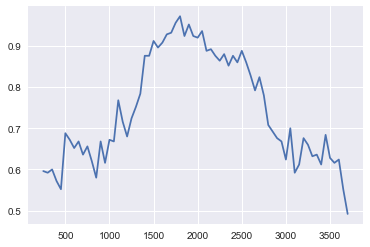

In [60]:
plt.plot(x_plot_ms, accuracies_ms)

### 3a. 500 bin size and 50 step size

In [8]:
accuracy_matrix = decoding_time_matrix(vs_cells, 500, 50)

KeyboardInterrupt: 

In [21]:
accuracy_matrix

array([[0.97, 0.95, 0.9 , ..., 0.23, 0.25, 0.2 ],
       [0.96, 0.97, 0.93, ..., 0.23, 0.25, 0.19],
       [0.91, 0.95, 0.96, ..., 0.22, 0.26, 0.25],
       ...,
       [0.18, 0.2 , 0.19, ..., 0.97, 0.93, 0.95],
       [0.22, 0.2 , 0.21, ..., 0.95, 0.95, 0.97],
       [0.21, 0.22, 0.17, ..., 0.89, 0.93, 0.97]])

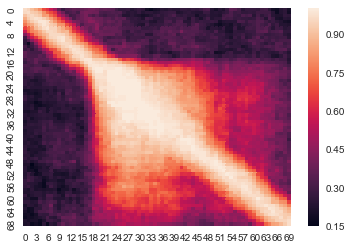

In [22]:
sns.heatmap(accuracy_matrix)

Using bin size of 500 and step size of 50 we can see the accuracy heatmap can be plotted above. The brighter the boxes, the higher the accuracy. Each box is size 50. From the heatmap we can see that starting from 800 milliseconds, we can use the classifier that trains on spike counts in a 500 time bin to accuratly decode most of the time bins after that. 

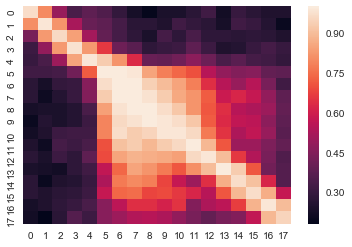

In [23]:
accuracy_bin_200 = decoding_time_matrix(vs_cells, 500, 200)
sns.heatmap(accuracy_bin_200)

Using a larger step size with 200 we can see a clearer picture of the heatmap. Showing the same result as the above.

### 3b. The VS decoding accuracy over time.

In [54]:
accuracies_vs, x_plot_vs = decoding_over_time(vs_cells, 500, 50, 'visual', vs_decoding_model)

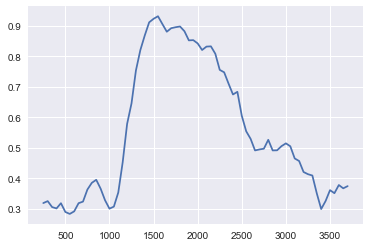

In [55]:
plt.plot(x_plot_vs, accuracies_vs)

The analysis is done on a 500 millisecion time bin and step size of 50. From the above graph we can see that before 1000 milliseconds, where the baseline period is at, the decoding accuracy is around 50% which is just random. After 1000 millisecond the decoding accuracy increases dramatically and peak above 95% at around 1600 millisecond. The decoding accuracy remains above 60% until around 2700 milliseond. 

It makes sense because the VS cells are selected using the 1x5 Anova analysis based on the spike rates extracted from the 1200 to 2700 millisecond period.

In [41]:
accuracies_test, x_plot_test = decoding_over_time(vs_cells, 500, 50, 'visual', vs_decoding_simple_cv)

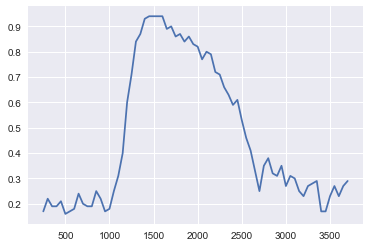

In [42]:
plt.plot(x_plot_test, accuracies_test)

In [25]:
accuracies_ms, x_plot_ms = decoding_over_time(ms_cells, 500, 50, 'memory', decoding_simple_cv)

UnboundLocalError: local variable 'x_new' referenced before assignment

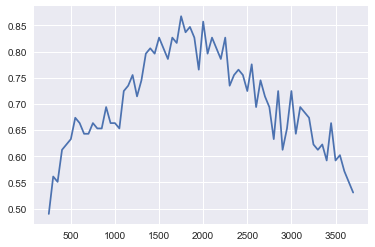

In [36]:
plt.plot(x_plot_ms, accuracies_ms)